# Filtering and Restoring of Mixed and Noise Polluted Audio Samples Using Different Approaches

In [1]:
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

inp_folder = 'audio'
outp_folder = 'output'

In [2]:
file_names = ['speech.wav', 'street-noise.wav', 'music.wav', 'white-noise.wav', 'tone_10kHz.wav']

audio_speech, sr_speech = sf.read(os.path.join(inp_folder, file_names[0])) # , always_2d=True
audio_street, sr_street = sf.read(os.path.join(inp_folder, file_names[1]))
audio_music, sr_music = sf.read(os.path.join(inp_folder, file_names[2]))
audio_wnoise, sr_wnoise = sf.read(os.path.join(inp_folder, file_names[3]))
audio_test_tone, sr_test_tone = sf.read(os.path.join(inp_folder, file_names[4]))
print("Array Type is: {}".format(audio_music.dtype))
# Attenuate white noise amplitude 
attenuation_ratio = 1/4
audio_files = [audio_speech, audio_street, audio_music, audio_wnoise * attenuation_ratio, audio_test_tone]
sample_rates = [sr_speech, sr_street, sr_music, sr_wnoise, sr_test_tone]

for name, sr, audio in zip(file_names, sample_rates, audio_files):
    print("File: {}, Sample Rate: {}, Samples: {}, Time: {}sec".format(name, sr, len(audio), len(audio)/sr))

Array Type is: float64
File: speech.wav, Sample Rate: 8000, Samples: 380389, Time: 47.548625sec
File: street-noise.wav, Sample Rate: 16000, Samples: 2030446, Time: 126.902875sec
File: music.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: white-noise.wav, Sample Rate: 44100, Samples: 414767, Time: 9.40514739229025sec
File: tone_10kHz.wav, Sample Rate: 44100, Samples: 441001, Time: 10.000022675736961sec


In [3]:
make_mono = True
# Reduce from stereo to mono
if make_mono:
    for ii, audio in enumerate(audio_files):
        if len(audio.shape) == 2:
            peak_l = max(audio[:, 0])
            peak_r = max(audio[:, 1])
            peak_pre = max(peak_l, peak_r)
            audio_files[ii] = np.sum(audio, axis=1)
            audio_files[ii] /= max(audio_files[ii])
            audio_files[ii] *= peak_pre
            print("Shape File {}: {}".format(ii+1, audio_files[ii].shape))       

Shape File 2: (2030446,)
Shape File 3: (352800,)
Shape File 4: (414767,)


In [4]:
import samplerate

max_sr = max(sample_rates)
converter = 'sinc_best'

for ii, (audio, sr) in enumerate(zip(audio_files, sample_rates)):
    if sr != max_sr:
        ratio = max_sr / sr
        audio_files[ii] = samplerate.resample(audio, ratio, converter)
        print("New Shape: {}".format(audio_files[ii].shape))
        sample_rates[ii] = max_sr
        
for name, audio in zip(file_names, audio_files):
    print("File: {}, Sample Rate: {}, Samples: {}, Time: {}sec".format(name, max_sr, len(audio), len(audio)/sr))

New Shape: (2096894,)
New Shape: (5596416,)
File: speech.wav, Sample Rate: 44100, Samples: 2096894, Time: 47.54861678004535sec
File: street-noise.wav, Sample Rate: 44100, Samples: 5596416, Time: 126.90285714285714sec
File: music.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: white-noise.wav, Sample Rate: 44100, Samples: 414767, Time: 9.40514739229025sec
File: tone_10kHz.wav, Sample Rate: 44100, Samples: 441001, Time: 10.000022675736961sec


In [5]:
# Find minimal audio length
audio_length = []
for ii, audio in enumerate(audio_files):
    audio_length.append(len(audio))
max_length = min(audio_length)
print("Minimal number of audio samples: {}".format(max_length))

Minimal number of audio samples: 352800


In [6]:
# Determine Audio length
# Neede samples are samples = time * sample_rate
time = max_length / sample_rates[audio_length.index(max_length)]

adj_audio_length = []
for sr in sample_rates:
    adj_audio_length.append(int(time * sr))

print("Max audio length is {} s".format(time))
for name, smp_has, smp_should in zip(file_names, audio_length, adj_audio_length):
    print("File {} has {} Samples and must have {}".format(name, smp_has, smp_should))

Max audio length is 8.0 s
File speech.wav has 2096894 Samples and must have 352800
File street-noise.wav has 5596416 Samples and must have 352800
File music.wav has 352800 Samples and must have 352800
File white-noise.wav has 414767 Samples and must have 352800
File tone_10kHz.wav has 441001 Samples and must have 352800


In [7]:
# Unify audio file length
for ii, smp in enumerate(adj_audio_length):
    audio_files[ii] = audio_files[ii][:smp]
    print("Shape file {}: {}".format(ii+1, audio_files[ii].shape))

Shape file 1: (352800,)
Shape file 2: (352800,)
Shape file 3: (352800,)
Shape file 4: (352800,)
Shape file 5: (352800,)


# Time-Domain

Time plot of original audio files $u$ and noise sources $v$.

| Audio | Symbol |
| --- | --- |
| Speech | $u_s$ | 
| Street Noise | $v_{sn}$ |
| Music | $u_m$ |
| White Noise | $v_{wn}$ |

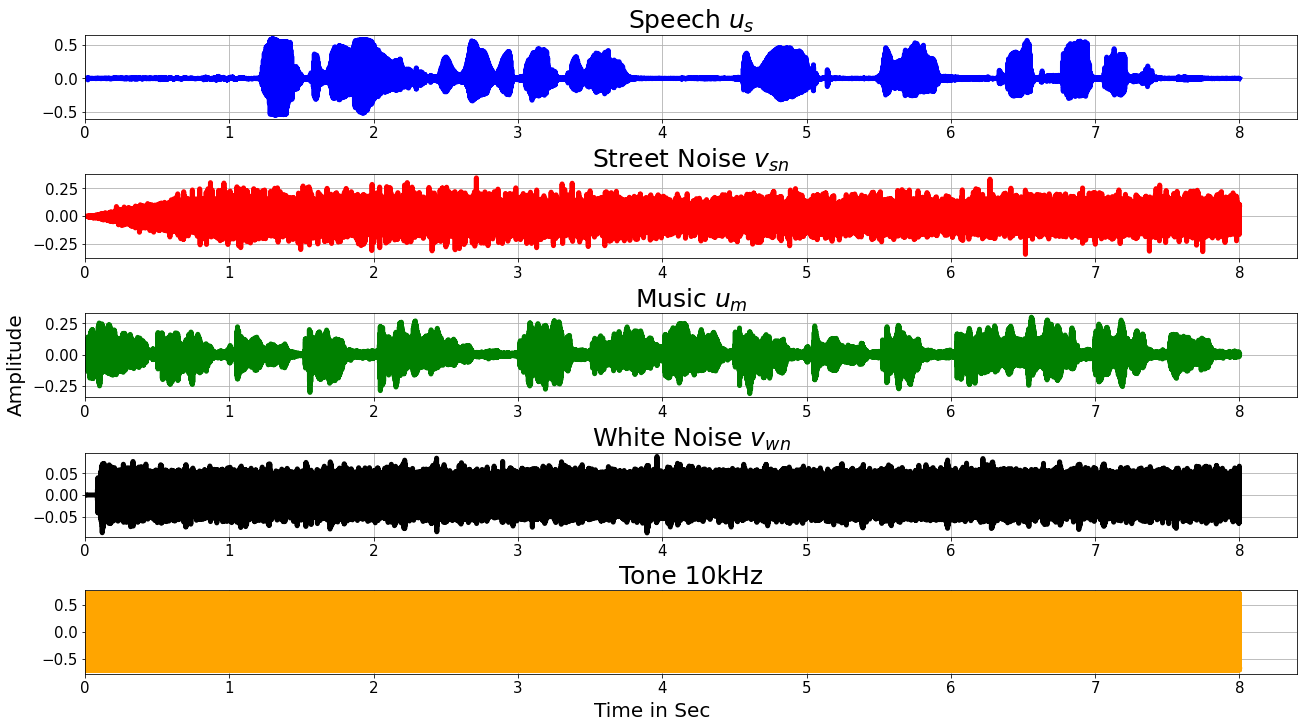

In [8]:
fig, axs = plt.subplots(len(audio_files), 1, figsize=[18, 10], sharex=False, constrained_layout = True)
audio_names = ['Speech $u_s$', 'Street Noise $v_{sn}$', 'Music $u_m$', 'White Noise $v_{wn}$', 'Tone 10kHz']
colors = ['blue', 'red', 'green', 'black', 'orange']
for ii, (audio, name, sr, color) in enumerate(zip(audio_files, audio_names, sample_rates, colors)):
    x_axis = np.arange(0, len(audio)) / sr
    axs[ii].plot(x_axis, audio, lw=5, color=color)
    axs[ii].set_title(name, fontsize=25)

fig.supylabel('Amplitude', fontsize=20)
fig.supxlabel('Time in Sec', fontsize=20)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

# Spectrum

Frequencies in original audio files.

In [9]:
# Fast Fourier Transform
from scipy.fftpack import fft, fftfreq

spectrums = []
fft_x = []
for audio, sample_rate, samples in zip(audio_files, sample_rates, adj_audio_length):
    frequencies = fft(audio)
    T = 1/sample_rate
    x_axis = fftfreq(samples, T)[:samples//2]
    spectrums.append(2.0/samples * np.abs(frequencies[0:samples//2]))
    fft_x.append(x_axis)


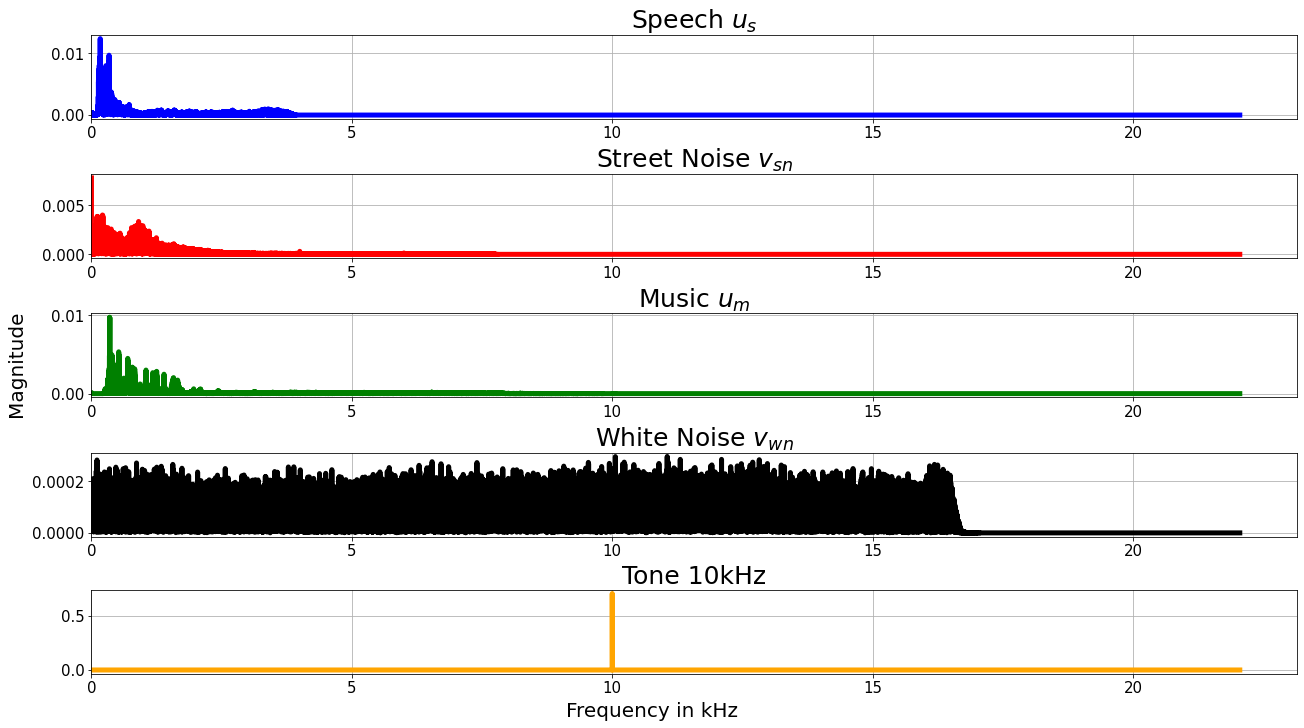

In [10]:
fig, axs = plt.subplots(len(audio_files), 1, figsize=[18, 10], sharex=False, constrained_layout = True)

for ii, (spectrum, x_axis, name, color) in enumerate(zip(spectrums, fft_x, audio_names, colors)):
    axs[ii].plot(x_axis / 1e3, spectrum, lw=5, color=color)
    axs[ii].set_title(name, fontsize=25)

fig.supylabel('Magnitude', fontsize=20)
fig.supxlabel('Frequency in kHz', fontsize=20)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

In [11]:
# Save Files
names_source_out = ['speech_source.wav', 'street_source.wav', 'music_source.wav', 'white_noise_source.wav', 'tone_10kHz_source.wav']
for name, audio, sr in zip(names_source_out, audio_files, sample_rates):
    sf.write(os.path.join(outp_folder, name), audio, sr)

# Mix Signals

Generate four observations $d$. 

1. Music + White Noise $d_{m+wn}$
1. Street Noise + Music $d_{sn+m}$
1. Street Noise + Music + Speech $d_{sn+m+s}$
1. Speech + White Noise $d_{s+wn}$

In [12]:
# 1           Music +       White Noise
d_m_wn = audio_files[2] + audio_files[3]
# 2           Street +      Music
d_sn_m = audio_files[1] + audio_files[2]
# 3 :         Street +      Music +             Speech
d_sn_m_s = audio_files[1] + audio_files[2] + audio_files[0]
# 4 :         Speech +      White Noise
d_s_wn = audio_files[0] + audio_files[3]

observations = [d_m_wn, d_sn_m, d_sn_m_s, d_s_wn]


## Add seed for same results

In [13]:
np.random.seed(10)

# Independent Component Analysis (ICA)

ICA is a method for seperating a multivariate signal into components. 

Steps:

1. Center $\mathbf{d}$ by subtracting the mean
1. Whiten
1. Choose random initial value for the de-mixing matrix $\mathbf{W}$
1. Calculate the new value for $\mathbf{W}$
1. Normalize $\mathbf{W}$
1. Check whether algorithm has converged and if it hasn’t, return to step 4
1. Take the dot product of $\mathbf{W}$ and $\mathbf{d}$ to get the independent source signals
$$\mathbf{S} = \mathbf{W}\mathbf{d}$$

Source:
* [Independent Component Analysis (ICA) In Python, Cory Maklin](https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e)
* [Separating mixed signals with Independent Component Analysis, Carsten Klein](https://towardsdatascience.com/separating-mixed-signals-with-independent-component-analysis-38205188f2f4)

In [14]:
from sklearn.decomposition import FastICA

### Build Observation using True Signals

Generating signals for observation #3 and apply to "cocktail party problem". 

One recording per existing signal is used here. The recorded signal contains a proportion of pollution caused by the other signals.

In [15]:
# 3 :                   Street +            Music +                 Speech
d_sn_m_s_1 = 0.3 * audio_files[1] + 0.3 * audio_files[2] + 0.4 * audio_files[0]
d_sn_m_s_2 = 0.6 * audio_files[1] + 0.2 * audio_files[2] + 0.2 * audio_files[0]
d_sn_m_s_3 = 0.1 * audio_files[1] + 0.7 * audio_files[2] + 0.2 * audio_files[0]
true_signal = np.c_[audio_files[0], audio_files[1], audio_files[2]]

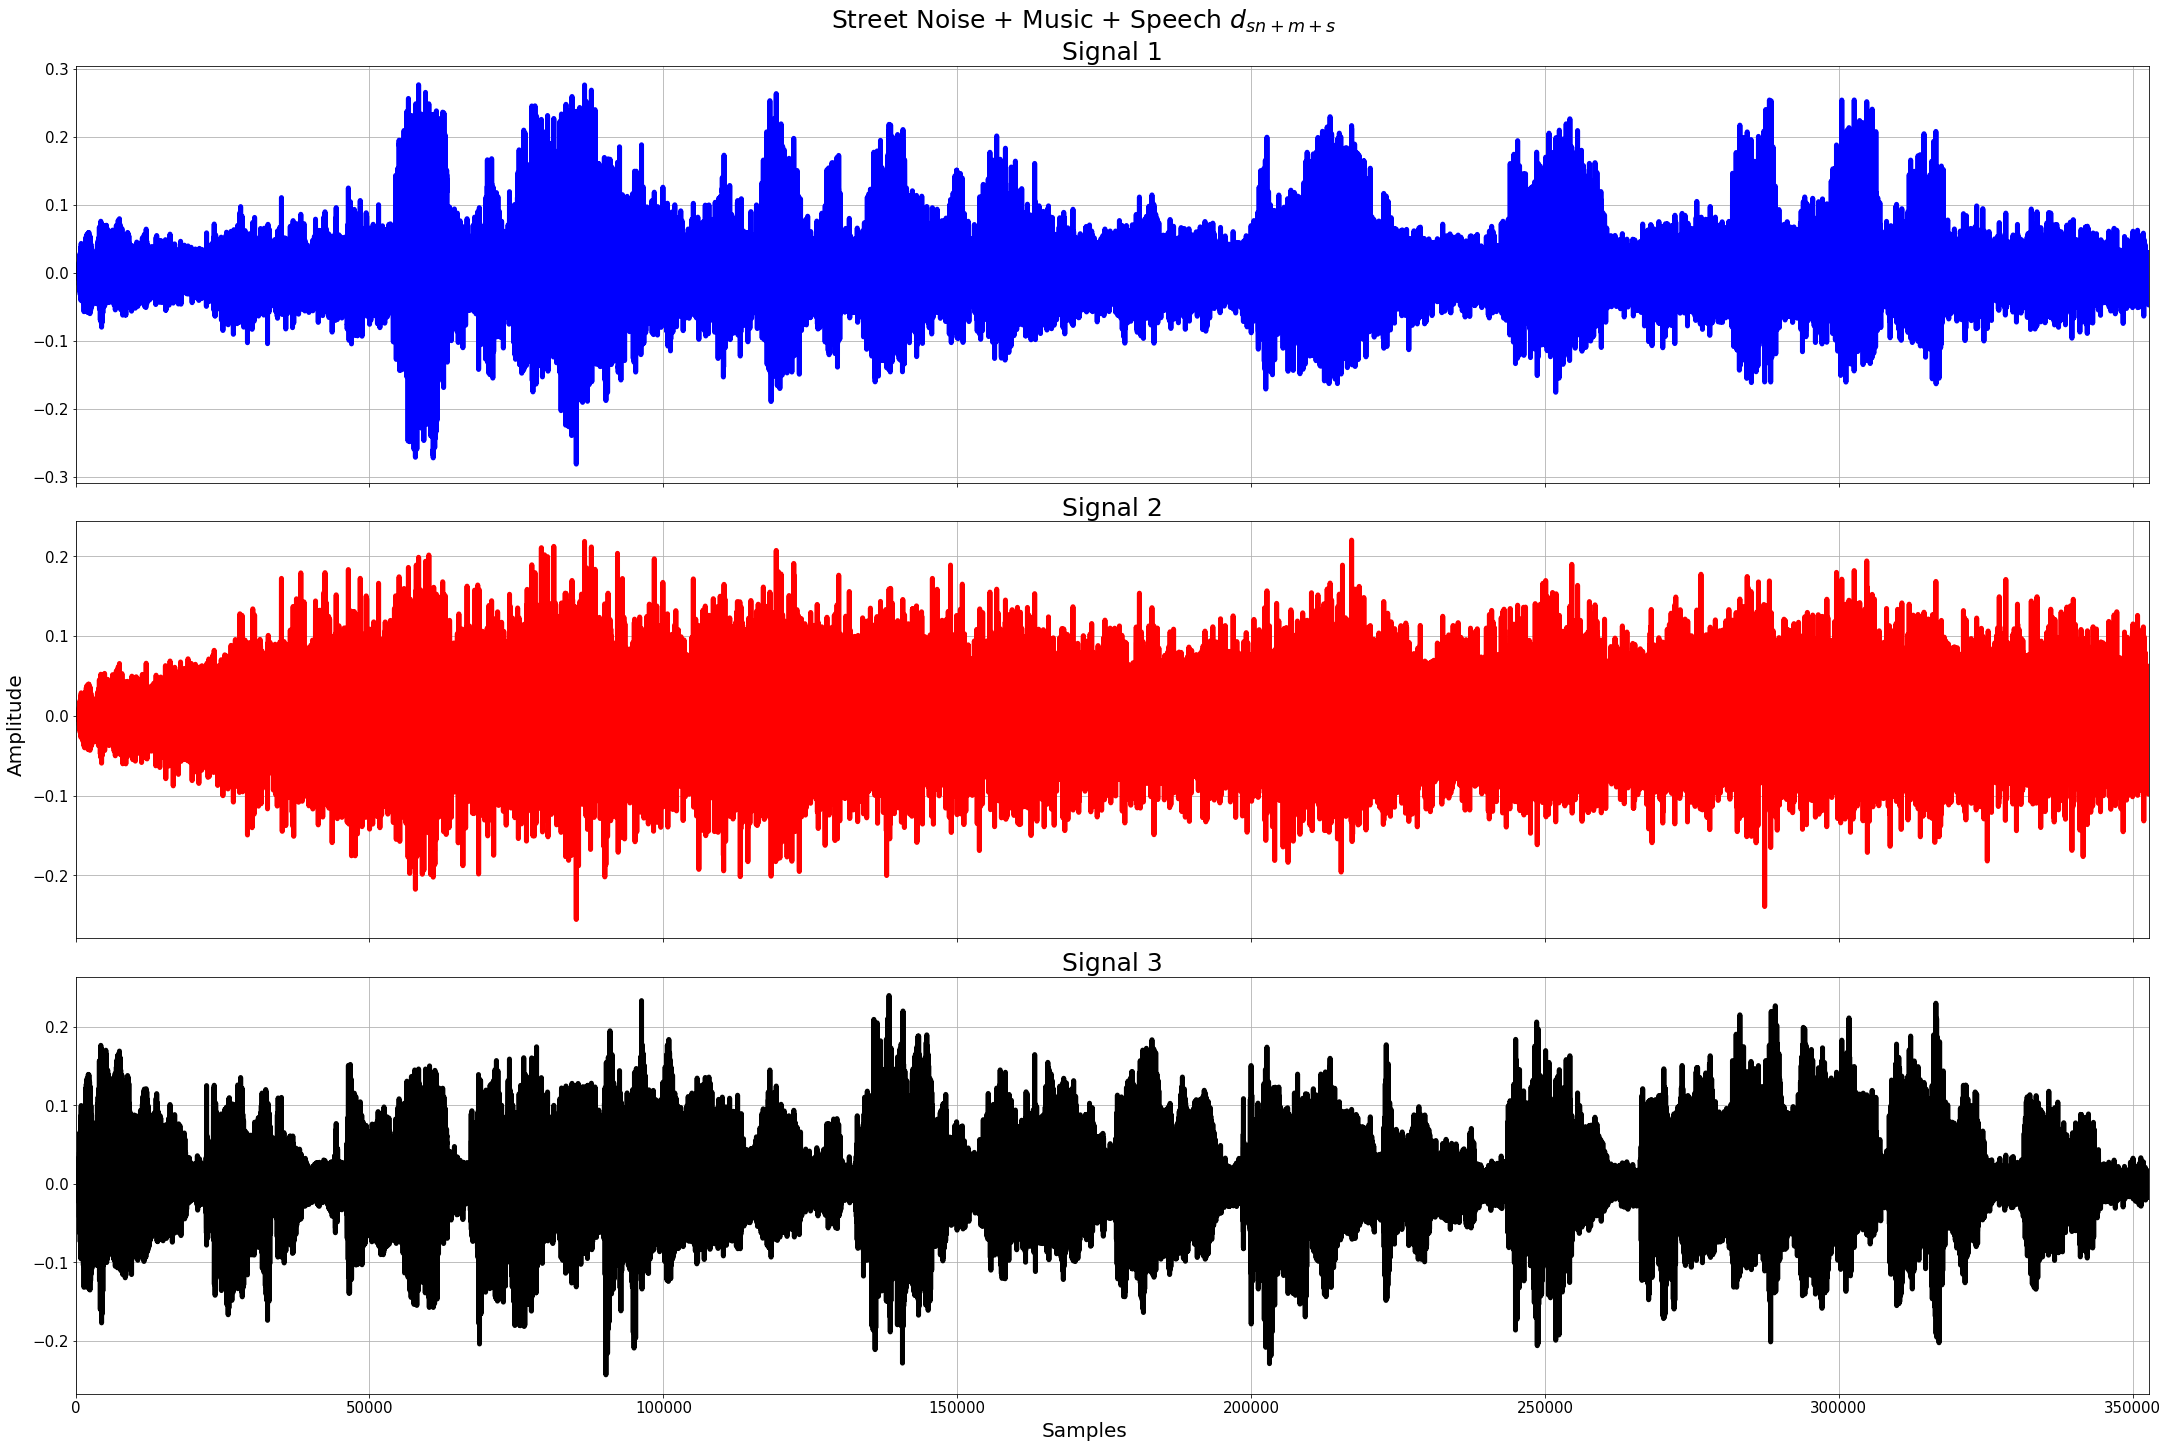

In [16]:
fig, axs = plt.subplots(3, 1, figsize=[30, 20], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)
fig.supxlabel('Samples', fontsize=20)
fig.suptitle('Street Noise + Music + Speech $d_{sn+m+s}$', fontsize=25)

axs[0].plot(d_sn_m_s_1, lw=5, color='blue')
axs[0].set_title('Signal 1', fontsize=25)
axs[1].plot(d_sn_m_s_2, lw=5, color='red')
axs[1].set_title('Signal 2', fontsize=25)
axs[2].plot(d_sn_m_s_3, lw=5, color='black')
axs[2].set_title('Signal 3', fontsize=25)

for ax in axs: 
    ax.set_xlim(0, max_length)
    ax.tick_params(labelsize=15)
    ax.grid()

### Combine and Normalize Observations

In [17]:
observation = np.c_[d_sn_m_s_1, d_sn_m_s_2, d_sn_m_s_3]

observation /= observation.std(axis=0)

### Add Additional Distortion

In [18]:
add_distortion = False
if add_distortion:
    mixing = np.array([[0.5, 1, 0.2],
                        [1, 0.5, 0.4],
                        [0.5, 0.8, 1]])
                        
    observation = np.dot(true_signal, mixing.T) 

In [19]:
# Save ICA signal
def save_ica_audio(audio, name):
    names_ica = []
    for ii in range(audio.shape[1]):
        names_ica.append('ica_{}_ch{}.wav'.format(name, ii+1))

    for ii, (name, sr) in enumerate(zip(names_ica, sample_rates)):
        sf.write(os.path.join(outp_folder, name), audio[:,ii], sr)

### Apply FastICA

In [20]:
ica = FastICA() #n_components=3
ica_recovered = ica.fit_transform(observation) 

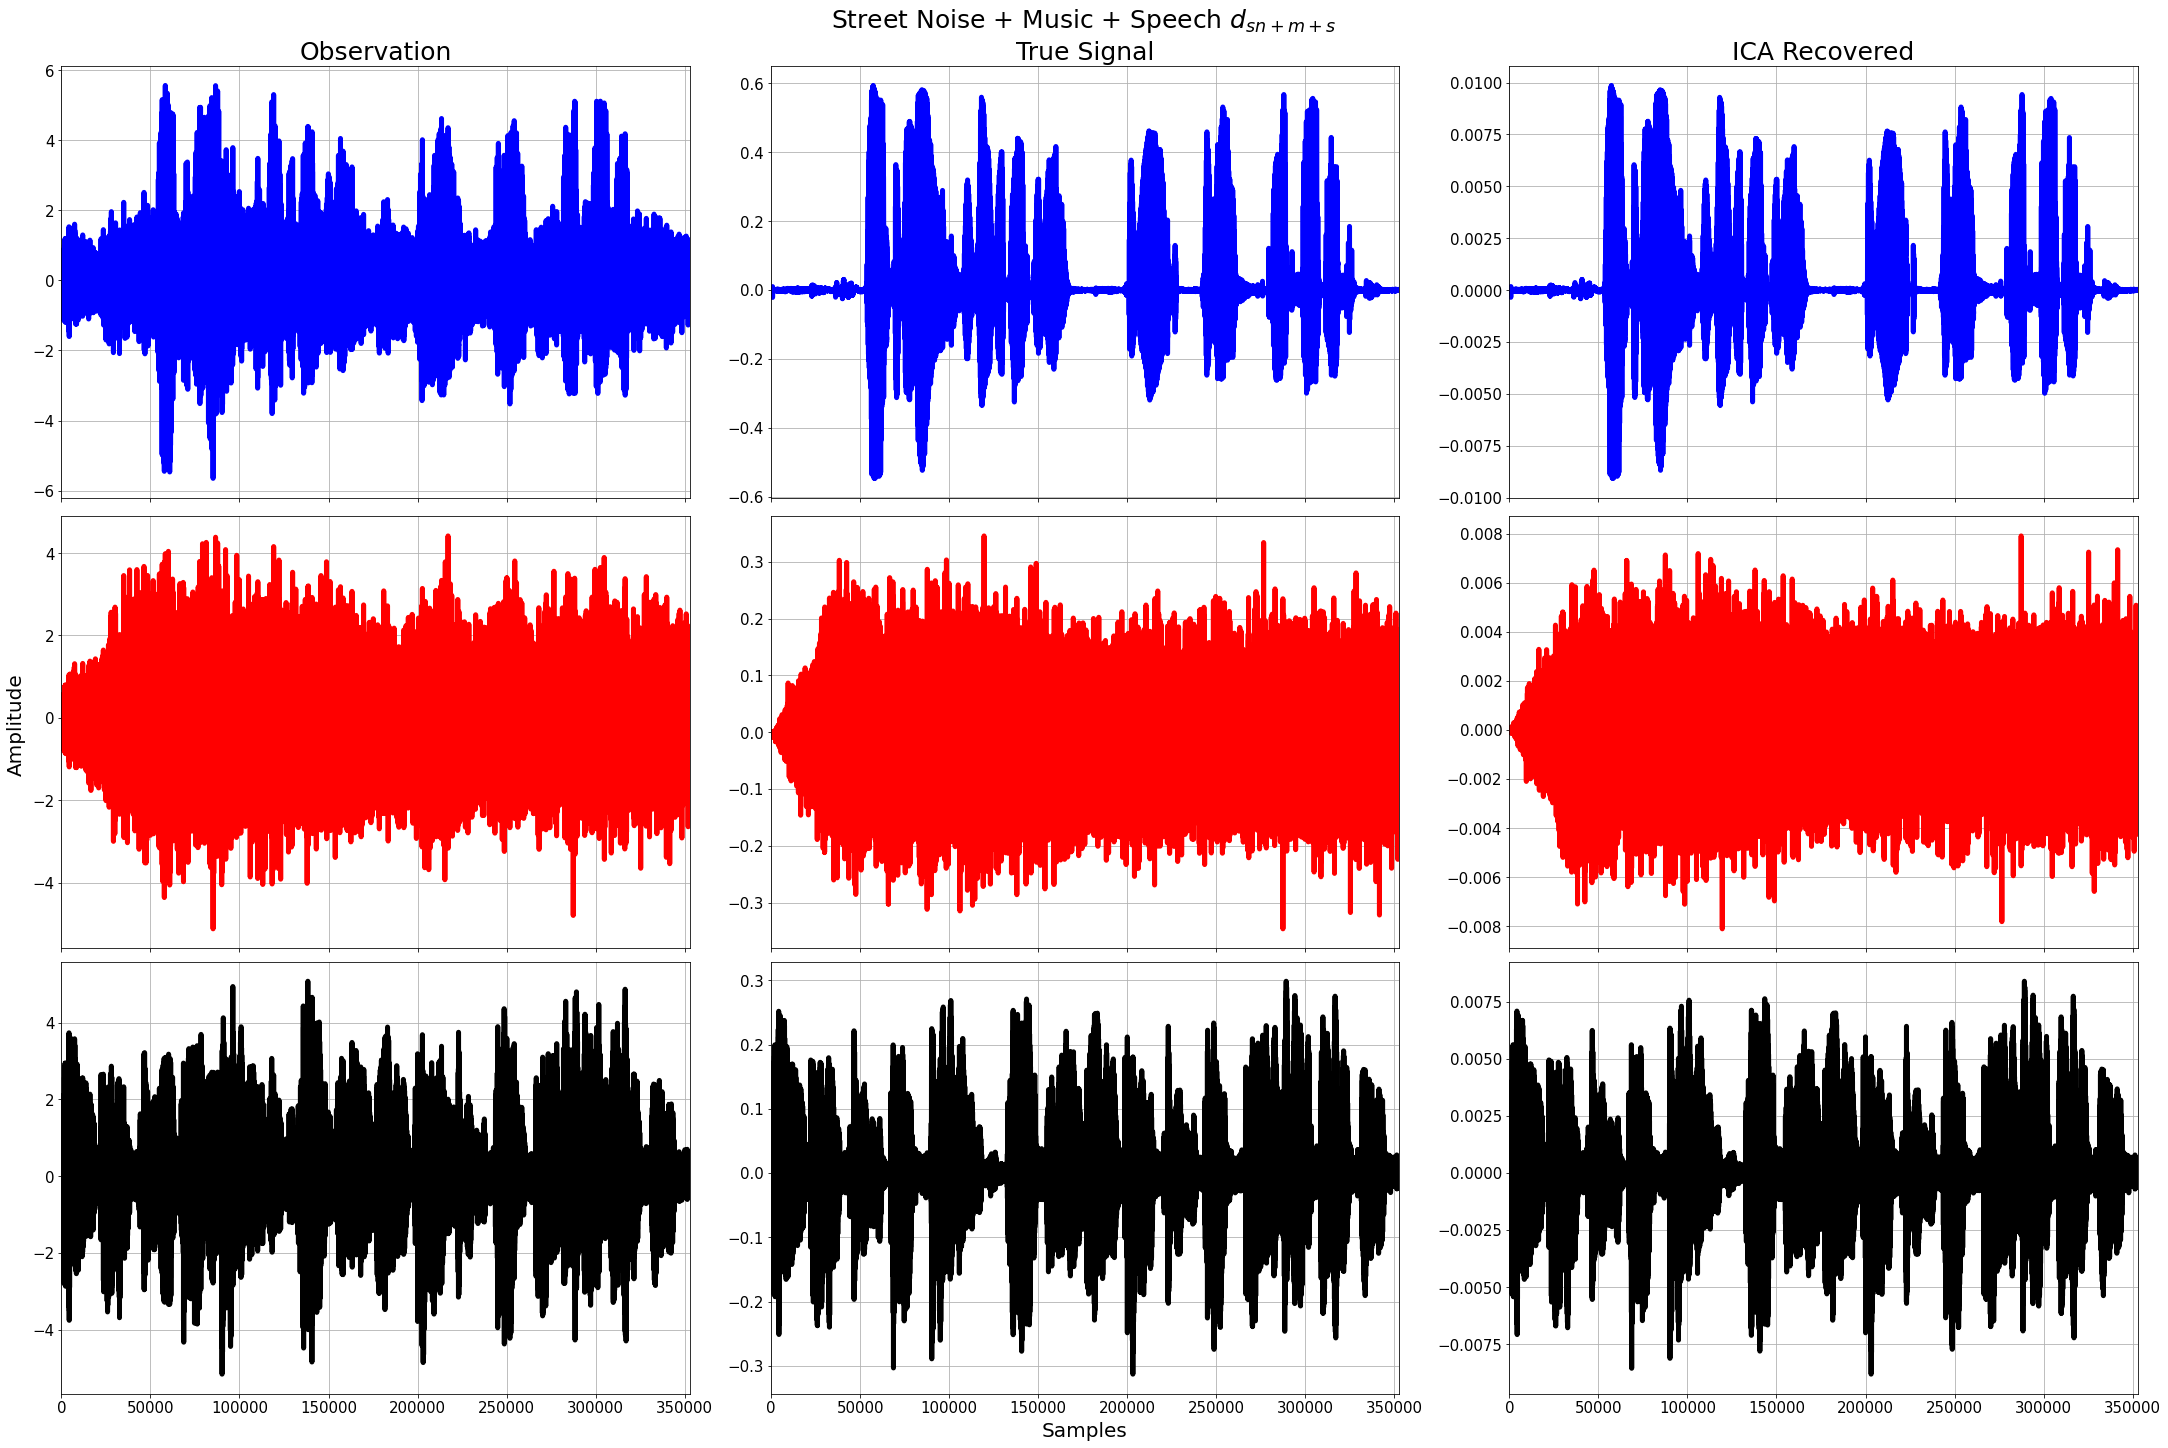

In [21]:
simple_plot = False
if simple_plot:
    fig, axs = plt.subplots(3, 1, figsize=[30, 20], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)
    fig.supxlabel('Samples', fontsize=20)
    fig.suptitle('Street Noise + Music + Speech $d_{sn+m+s}$', fontsize=25)
    
    axs[0].plot(ica_recovered[:, 0], lw=5, color='blue')
    axs[0].set_title('ICA Recovered', fontsize=25)
    axs[1].plot(ica_recovered[:, 1], lw=5, color='red')
    axs[2].plot(ica_recovered[:, 2], lw=5, color='black')

    for ax in axs: 
        ax.set_xlim(0, max_length)
        ax.tick_params(labelsize=15)
        ax.grid()
else:
    ica_lst = [observation, true_signal, ica_recovered]
    ica_name = ['Observation', 'True Signal', 'ICA Recovered']
    fig, axs = plt.subplots(3, 3, figsize=[30, 20], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)
    fig.supxlabel('Samples', fontsize=20)
    fig.suptitle('Street Noise + Music + Speech $d_{sn+m+s}$', fontsize=25)

    for ii, (data, name) in enumerate(zip(ica_lst, ica_name)):
        axs[0][ii].plot(data[:, 0], lw=5, color='blue')
        axs[0][ii].set_title(name, fontsize=25)
        axs[1][ii].plot(data[:, 1], lw=5, color='red')
        axs[2][ii].plot(data[:, 2], lw=5, color='black')

    for row in axs: 
        for ax in row: 
            ax.set_xlim(0, max_length)
            ax.tick_params(labelsize=15)
            ax.grid()

In [22]:
# Save observations and recovered signal
save_ica_audio(ica_recovered, 'recv_sig3')
save_ica_audio(observation, 'obs_sig3')

# Perform ICA for the remaining test observations

In [23]:
def ica(true_sig, observation, signal_name, add_distort=False):
    true_sig /= true_sig.std(axis=0)
    observation /= observation.std(axis=0)

    if add_distort:
        mixing = np.array([[0.5, 1],
                            [0.8, 0.2]])
        observation = np.dot(true_sig, mixing.T)
        
    ica = FastICA()
    ica_recovered = ica.fit_transform(observation)

    ica_lst = [observation, true_sig, ica_recovered]
    ica_name = ['Observation', 'True Signal', 'ICA Recovered']
    fig, axs = plt.subplots(2, 3, figsize=[30, 20], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)
    fig.supxlabel('Samples', fontsize=20)

    save_ica_audio(ica_recovered, 'recv_{}'.format(signal_name))
    save_ica_audio(observation, 'obs_{}'.format(signal_name))

    equalize_amp = False
    if equalize_amp:
        ratio = np.abs(true_sig).mean() / np.abs(ica_recovered).mean()
        for ii in range(ica_recovered.shape[1]):
            ica_recovered[:, ii] = ica_recovered[:, ii] * ratio
    
    for ii, (data, name) in enumerate(zip(ica_lst, ica_name)):
        axs[0][ii].plot(data[:, 0], lw=5, color='blue')
        axs[0][ii].set_title(name, fontsize=25)
        axs[1][ii].plot(data[:, 1], lw=5, color='red')

    for row in axs: 
        for ax in row: 
            ax.set_xlim(0, max_length)
            ax.tick_params(labelsize=15)
            ax.grid()



## Remaining Signals

In [24]:
# 1                 Music +             White Noise
d_m_wn_1 = 0.7 * audio_files[2] + 0.3 * audio_files[3]
d_m_wn_2 = 0.3 * audio_files[2] + 0.7 * audio_files[3]
observation_1 = np.c_[d_m_wn_1, d_m_wn_2]
true_signal_1 = np.c_[audio_files[2], audio_files[3]]
# 2                 Street +            Music
d_sn_m_1 = 0.7 * audio_files[1] + 0.3 * audio_files[2]
d_sn_m_2 = 0.3 * audio_files[1] + 0.7 * audio_files[2]
observation_2 = np.c_[d_sn_m_1, d_sn_m_2]
true_signal_2 = np.c_[audio_files[1], audio_files[2]]
# 4 :               Speech +            White Noise
d_s_wn_1 = 0.7 * audio_files[0] + 0.3 * audio_files[3]
d_s_wn_2 = 0.3 * audio_files[0] + 0.7 * audio_files[3]
observation_4 = np.c_[d_s_wn_1, d_s_wn_2]
true_signal_4 = np.c_[audio_files[0], audio_files[3]]

# Music + White Noise $d_{m+wn}$

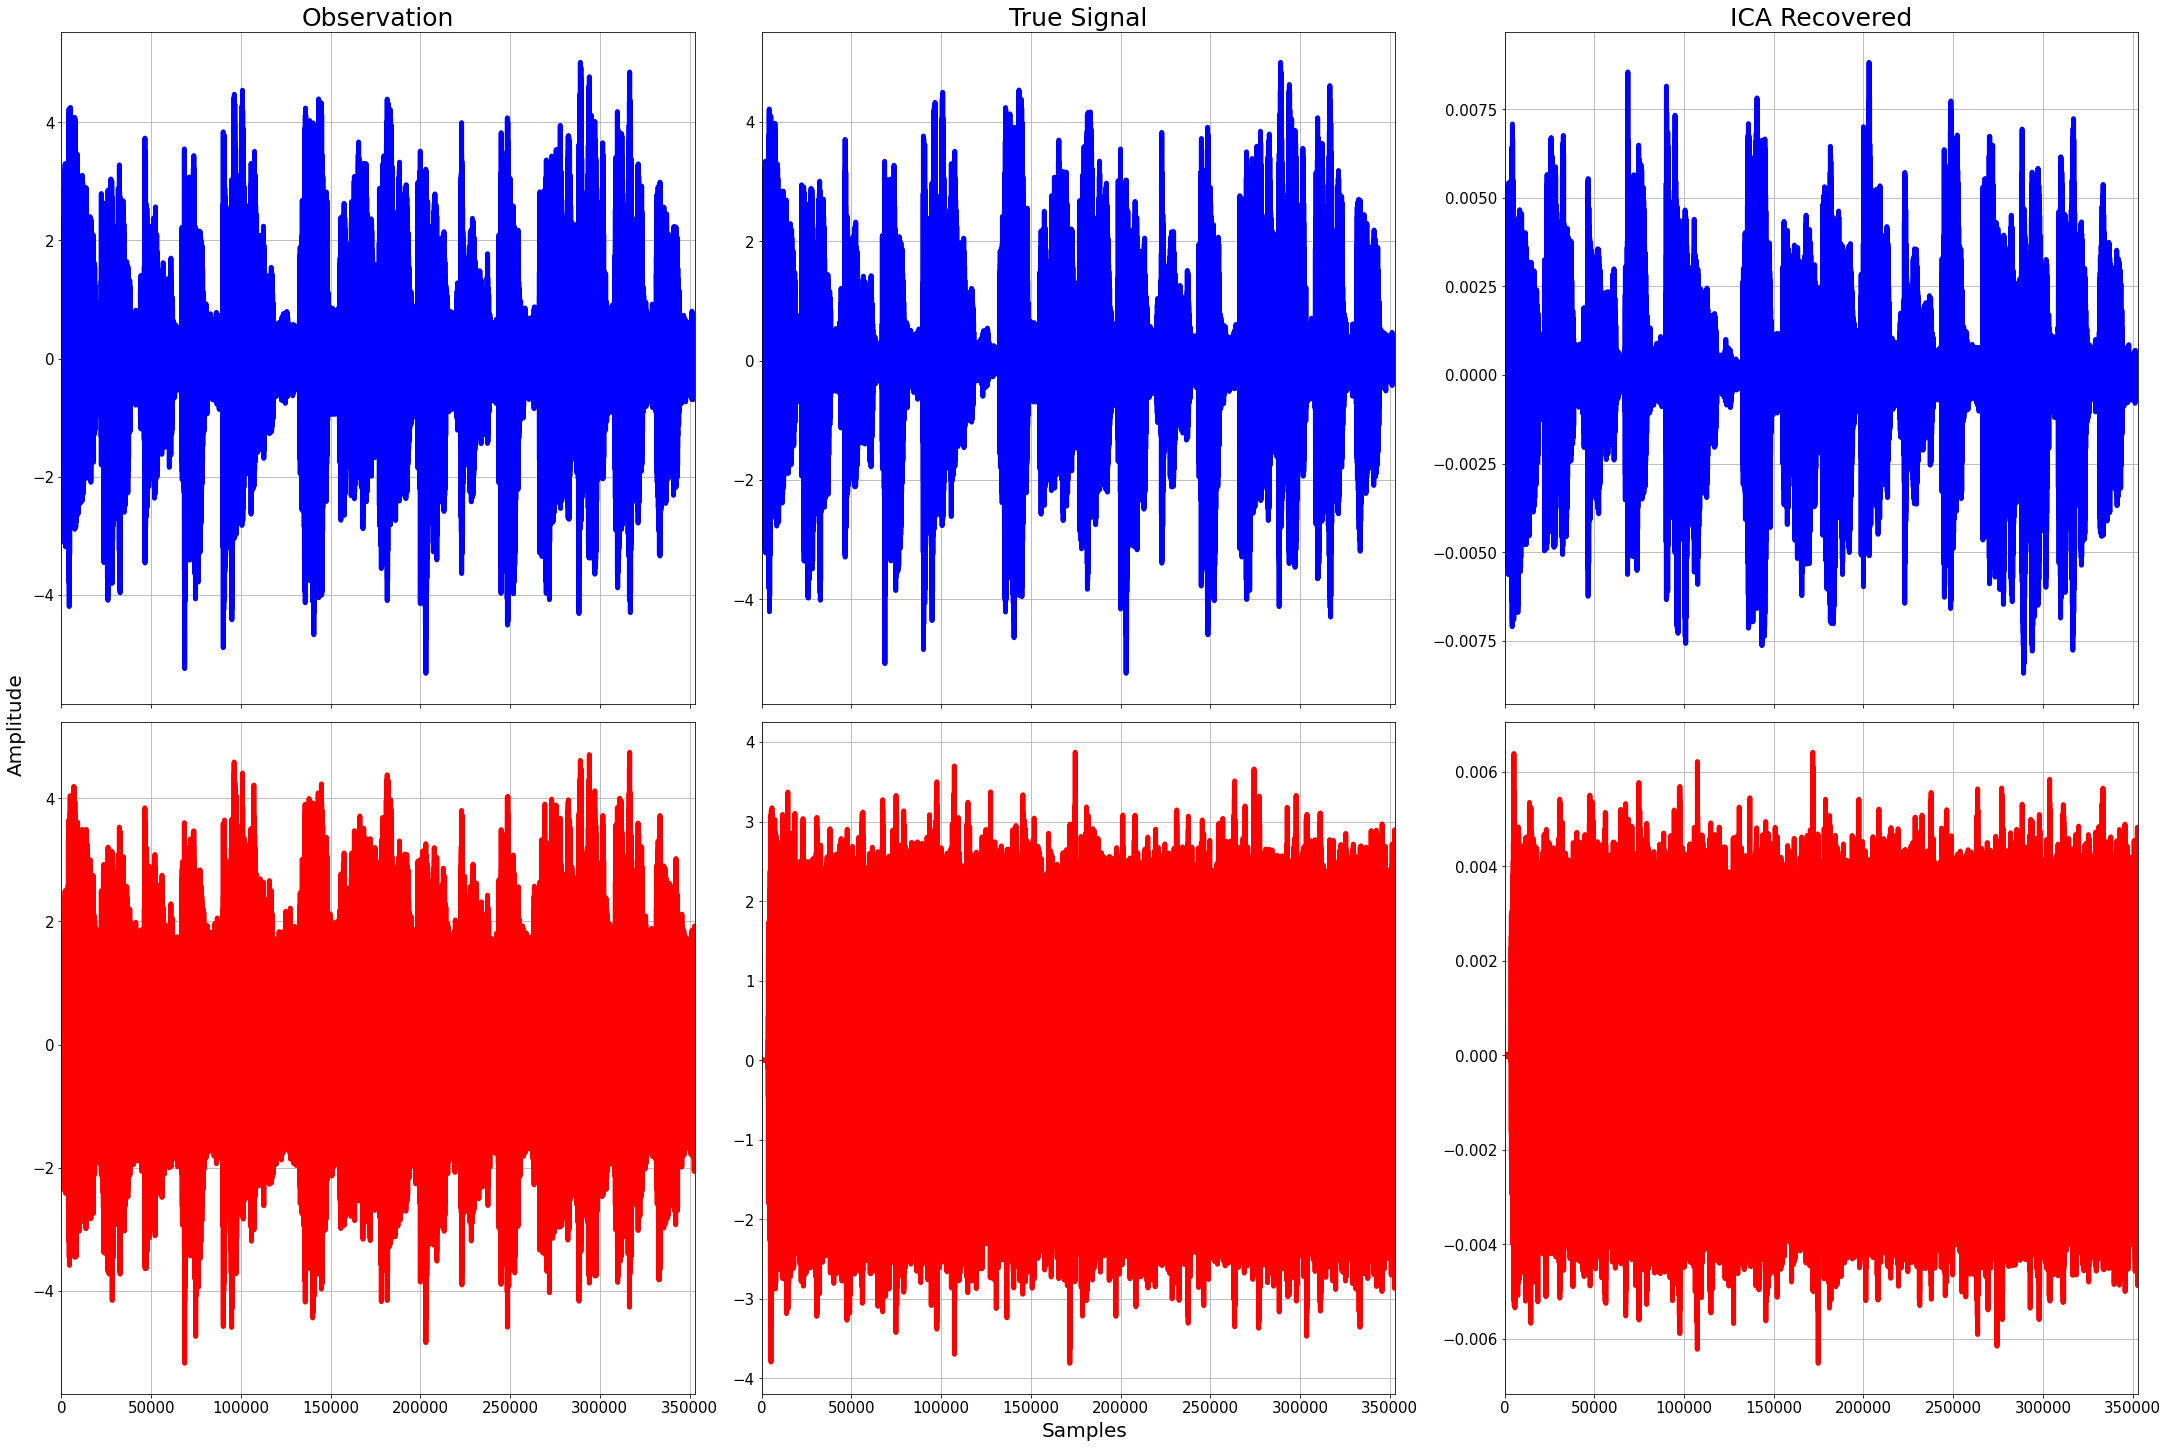

In [25]:
ica(true_signal_1, observation_1, 'sig1')

# Street Noise + Music $d_{sn+m}$

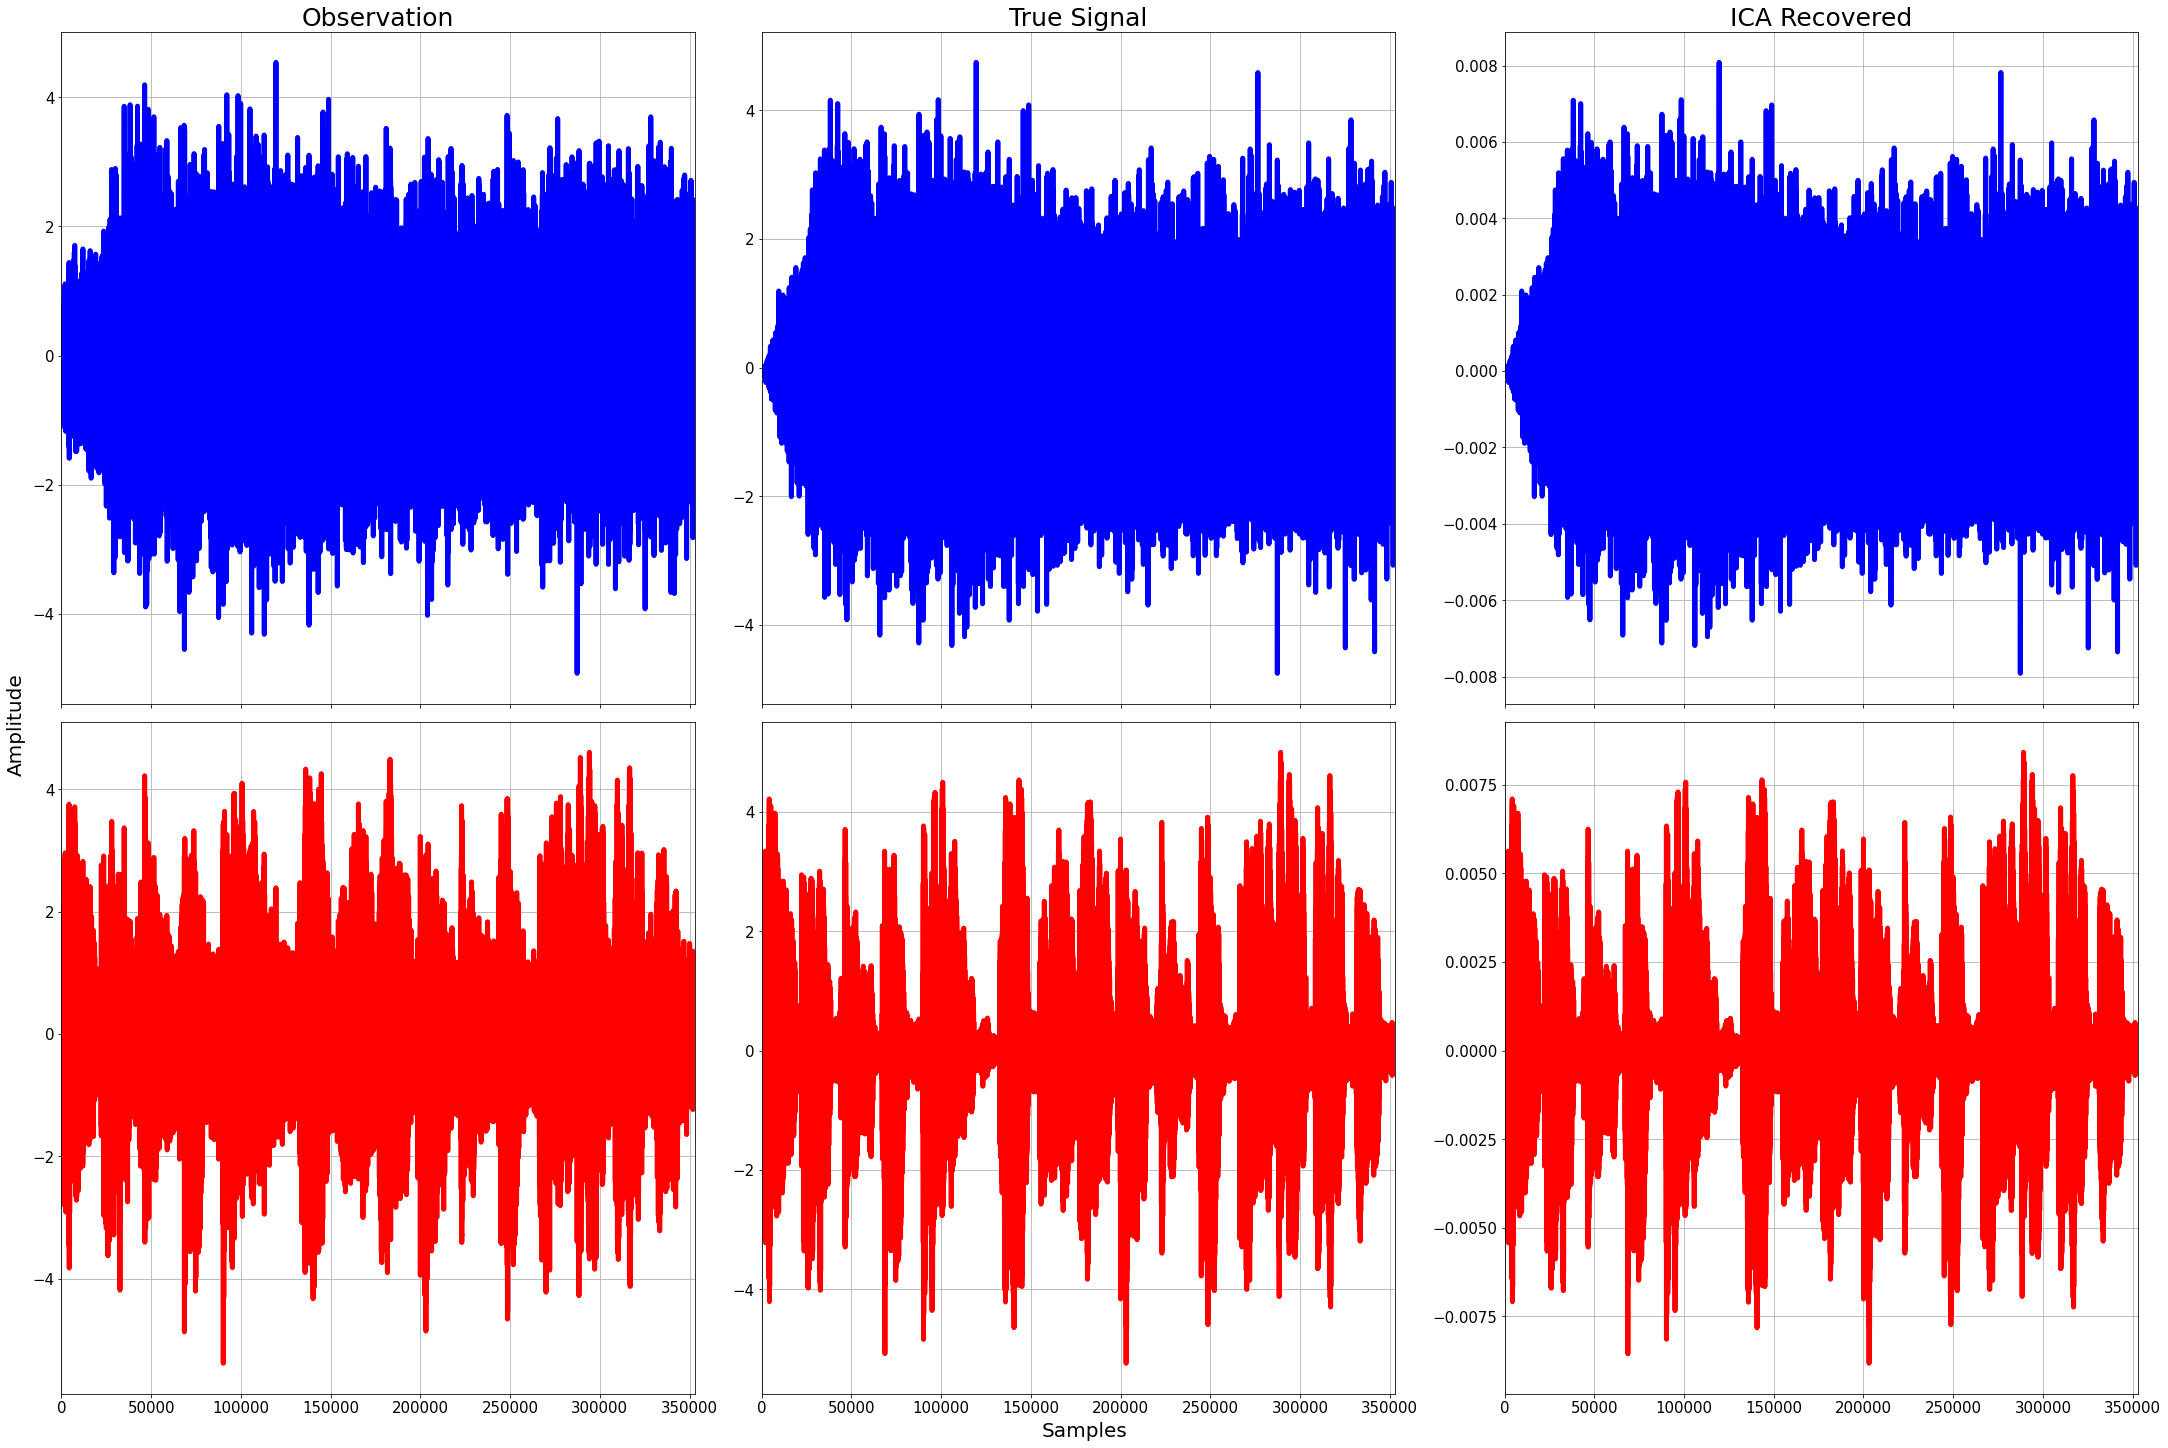

In [26]:
ica(true_signal_2, observation_2, 'sig2')

# Speech + White Noise $d_{s+wn}$

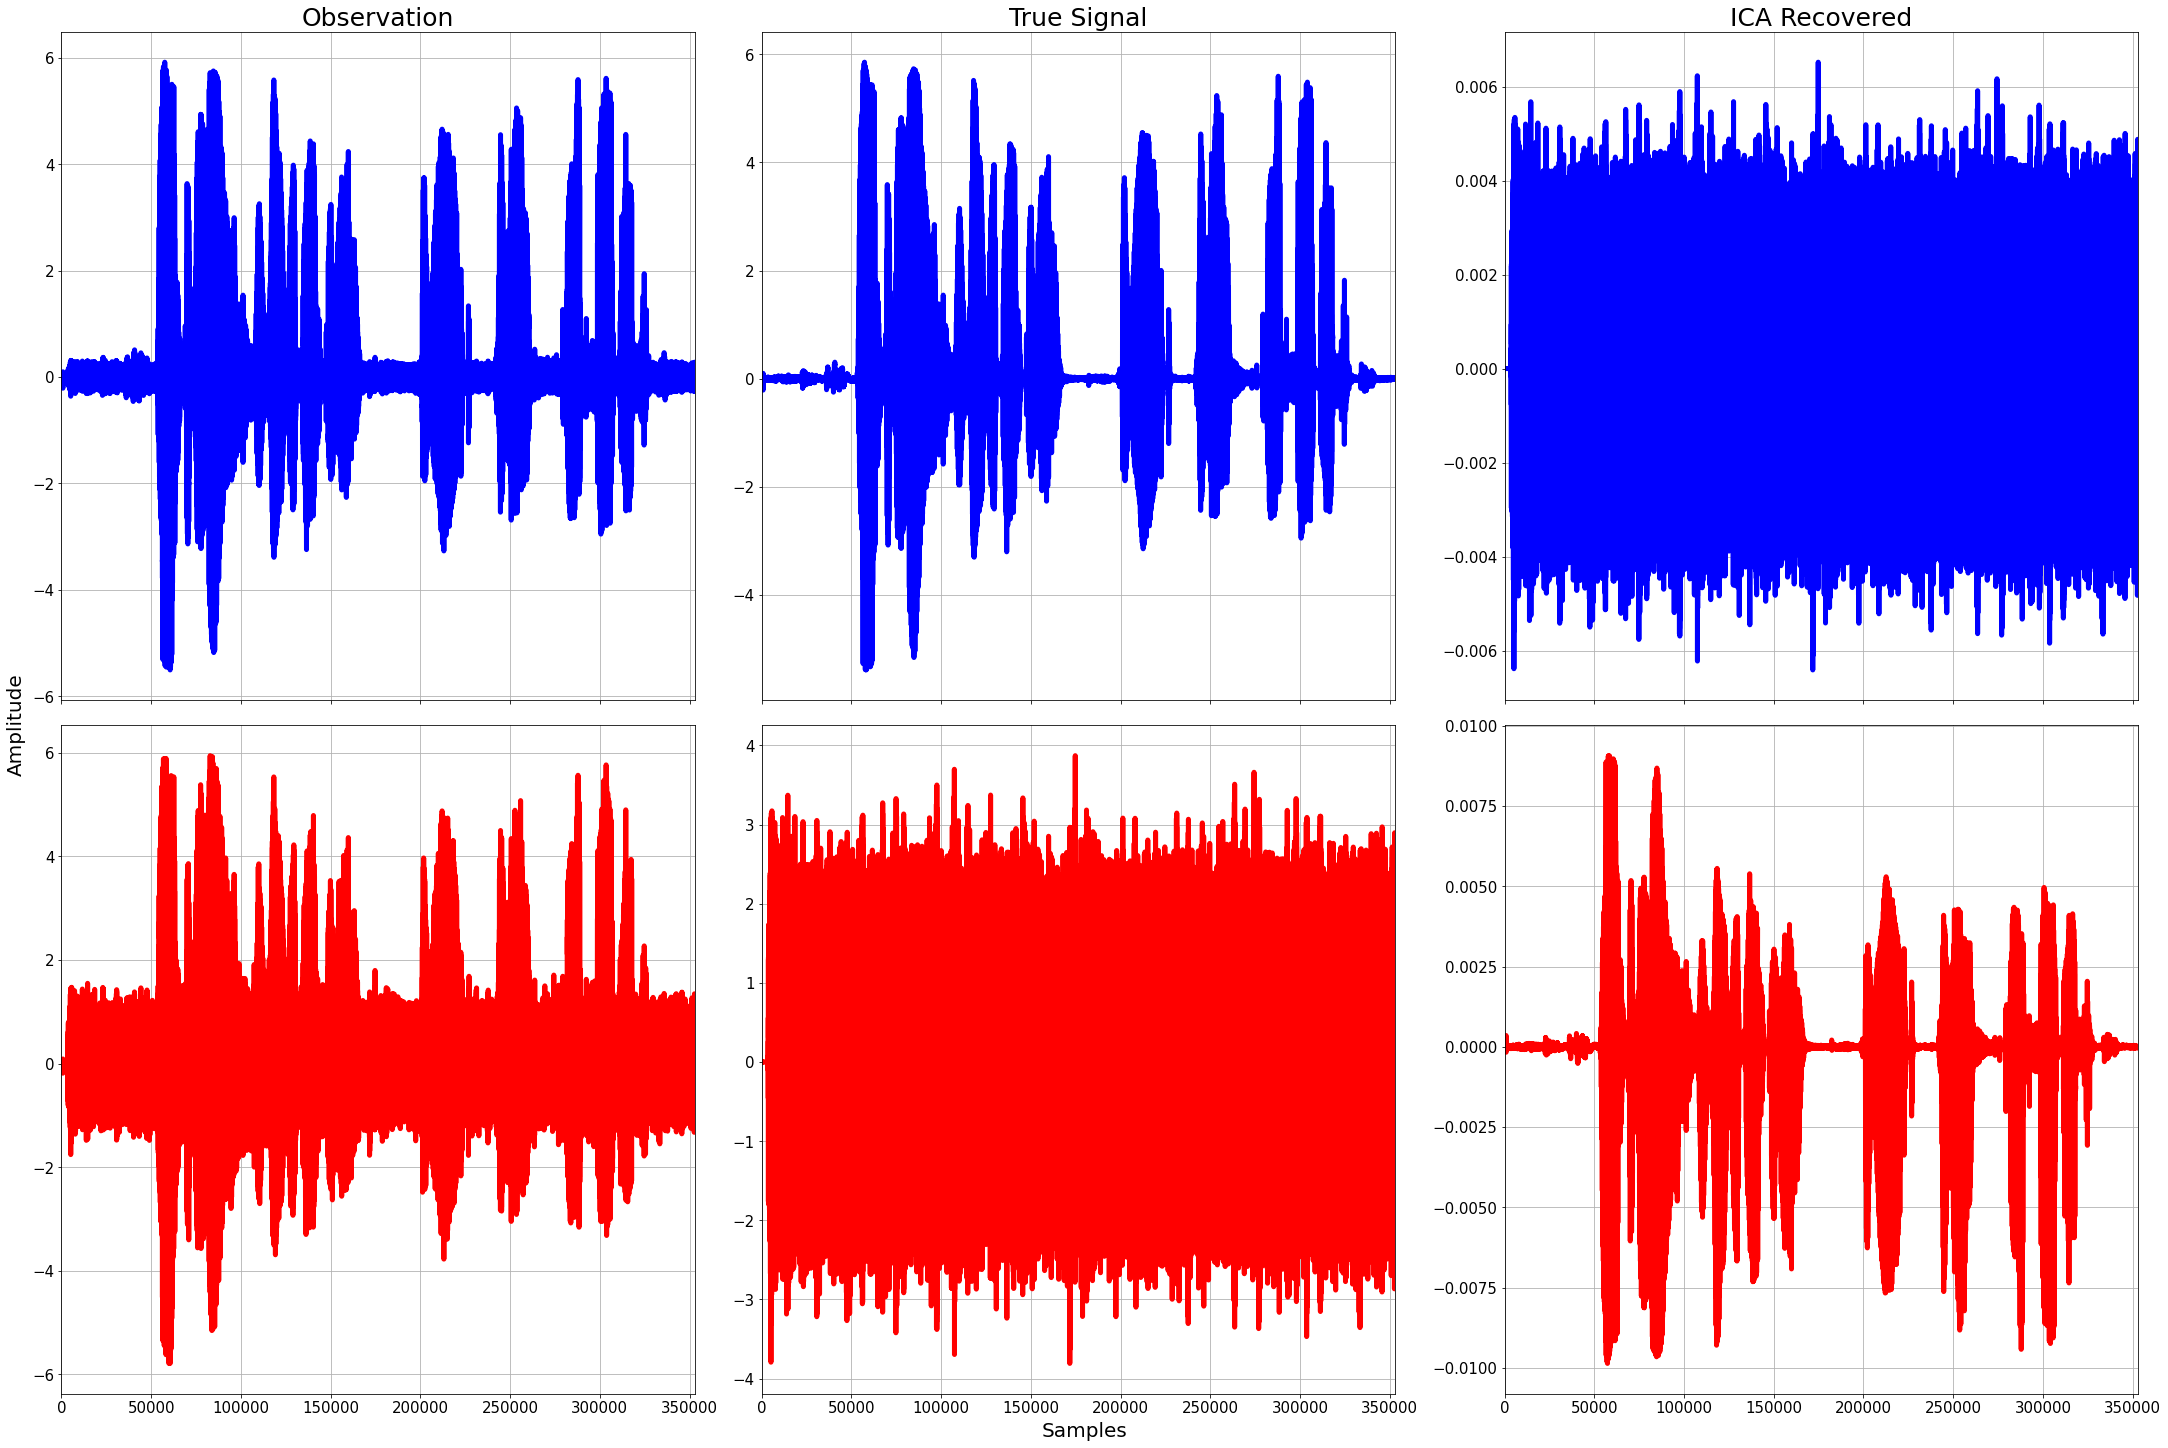

In [27]:
ica(true_signal_4, observation_4, 'sig4')

# Wavelet Transform

Source:
* [Audio Classification using Wavelet Transform and Deep Learning, Aditya Dutt](https://medium.com/mlearning-ai/audio-classification-using-wavelet-transform-and-deep-learning-f9f0978fa246)
* [Choose a Wavelet, MathWorks](https://de.mathworks.com/help/wavelet/gs/choose-a-wavelet.html)

In [28]:
import pywt

In [29]:
# print the wavelet families available
print(pywt.families())
# print a list of available wavelets from one family
print(pywt.wavelist(kind='discrete'))

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym1

In [30]:
wavelet = 'db5'
mode = 'per'

In [31]:
def calc_wavelet(signal, wavelet, mode):
    coeffs = pywt.wavedec(signal, wavelet, mode=mode)
    return coeffs

In [52]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [53]:
def wavelet_denoising(x, wavelet='db4', mode='per', level=1):
    coeff = pywt.wavedec(x, wavelet, mode=mode)
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode=mode)

In [32]:
def plot_wavelet(coeffs, signal):
    fig, axs = plt.subplots(len(coeffs)+1, 1, figsize=[18, 30], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)

    axs[0].plot(signal, lw=5)
    axs[0].set_title('Mixed Data', fontsize=25)

    for ii, coeff in enumerate(coeffs):
        axs[ii+1].plot(coeff, lw=5)
        axs[ii+1].set_title('c'+ str(ii), fontsize=25)

    axs[len(coeffs)].set_xlabel('Samples', fontsize=20)

    for ax in axs:
        ax.set_xlim(0)
        ax.tick_params(labelsize=15)
        ax.grid()

In [33]:
def recover_wavelet(coeffs, remove_st, remove_end):
    ctn = list(range(remove_st, remove_end+1))
    for ii in ctn:
        coeffs[-ii] = np.zeros_like(coeffs[-ii])

    return pywt.waverec(coeffs, wavelet, mode=mode)

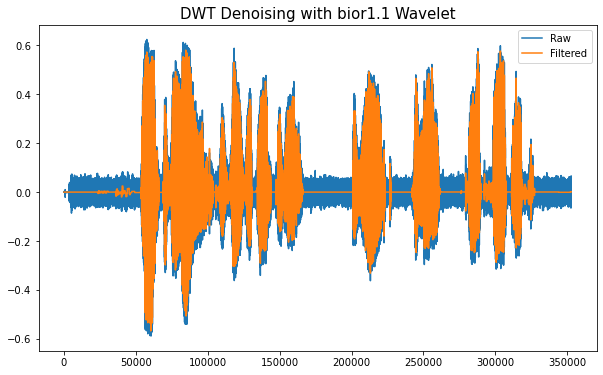

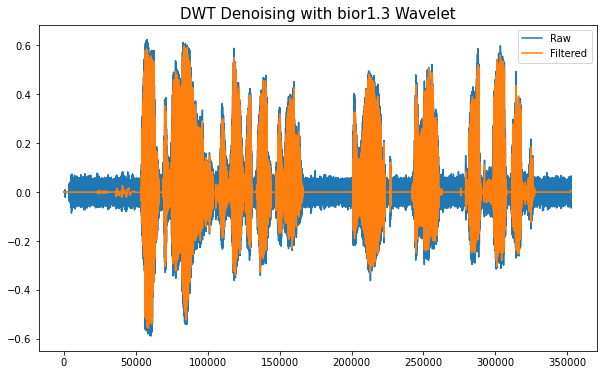

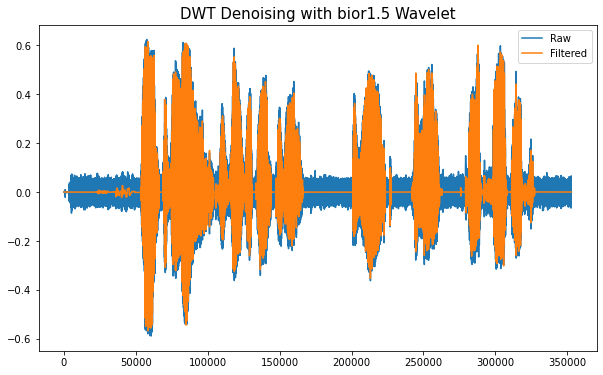

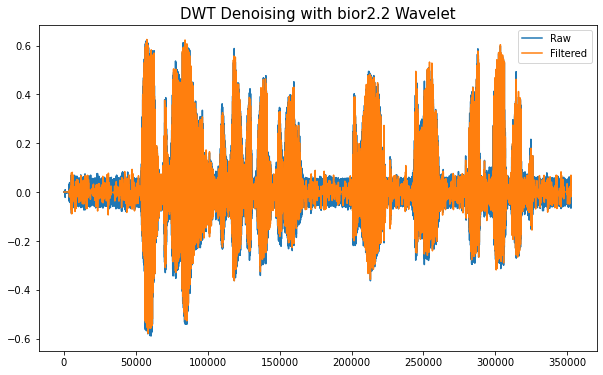

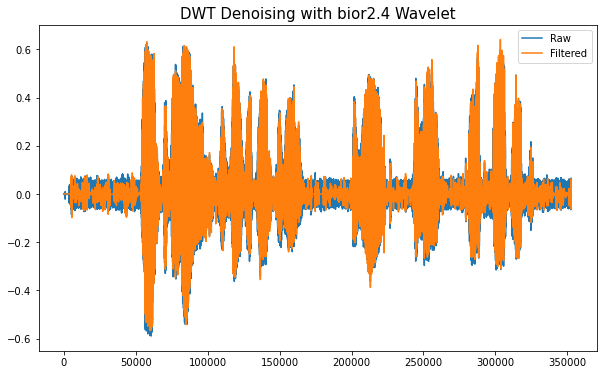

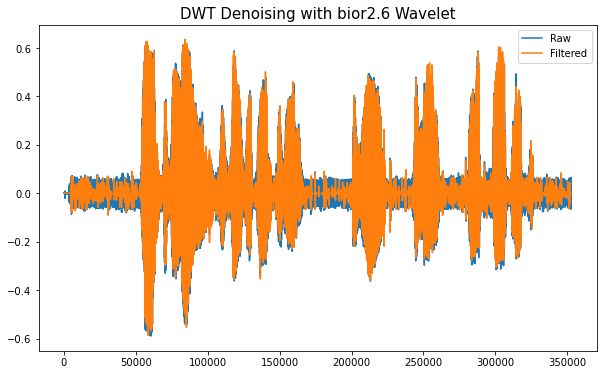

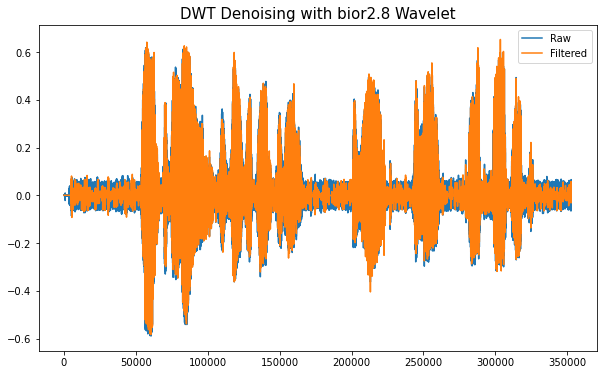

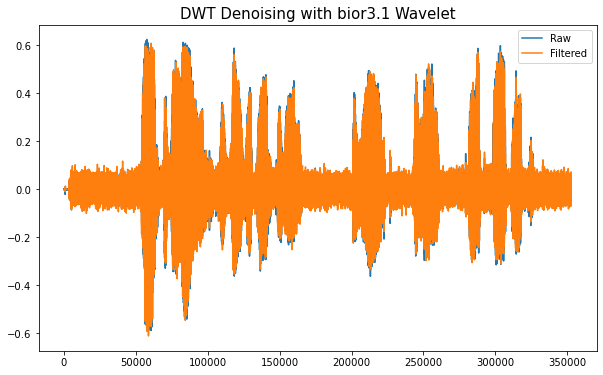

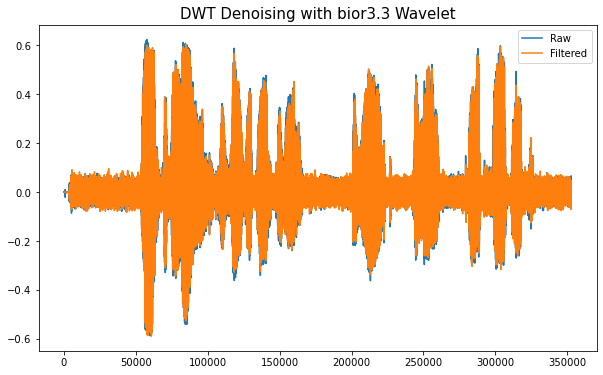

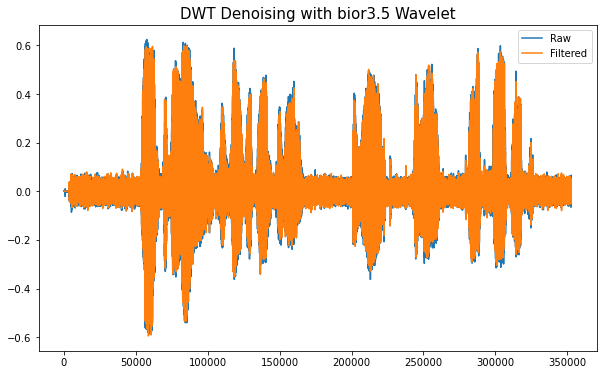

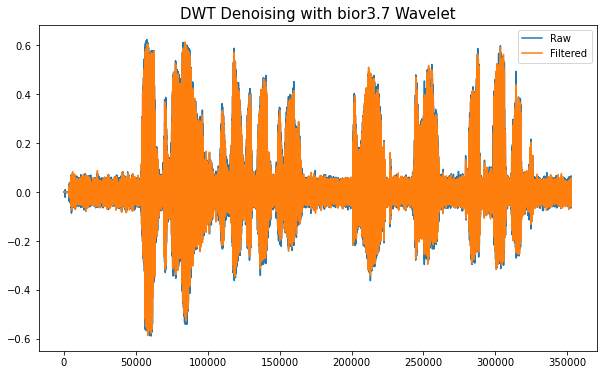

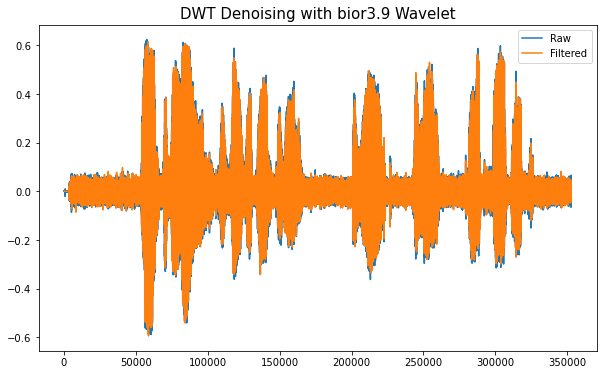

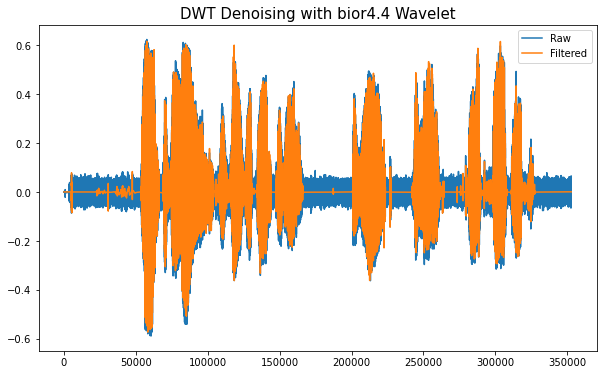

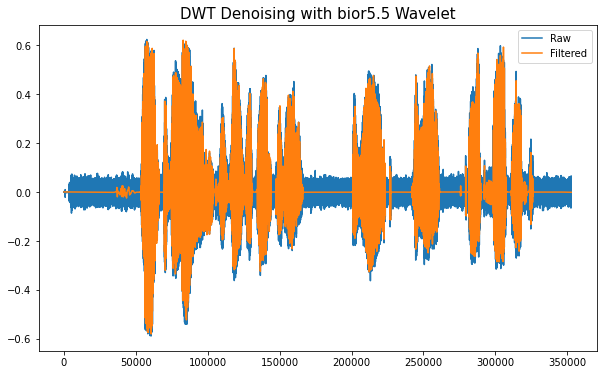

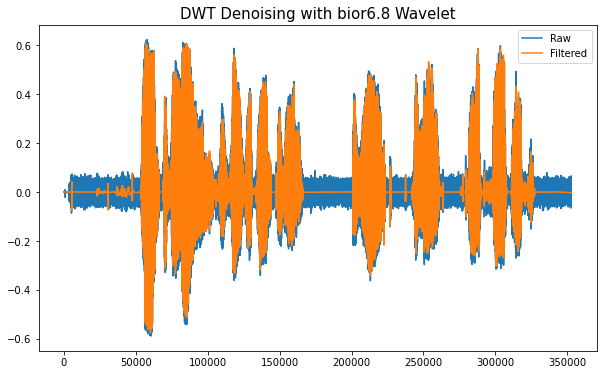

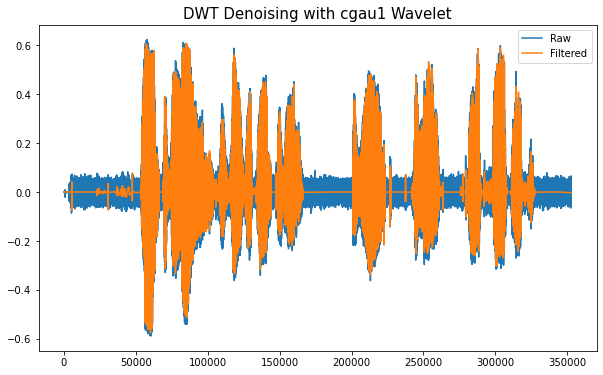

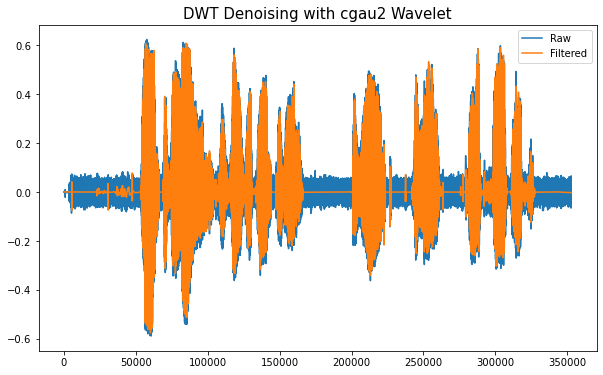

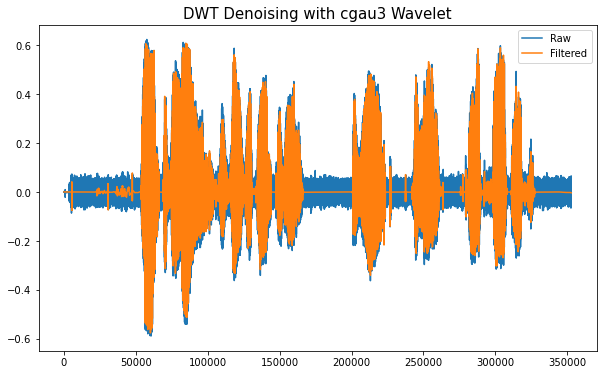

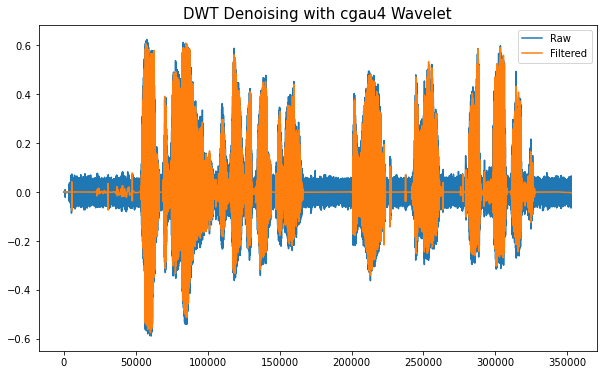

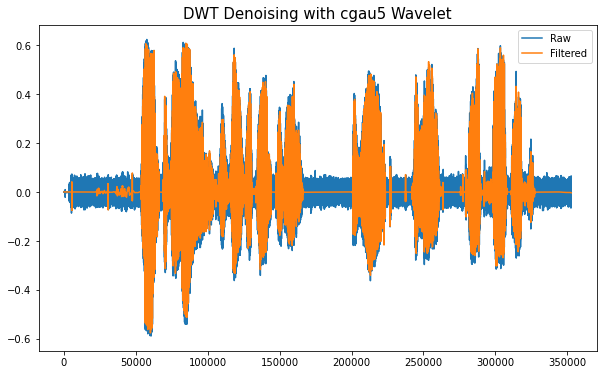

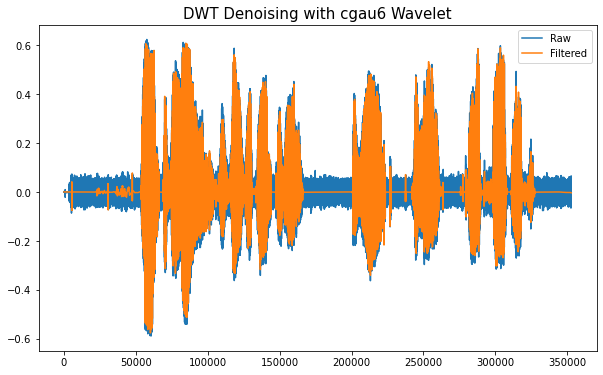

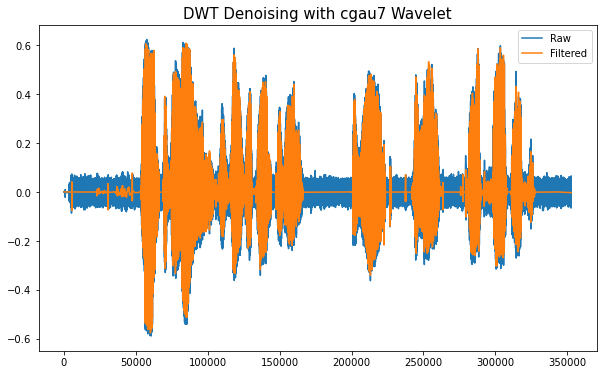

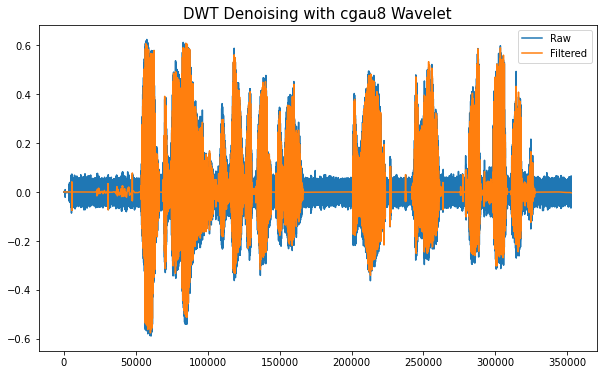

C:\Anaconda\envs\anc\lib\site-packages\pywt\_utils.py:23: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


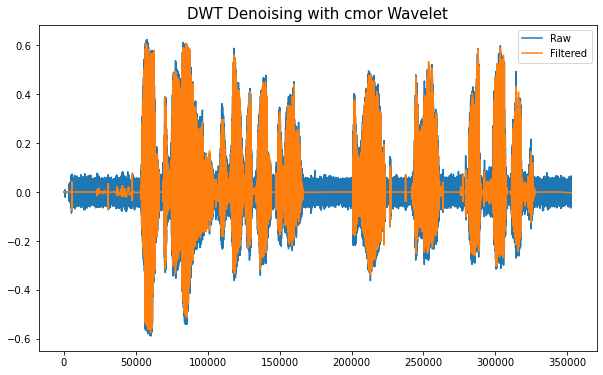

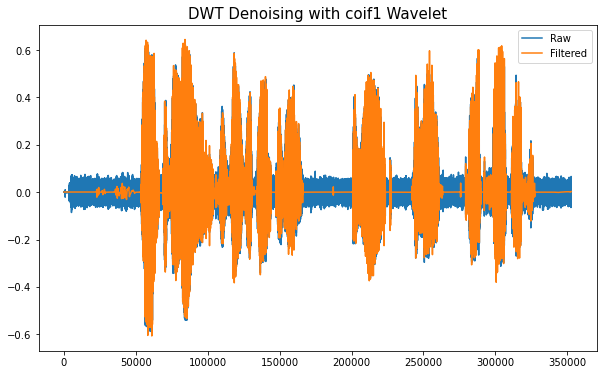

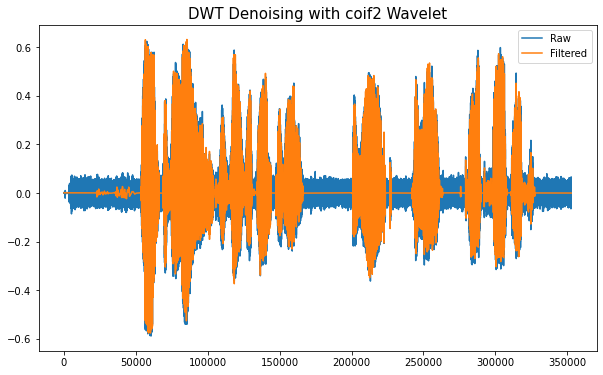

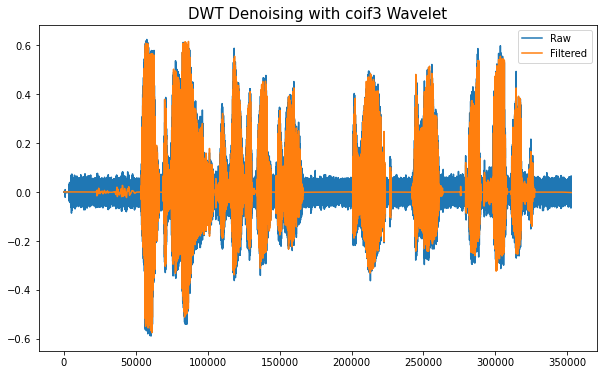

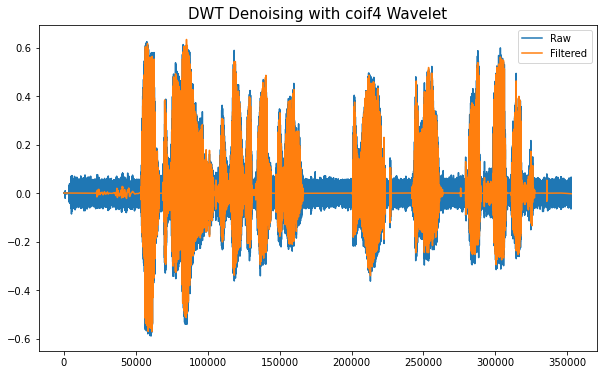

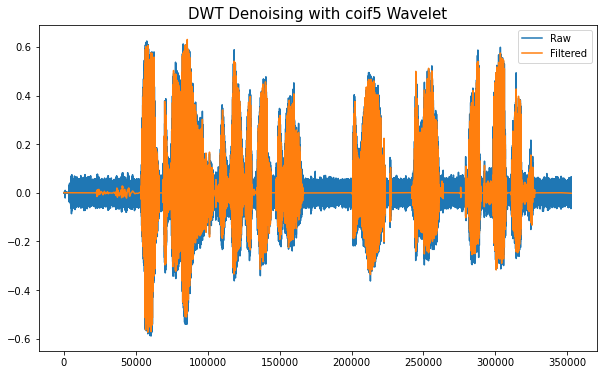

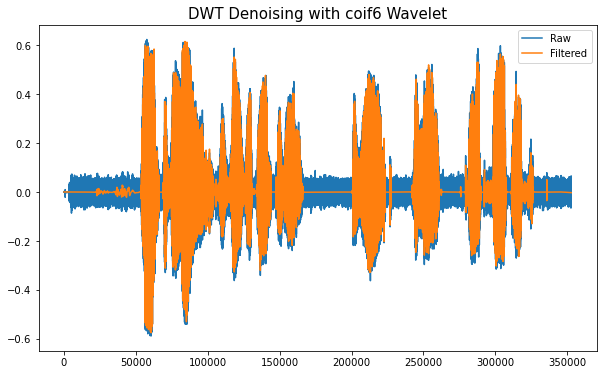

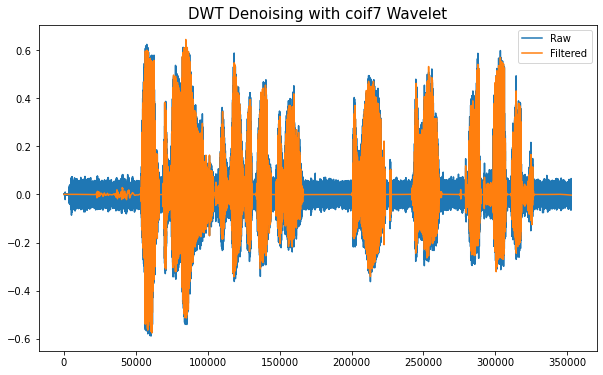

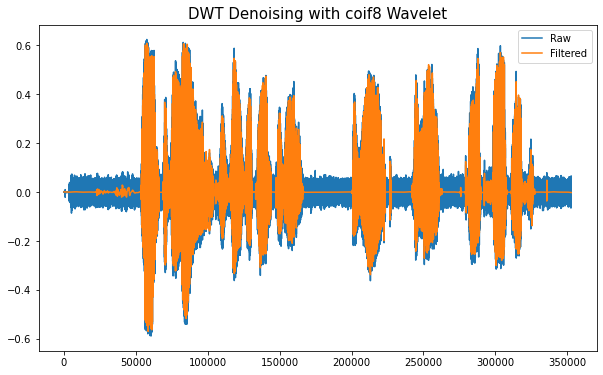

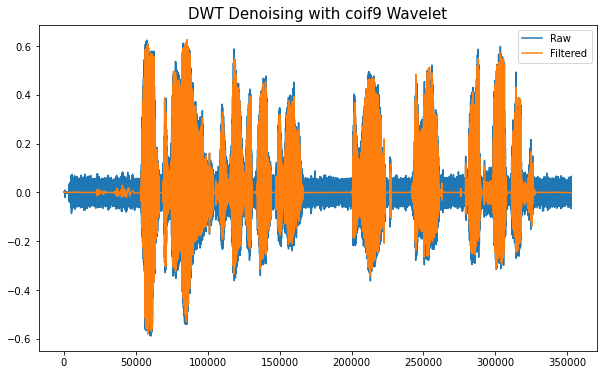

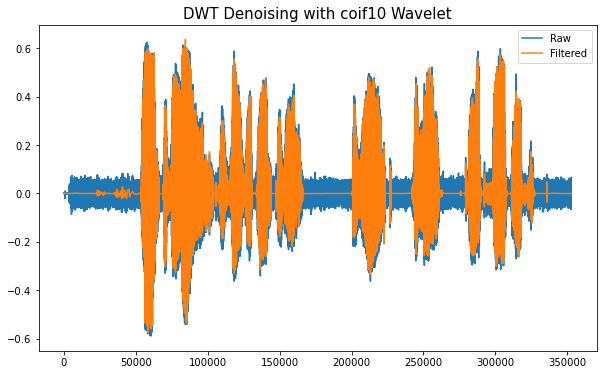

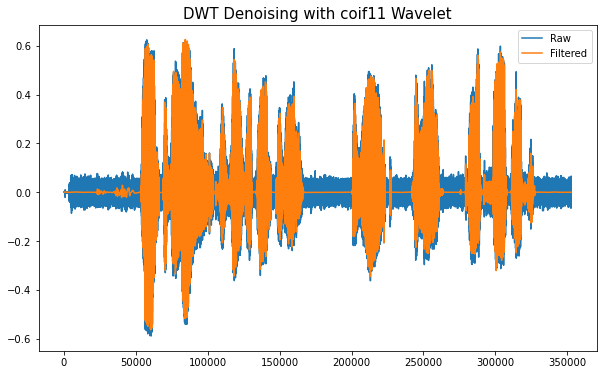

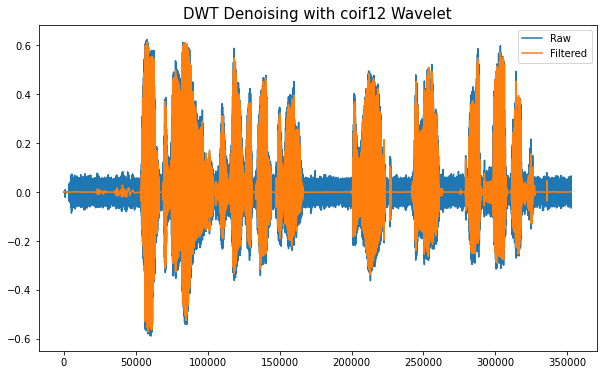

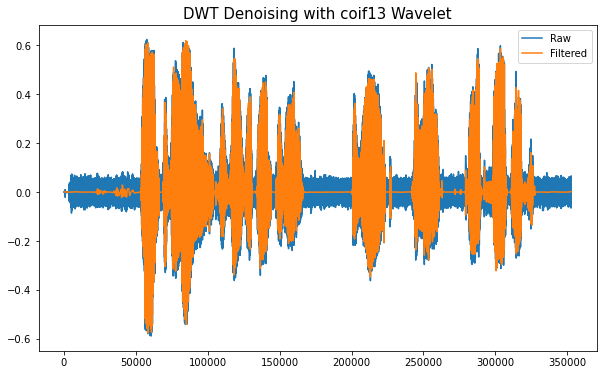

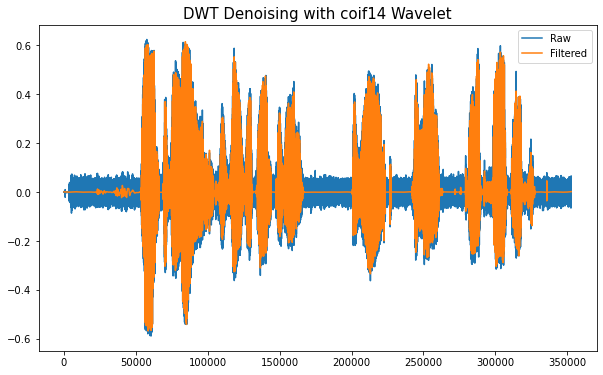

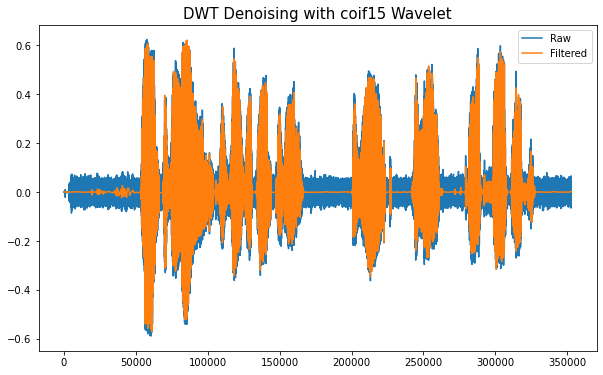

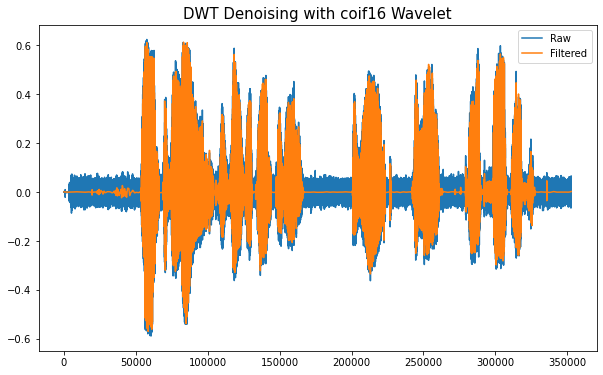

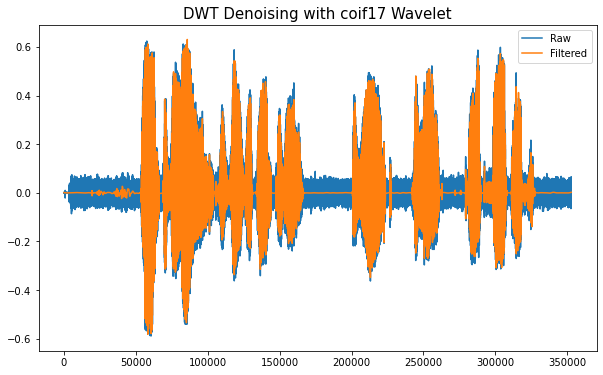

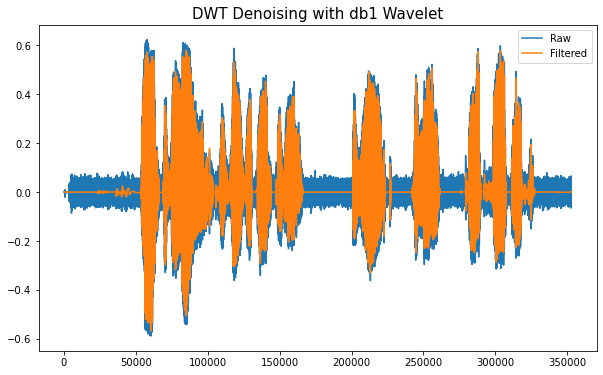

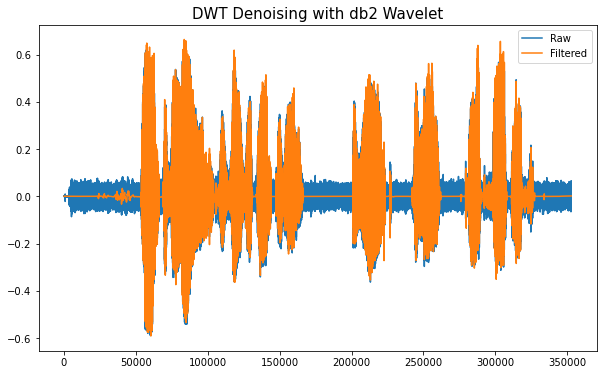

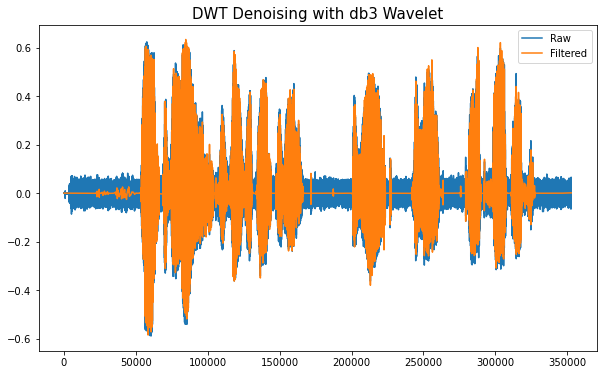

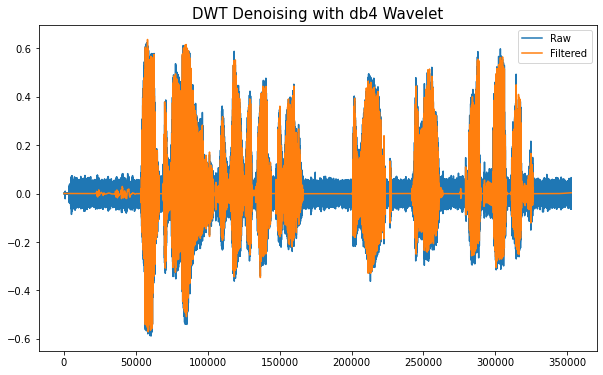

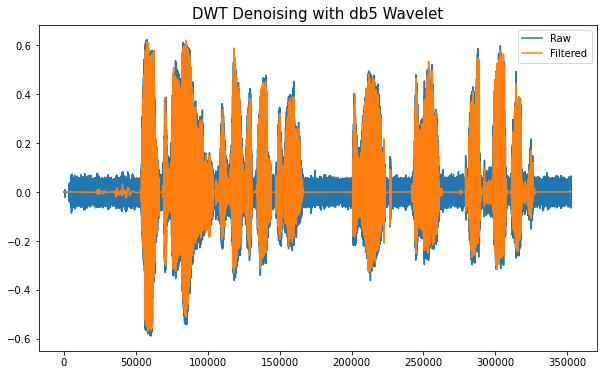

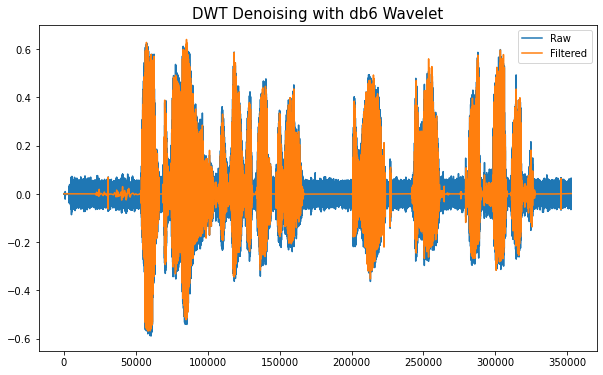

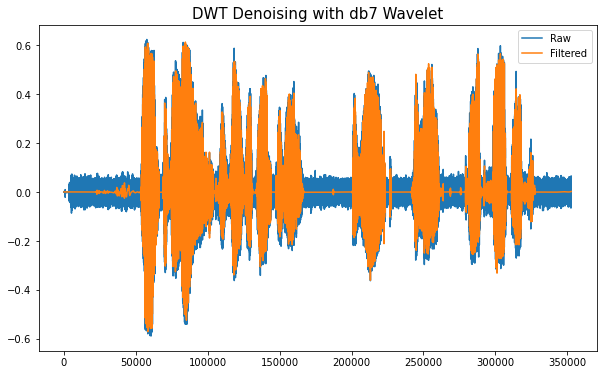

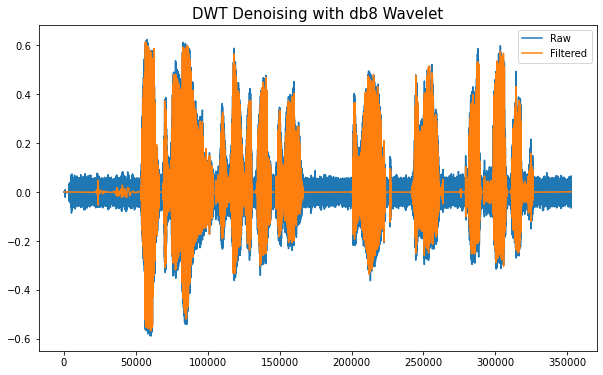

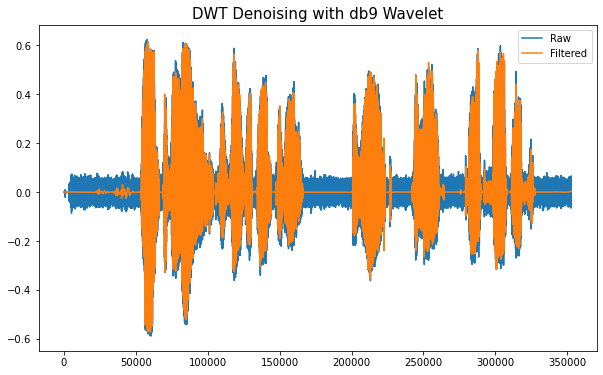

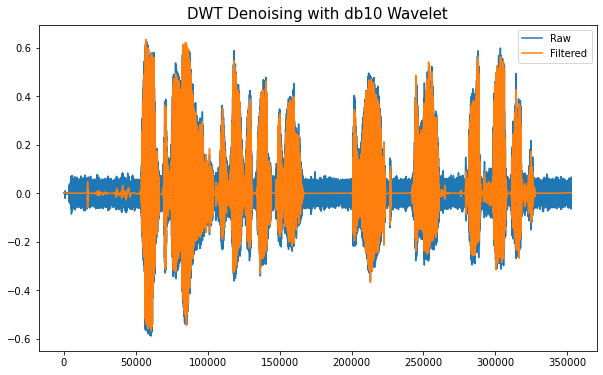

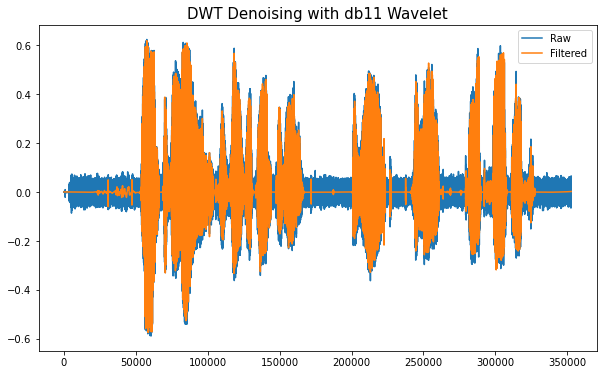

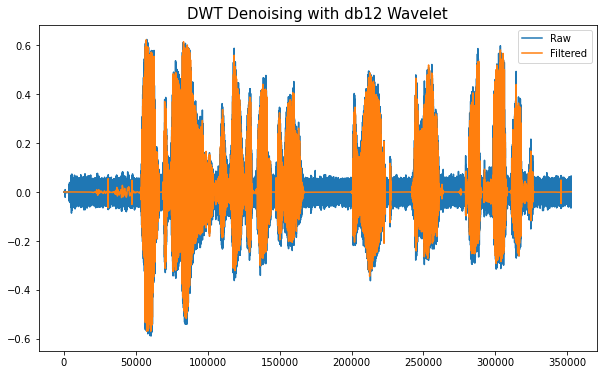

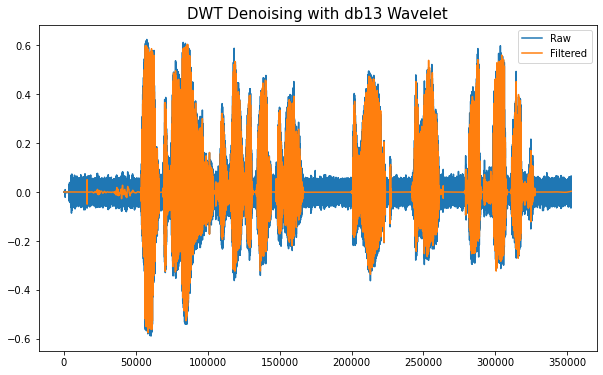

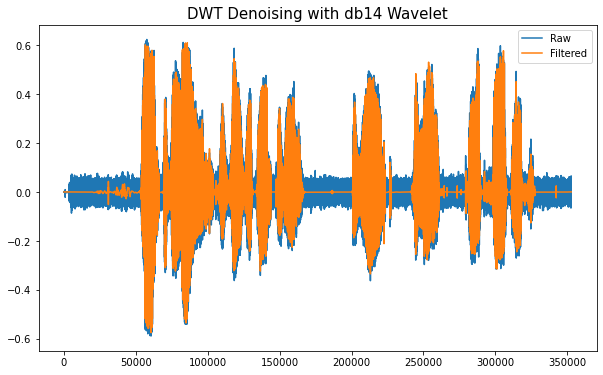

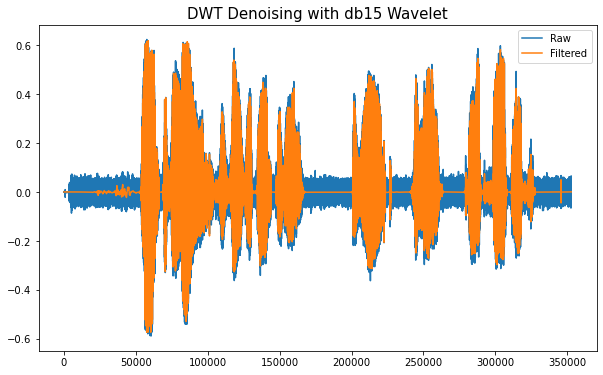

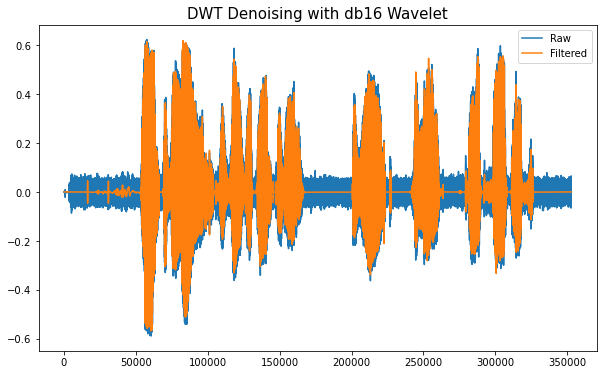

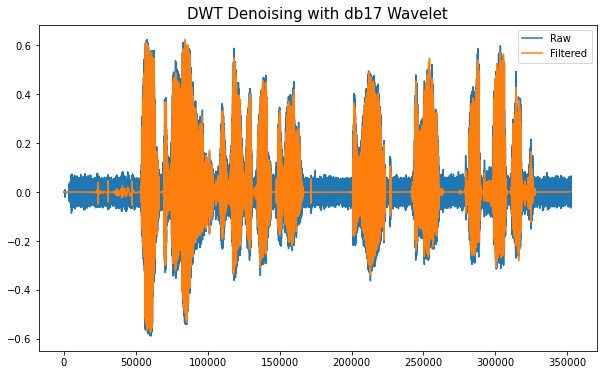

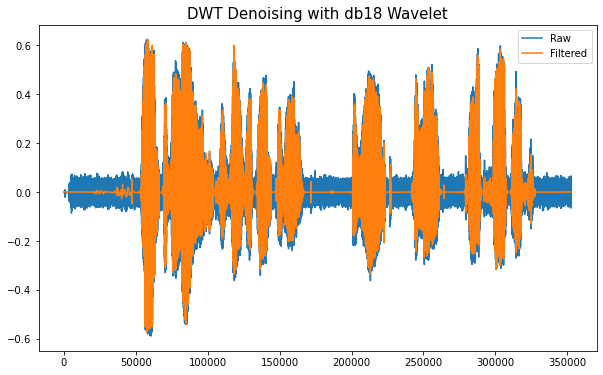

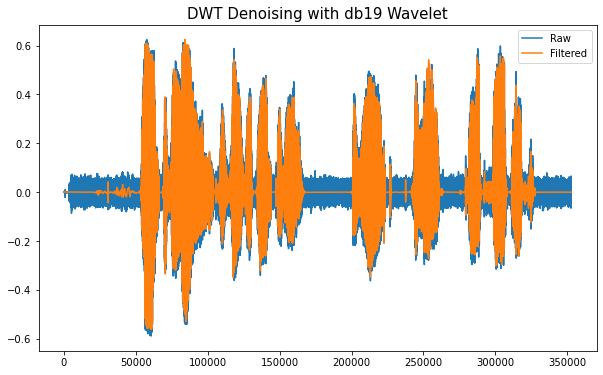

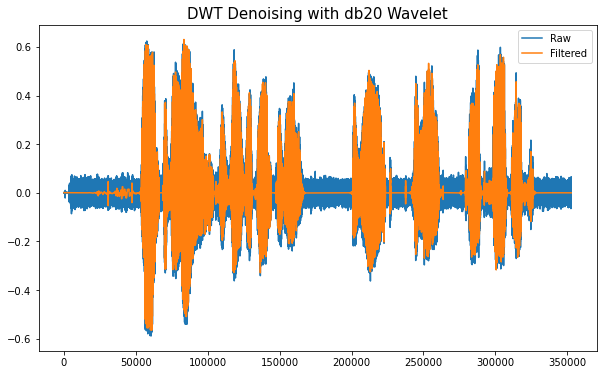

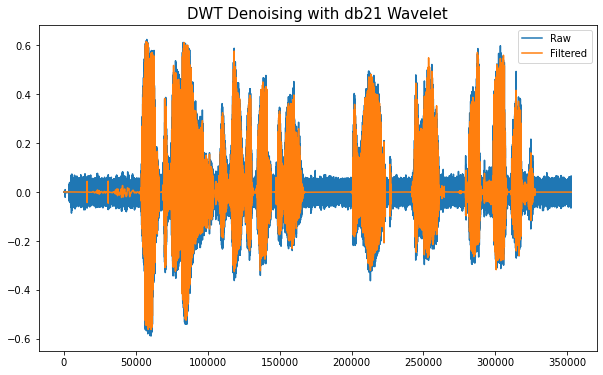

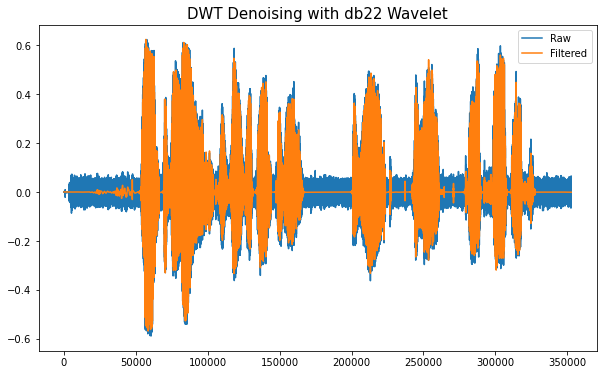

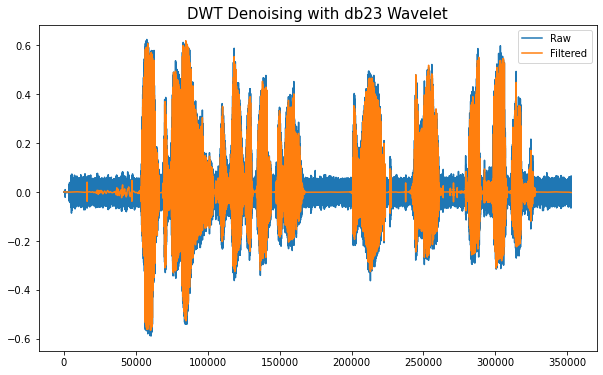

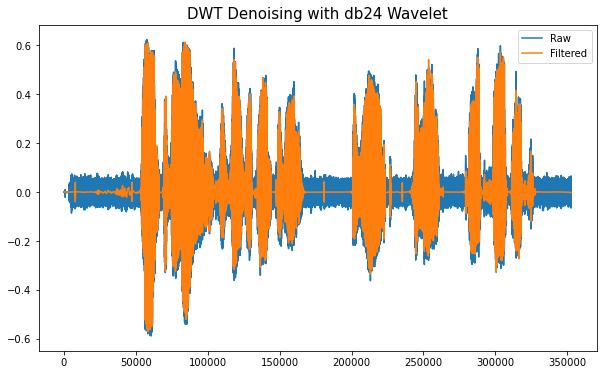

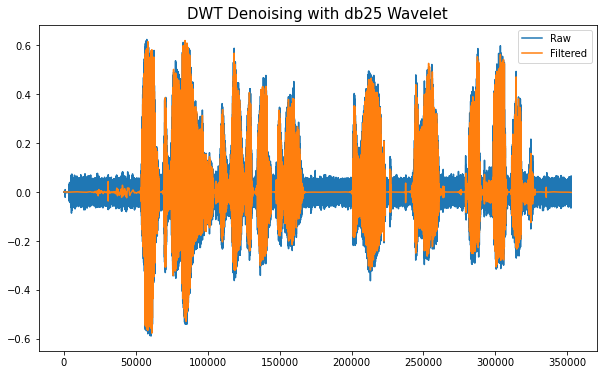

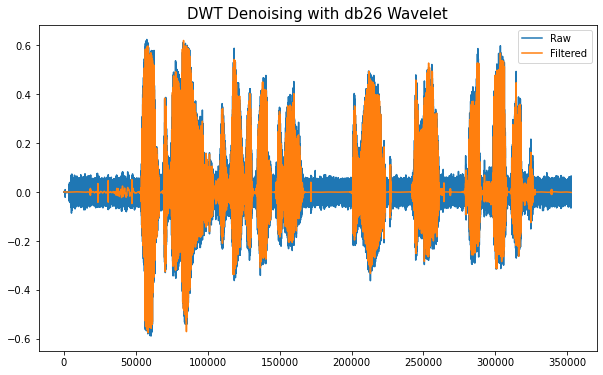

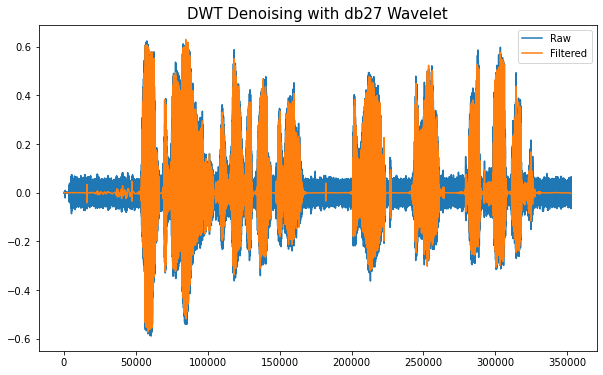

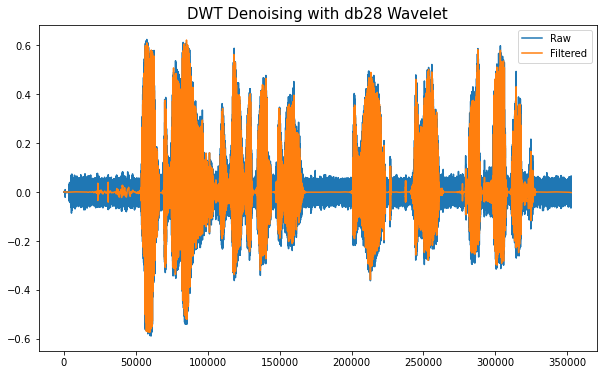

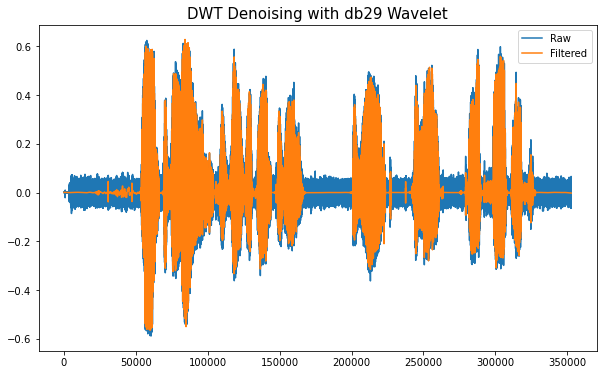

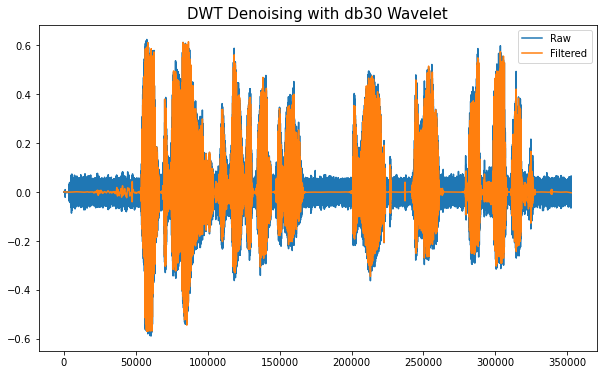

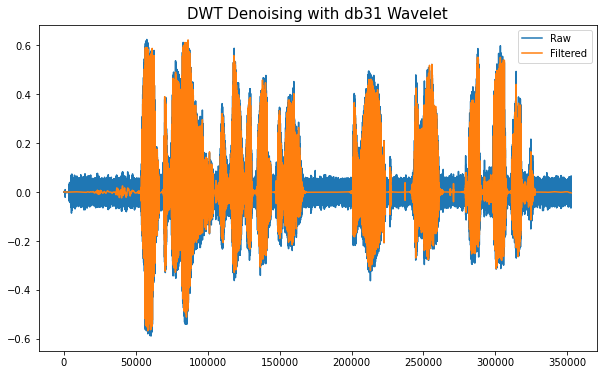

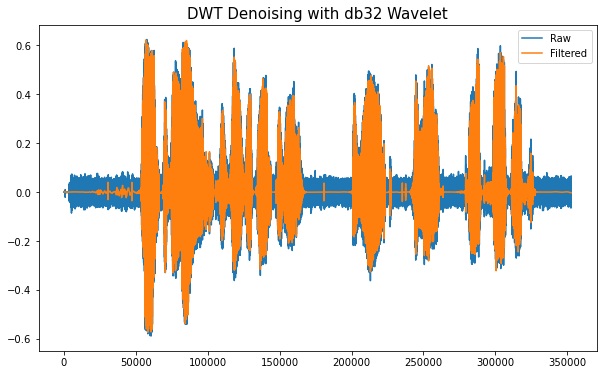

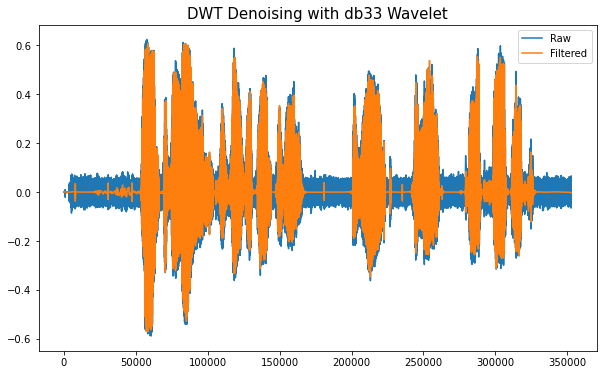

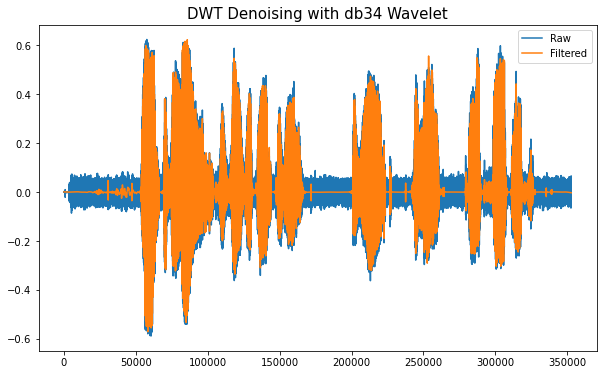

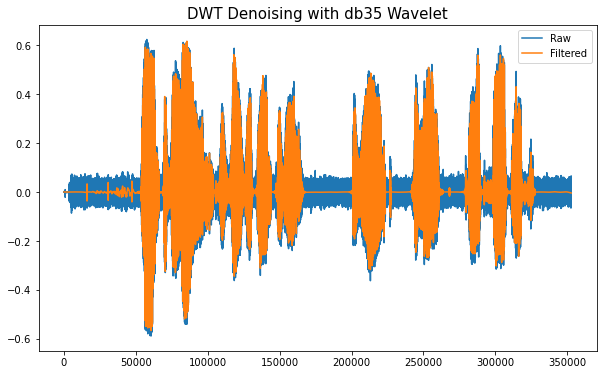

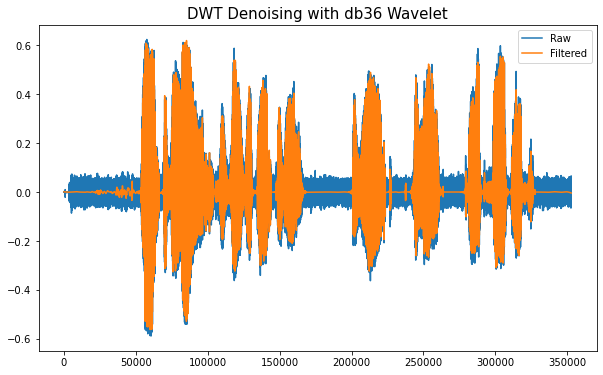

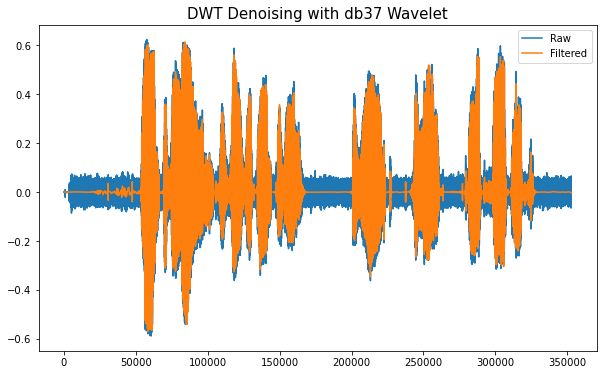

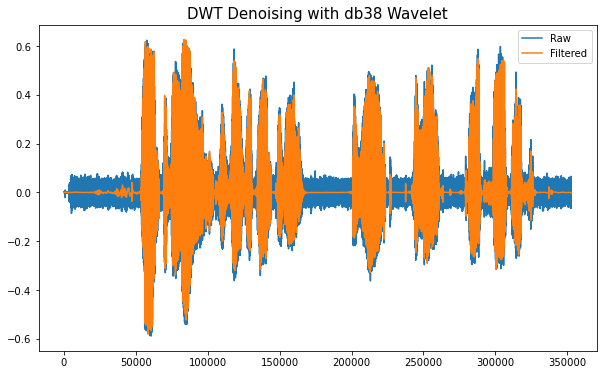

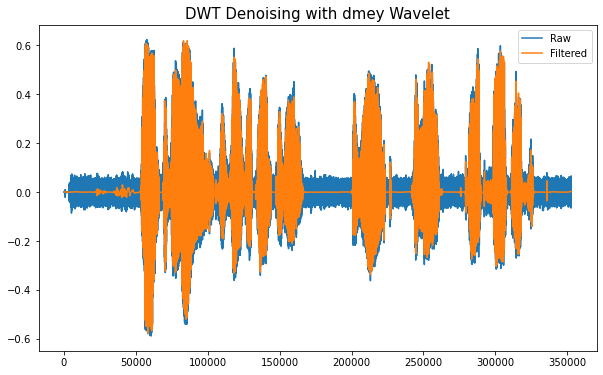

C:\Anaconda\envs\anc\lib\site-packages\pywt\_utils.py:23: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


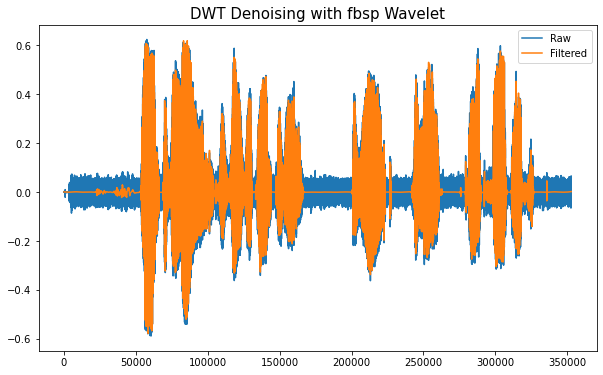

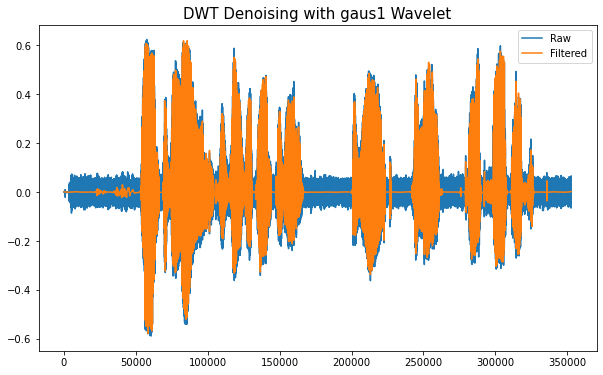

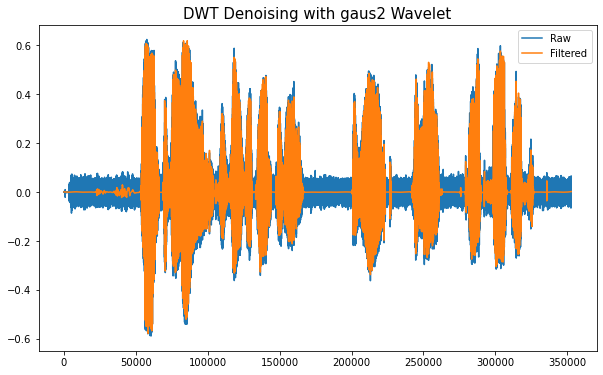

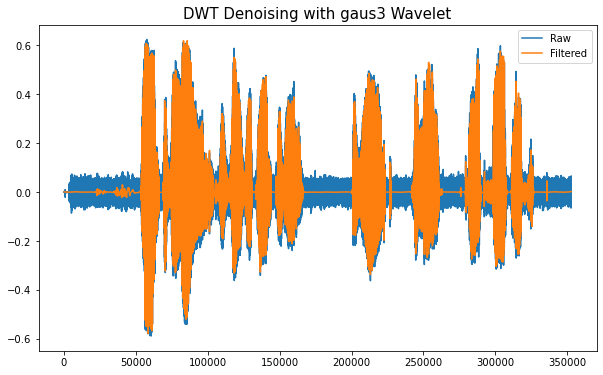

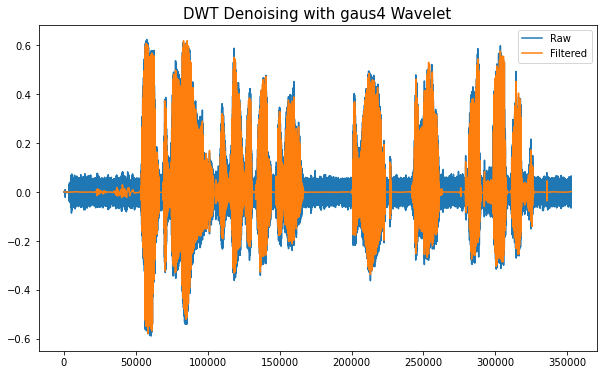

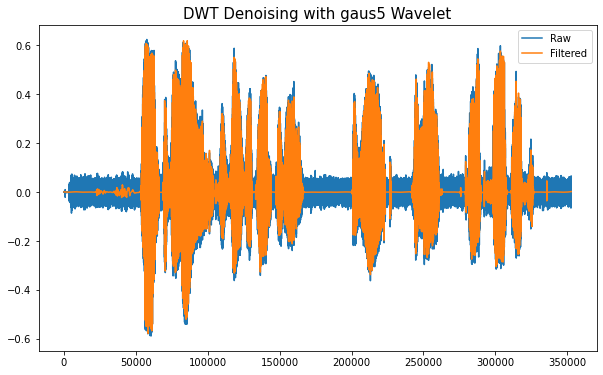

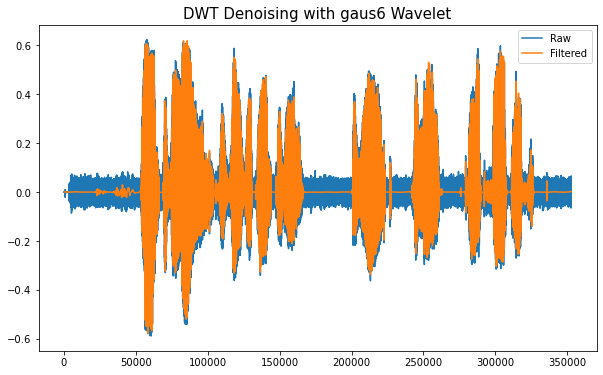

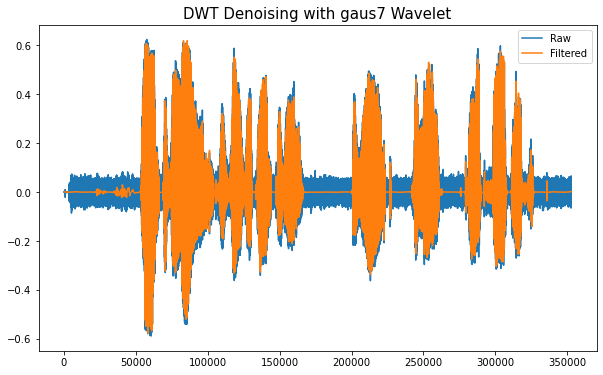

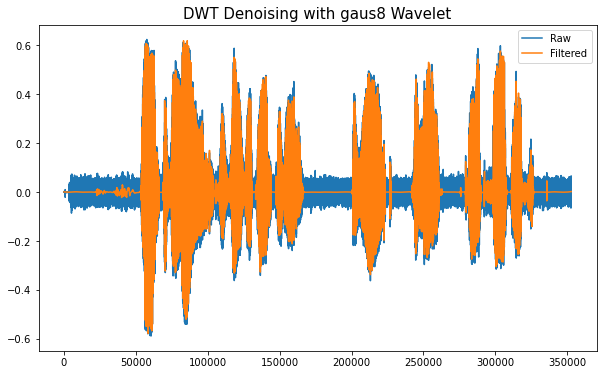

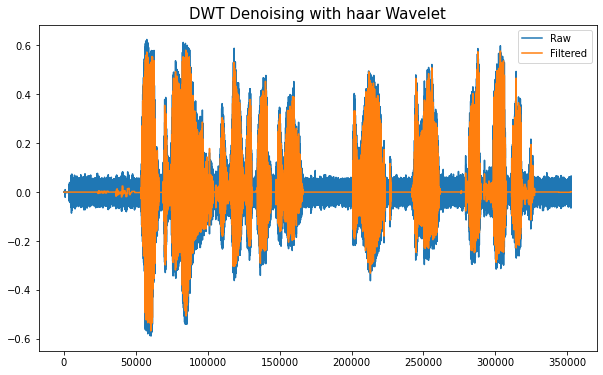

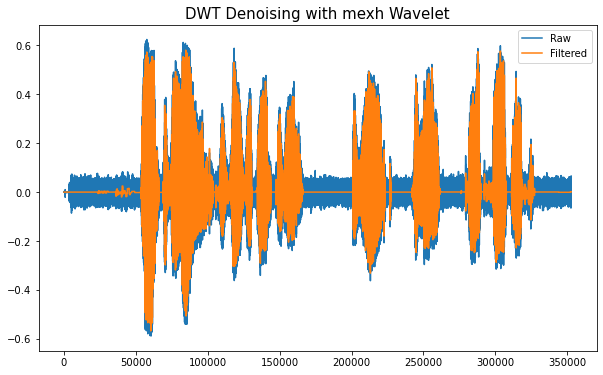

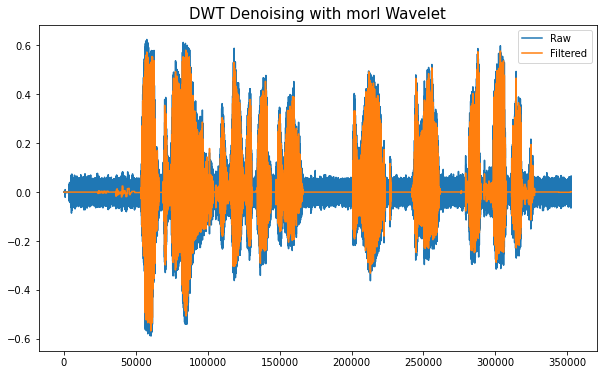

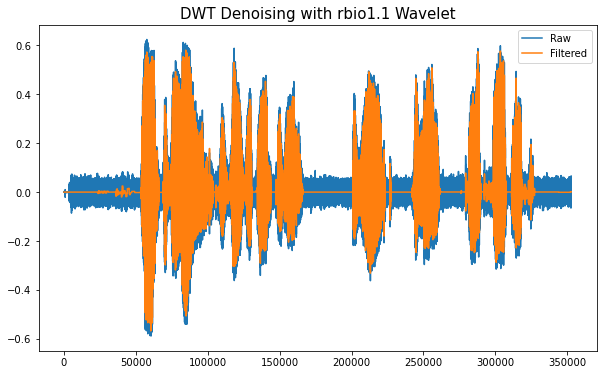

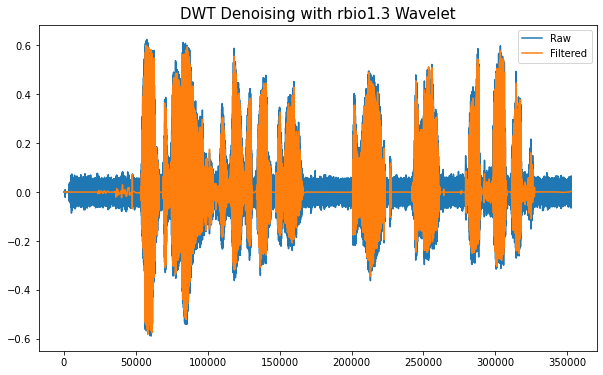

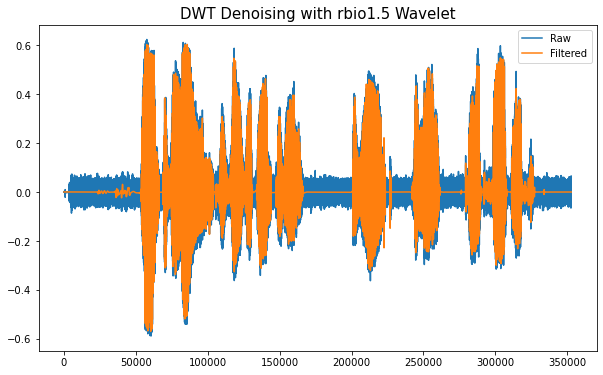

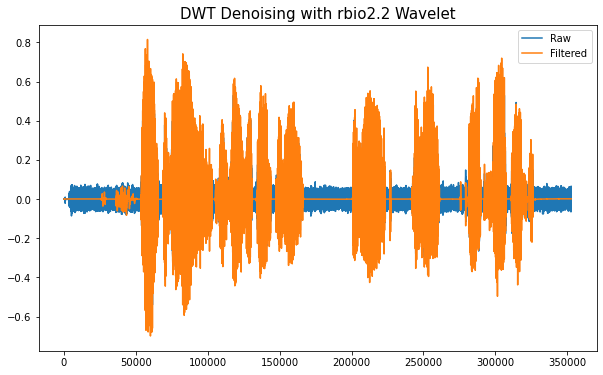

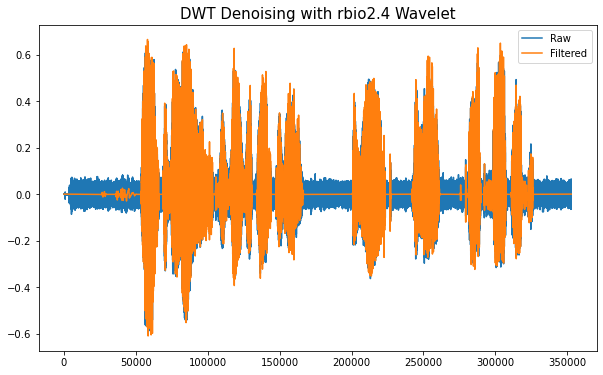

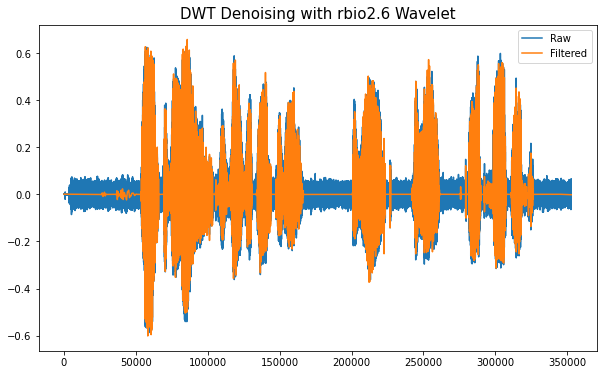

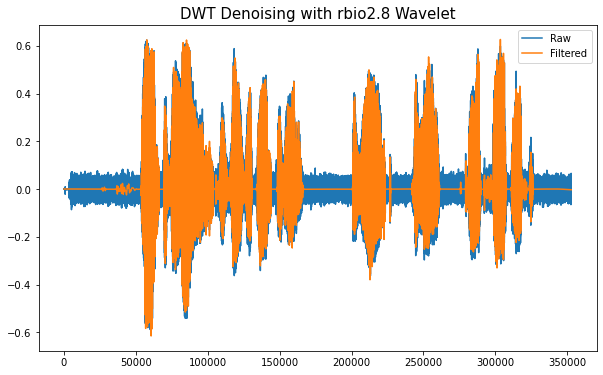

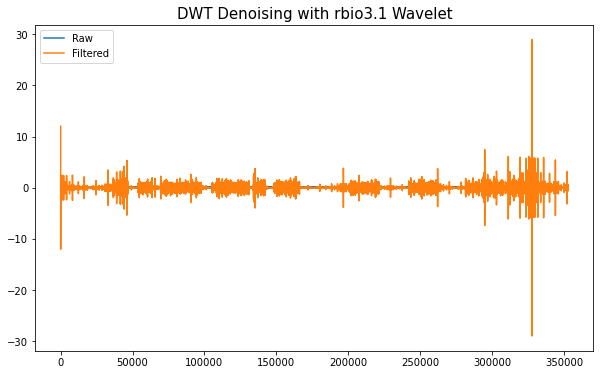

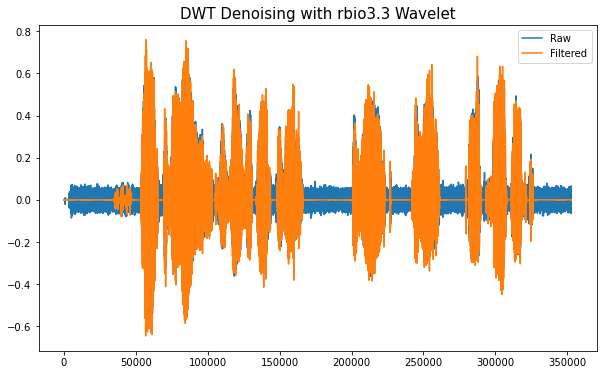

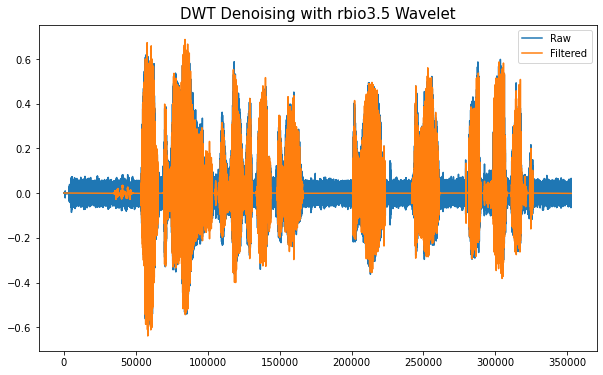

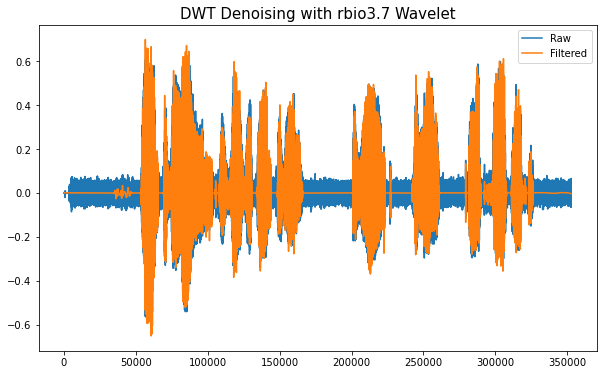

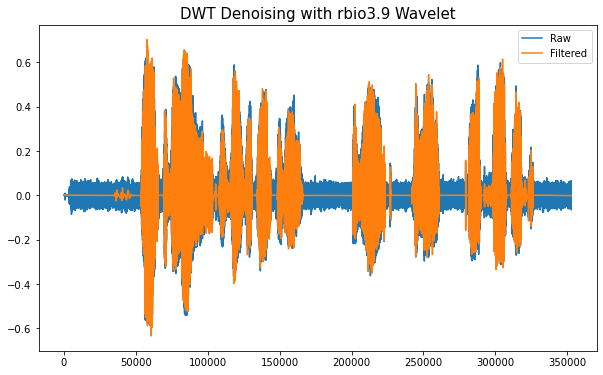

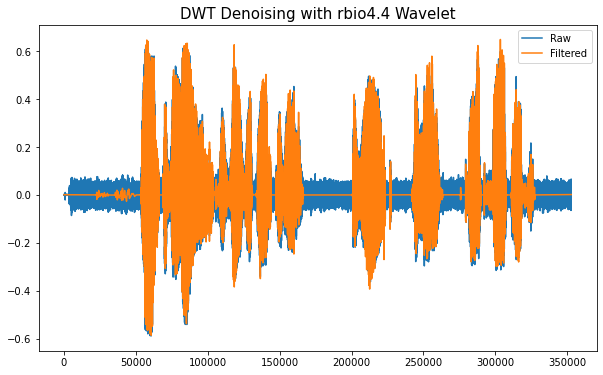

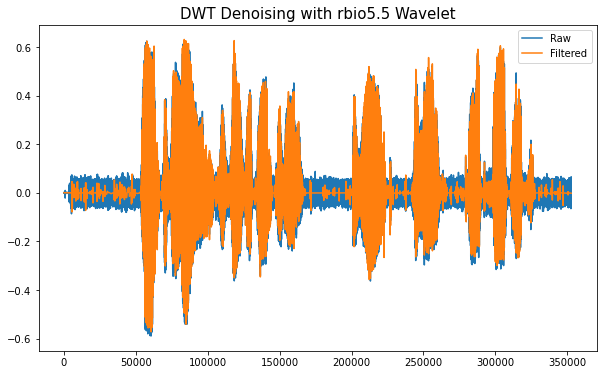

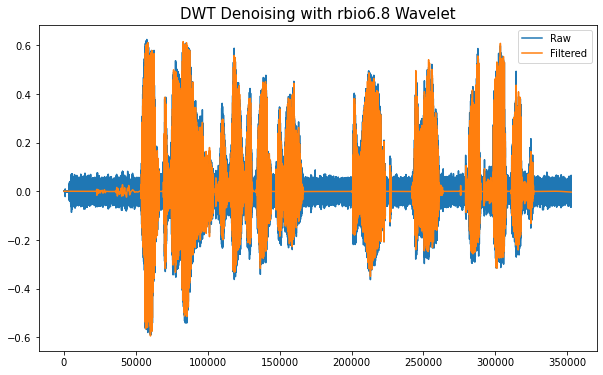

C:\Anaconda\envs\anc\lib\site-packages\pywt\_utils.py:23: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


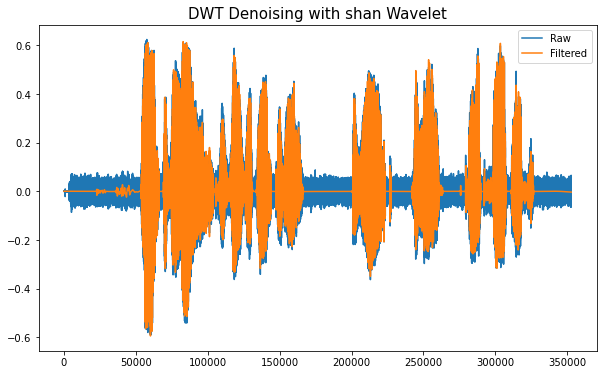

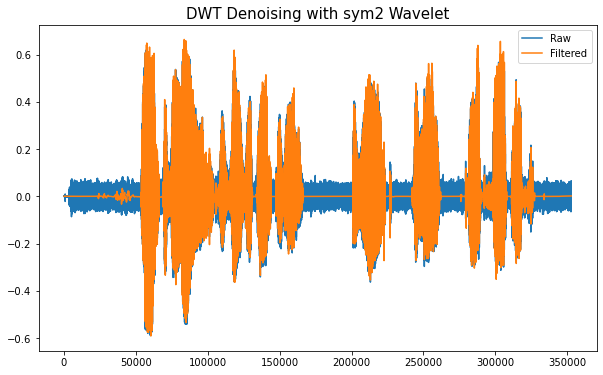

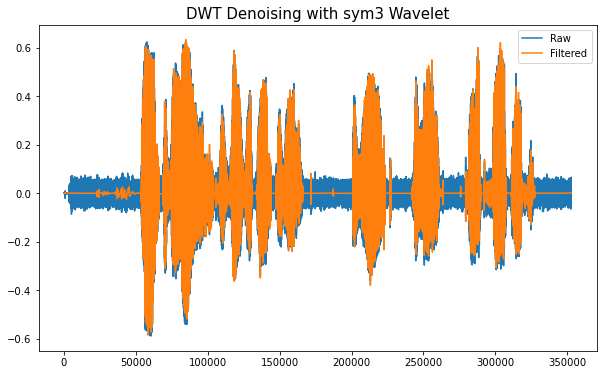

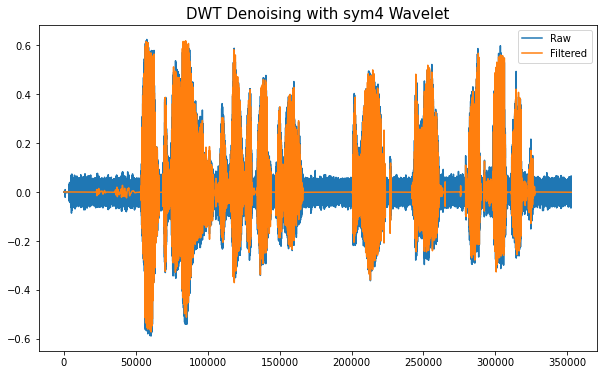

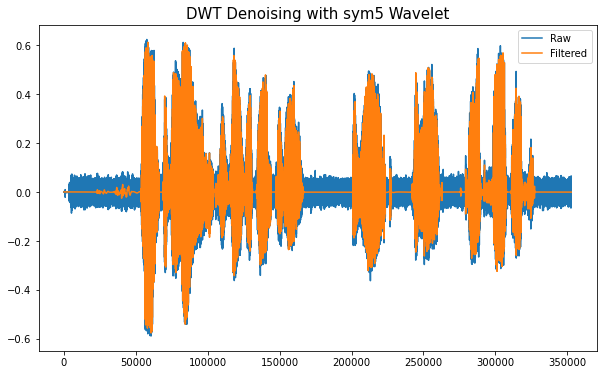

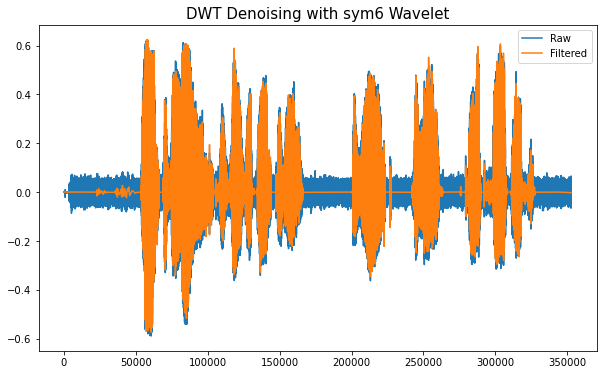

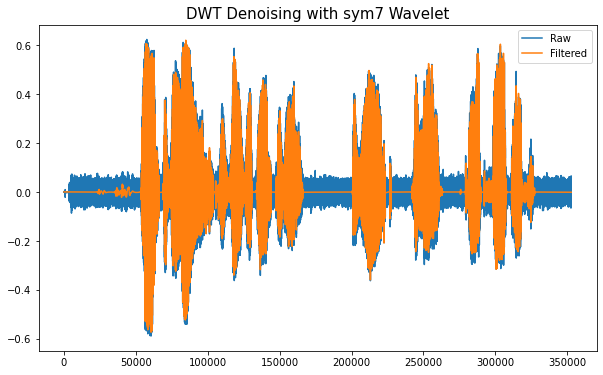

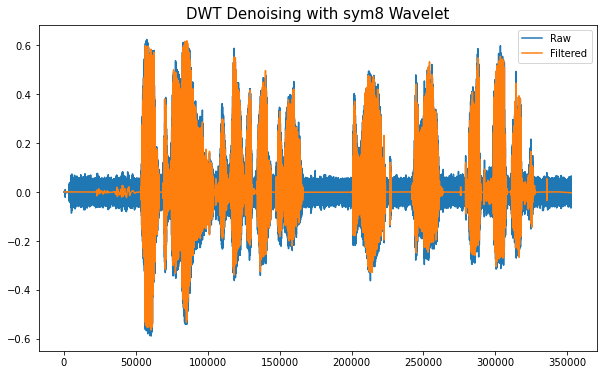

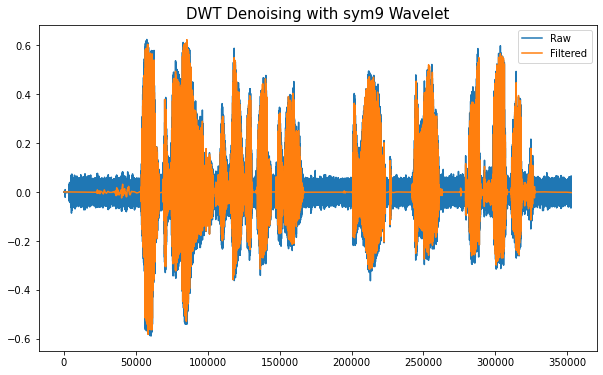

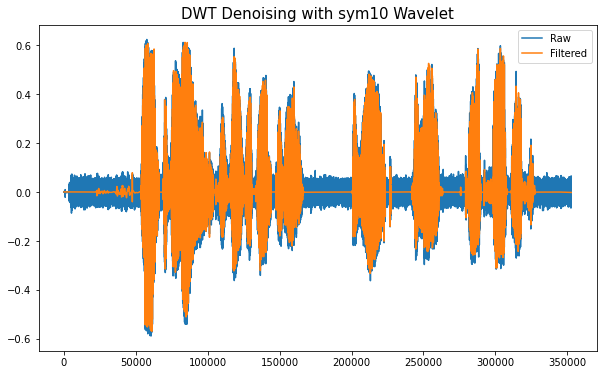

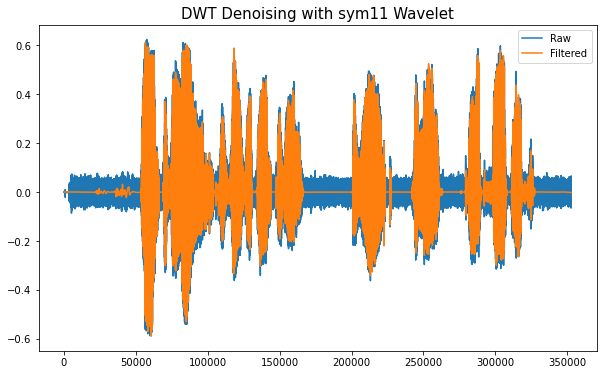

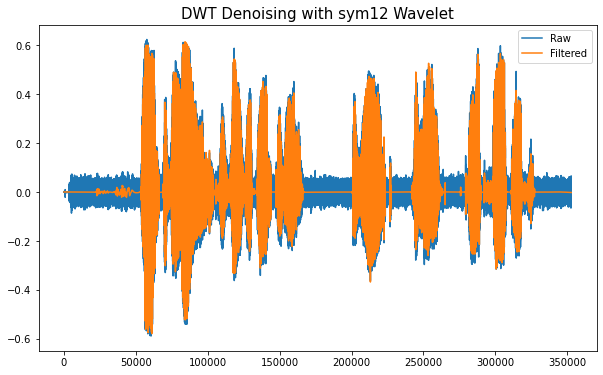

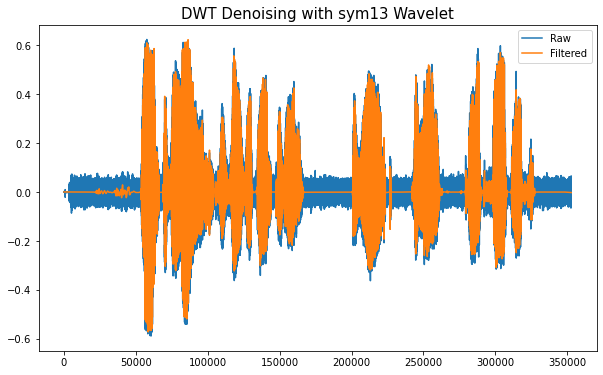

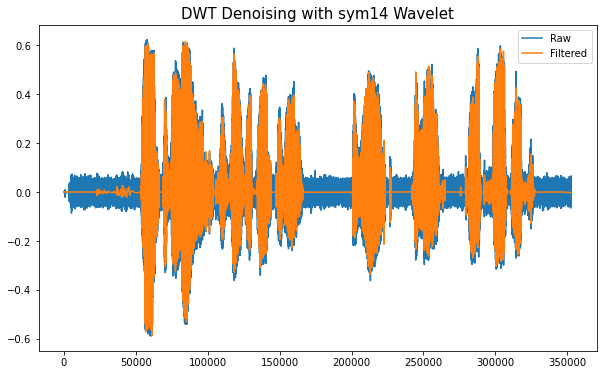

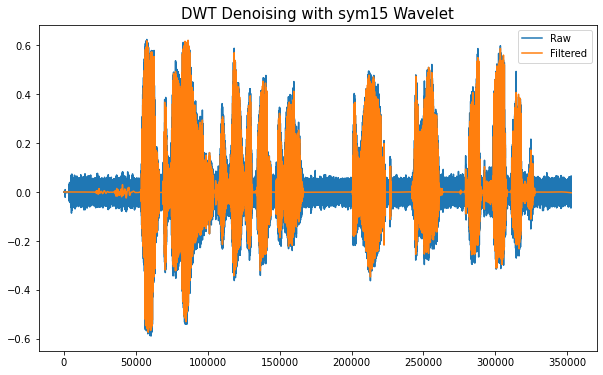

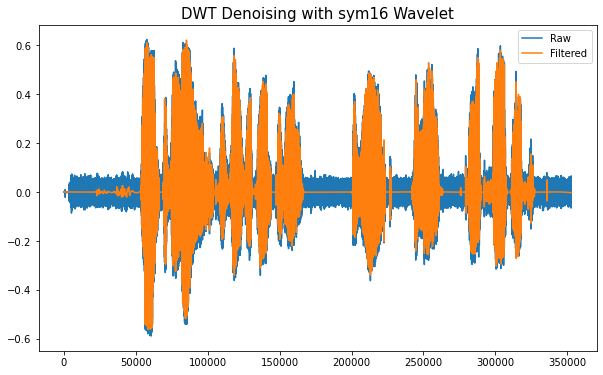

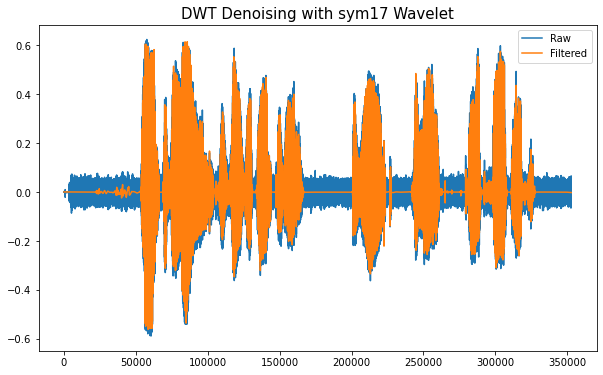

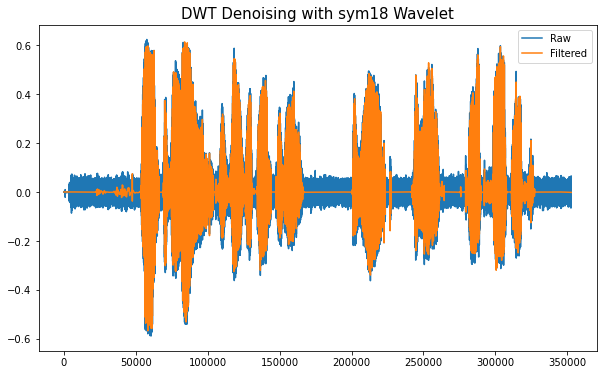

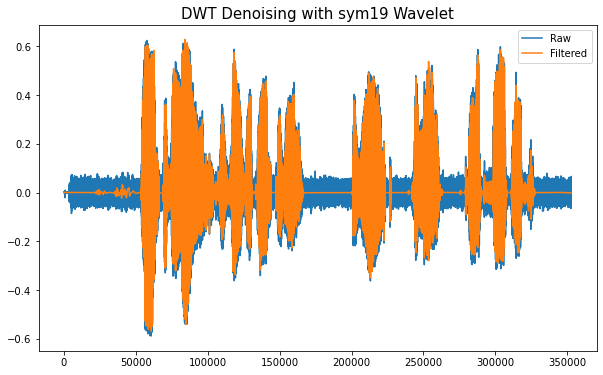

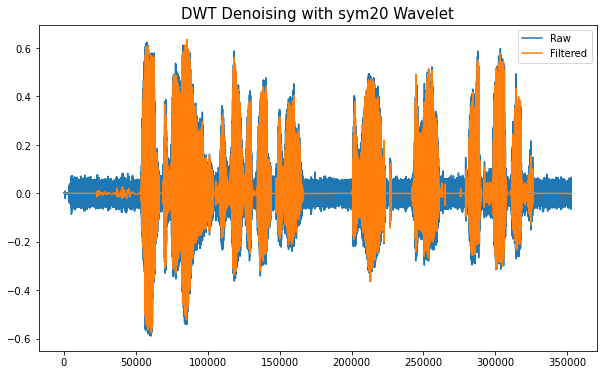

In [54]:
for wav in pywt.wavelist():
    try:
        filtered = wavelet_denoising(d_s_wn, wavelet=wav, mode=mode, level=1)
    except:
        pass
    
    plt.figure(figsize=(10, 6))
    plt.plot(d_s_wn, label='Raw')
    plt.plot(filtered, label='Filtered')
    plt.legend()
    plt.title(f"DWT Denoising with {wav} Wavelet", size=15)
    plt.show()

# Speech + White Noise $d_{s+wn}$

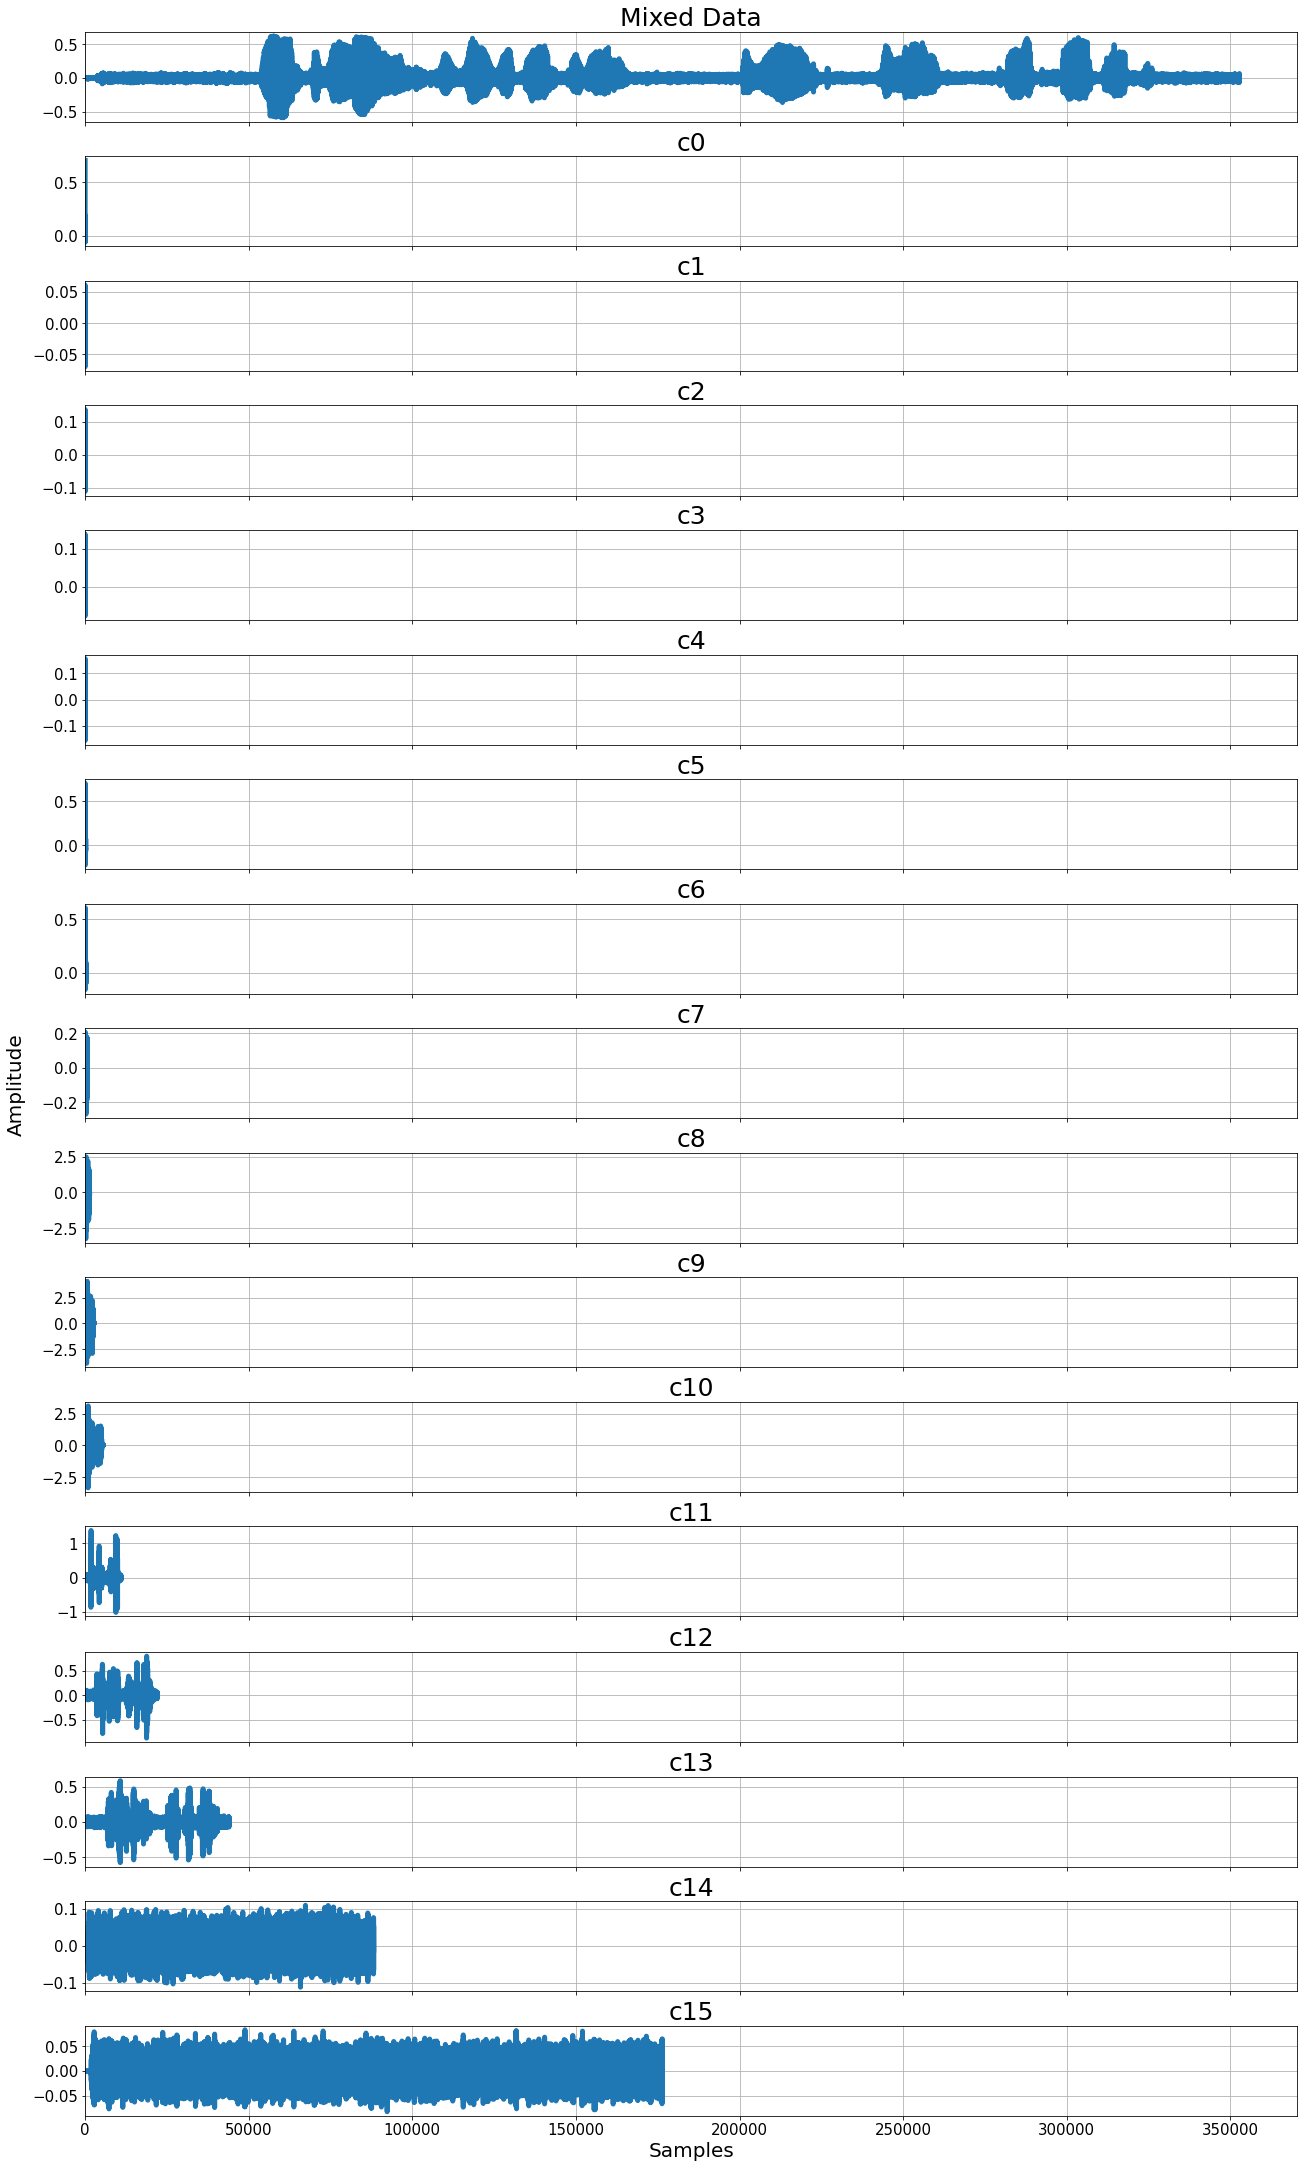

In [34]:
coeff_dswn = calc_wavelet(d_s_wn, wavelet, mode)
plot_wavelet(coeff_dswn, d_s_wn)

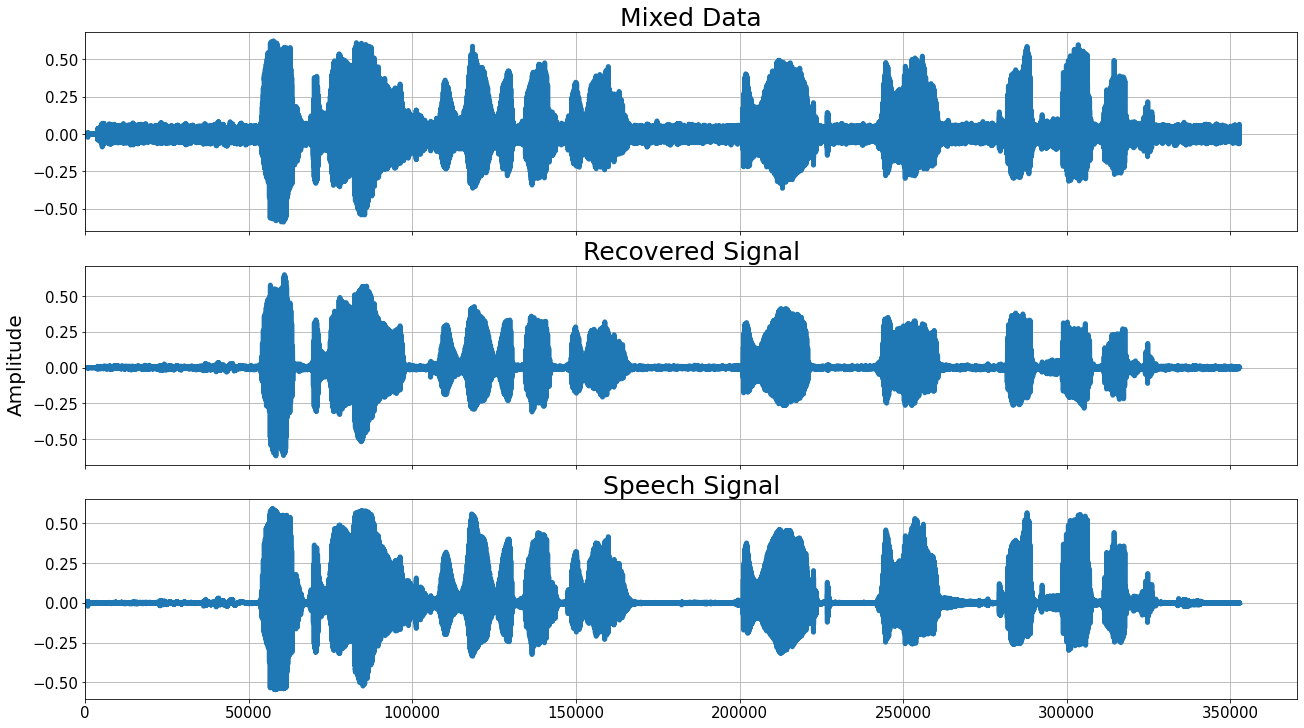

In [35]:
recov_dswn = recover_wavelet(coeff_dswn, 0, 5)

fig, axs = plt.subplots(3, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[0].plot(d_s_wn, lw=5)
axs[0].set_title('Mixed Data', fontsize=25)

axs[1].plot(recov_dswn, lw=5)
axs[1].set_title('Recovered Signal', fontsize=25)

axs[2].plot(audio_files[0], lw=5)
axs[2].set_title('Speech Signal', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

# Street Noise + Music $d_{sn+m}$

In [36]:
coeff_dsnm = calc_wavelet(d_sn_m, wavelet, mode)

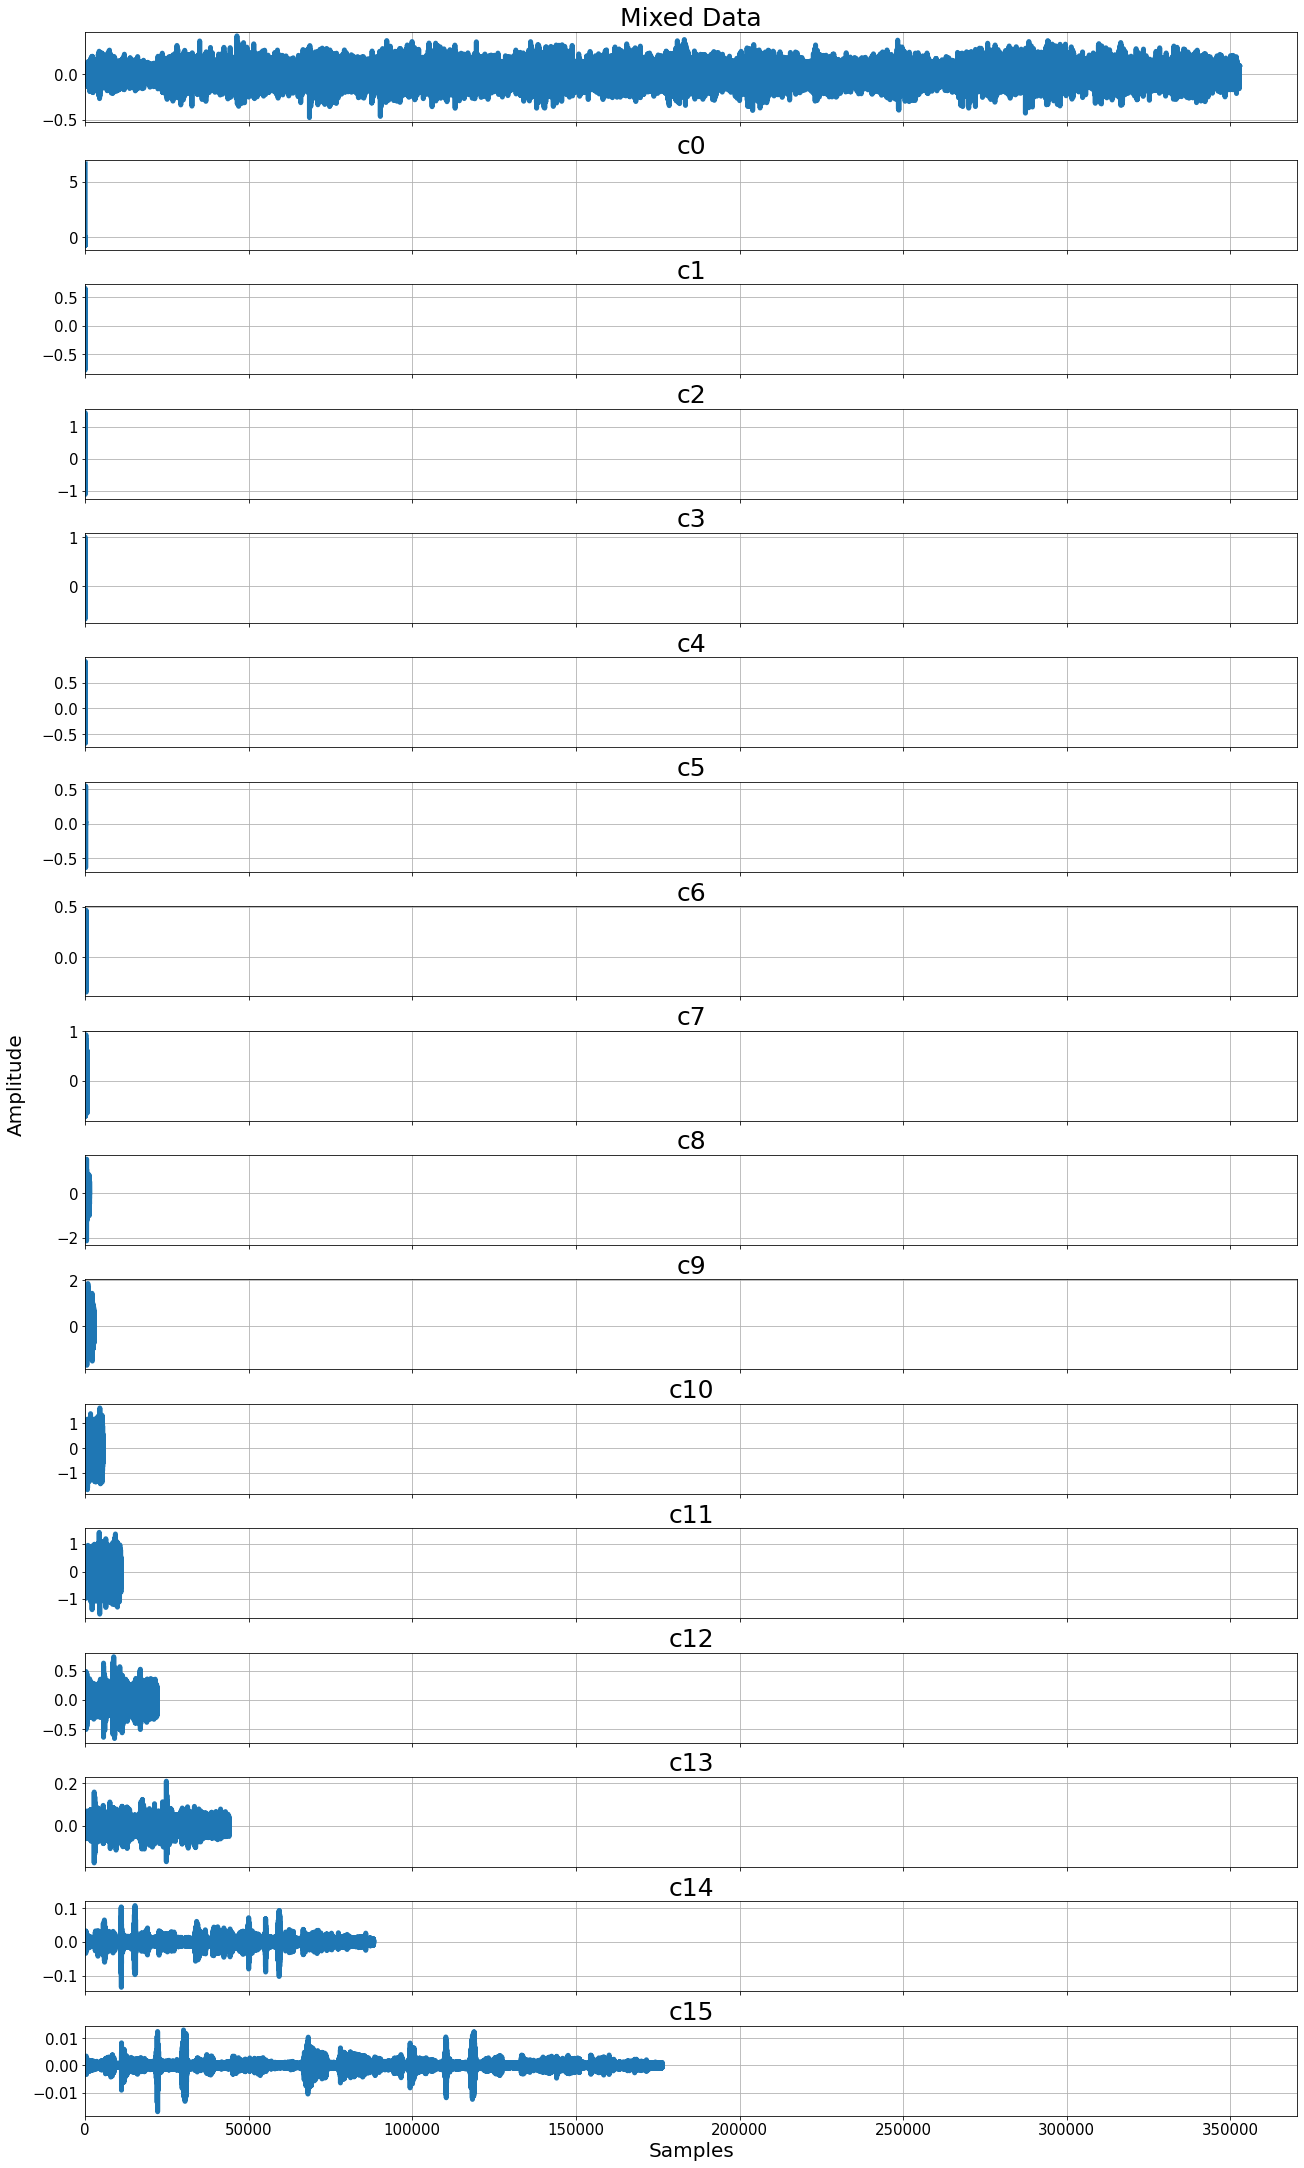

In [37]:
plot_wavelet(coeff_dsnm, d_sn_m)

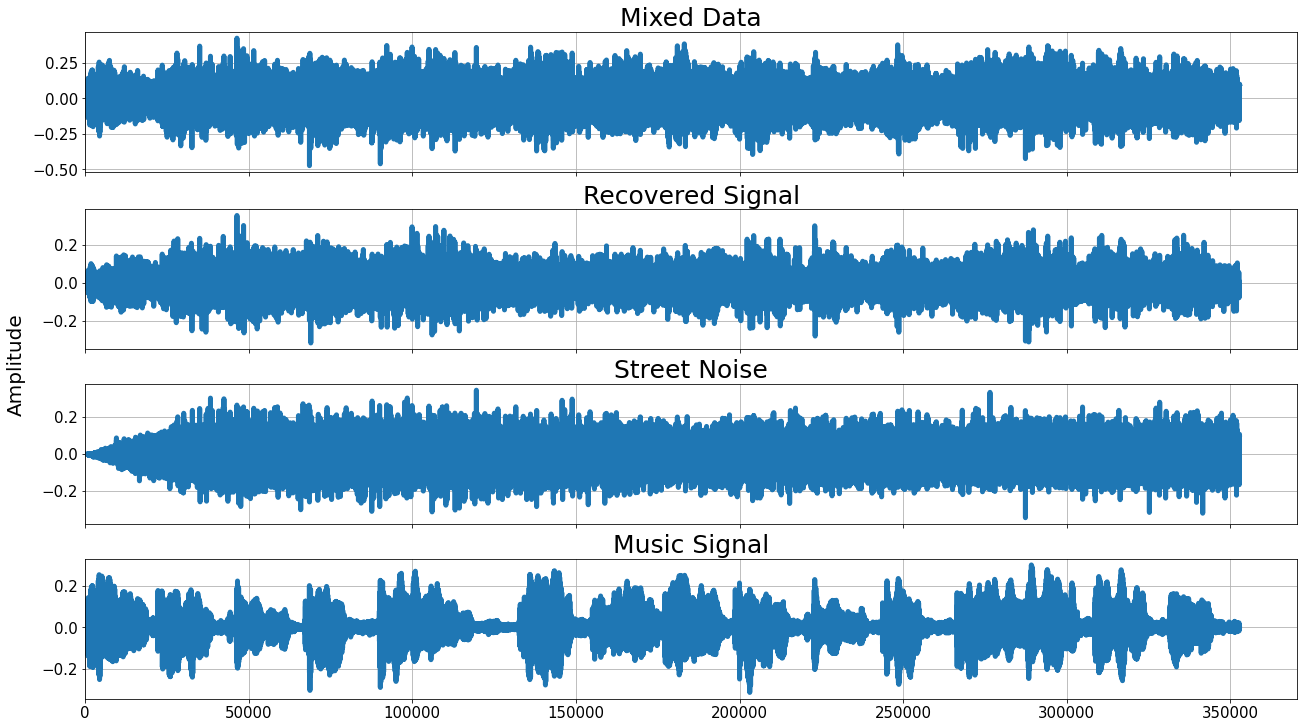

In [38]:
recov_dsnm = recover_wavelet(coeff_dsnm, 0, 5)

fig, axs = plt.subplots(4, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[0].plot(d_sn_m, lw=5)
axs[0].set_title('Mixed Data', fontsize=25)

axs[1].plot(recov_dsnm, lw=5)
axs[1].set_title('Recovered Signal', fontsize=25)

axs[2].plot(audio_files[1], lw=5)
axs[2].set_title('Street Noise', fontsize=25)

axs[3].plot(audio_files[2], lw=5)
axs[3].set_title('Music Signal', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

# Music + White Noise $d_{m+wn}$

In [39]:
coeff_dmwn = calc_wavelet(d_m_wn, wavelet, mode)

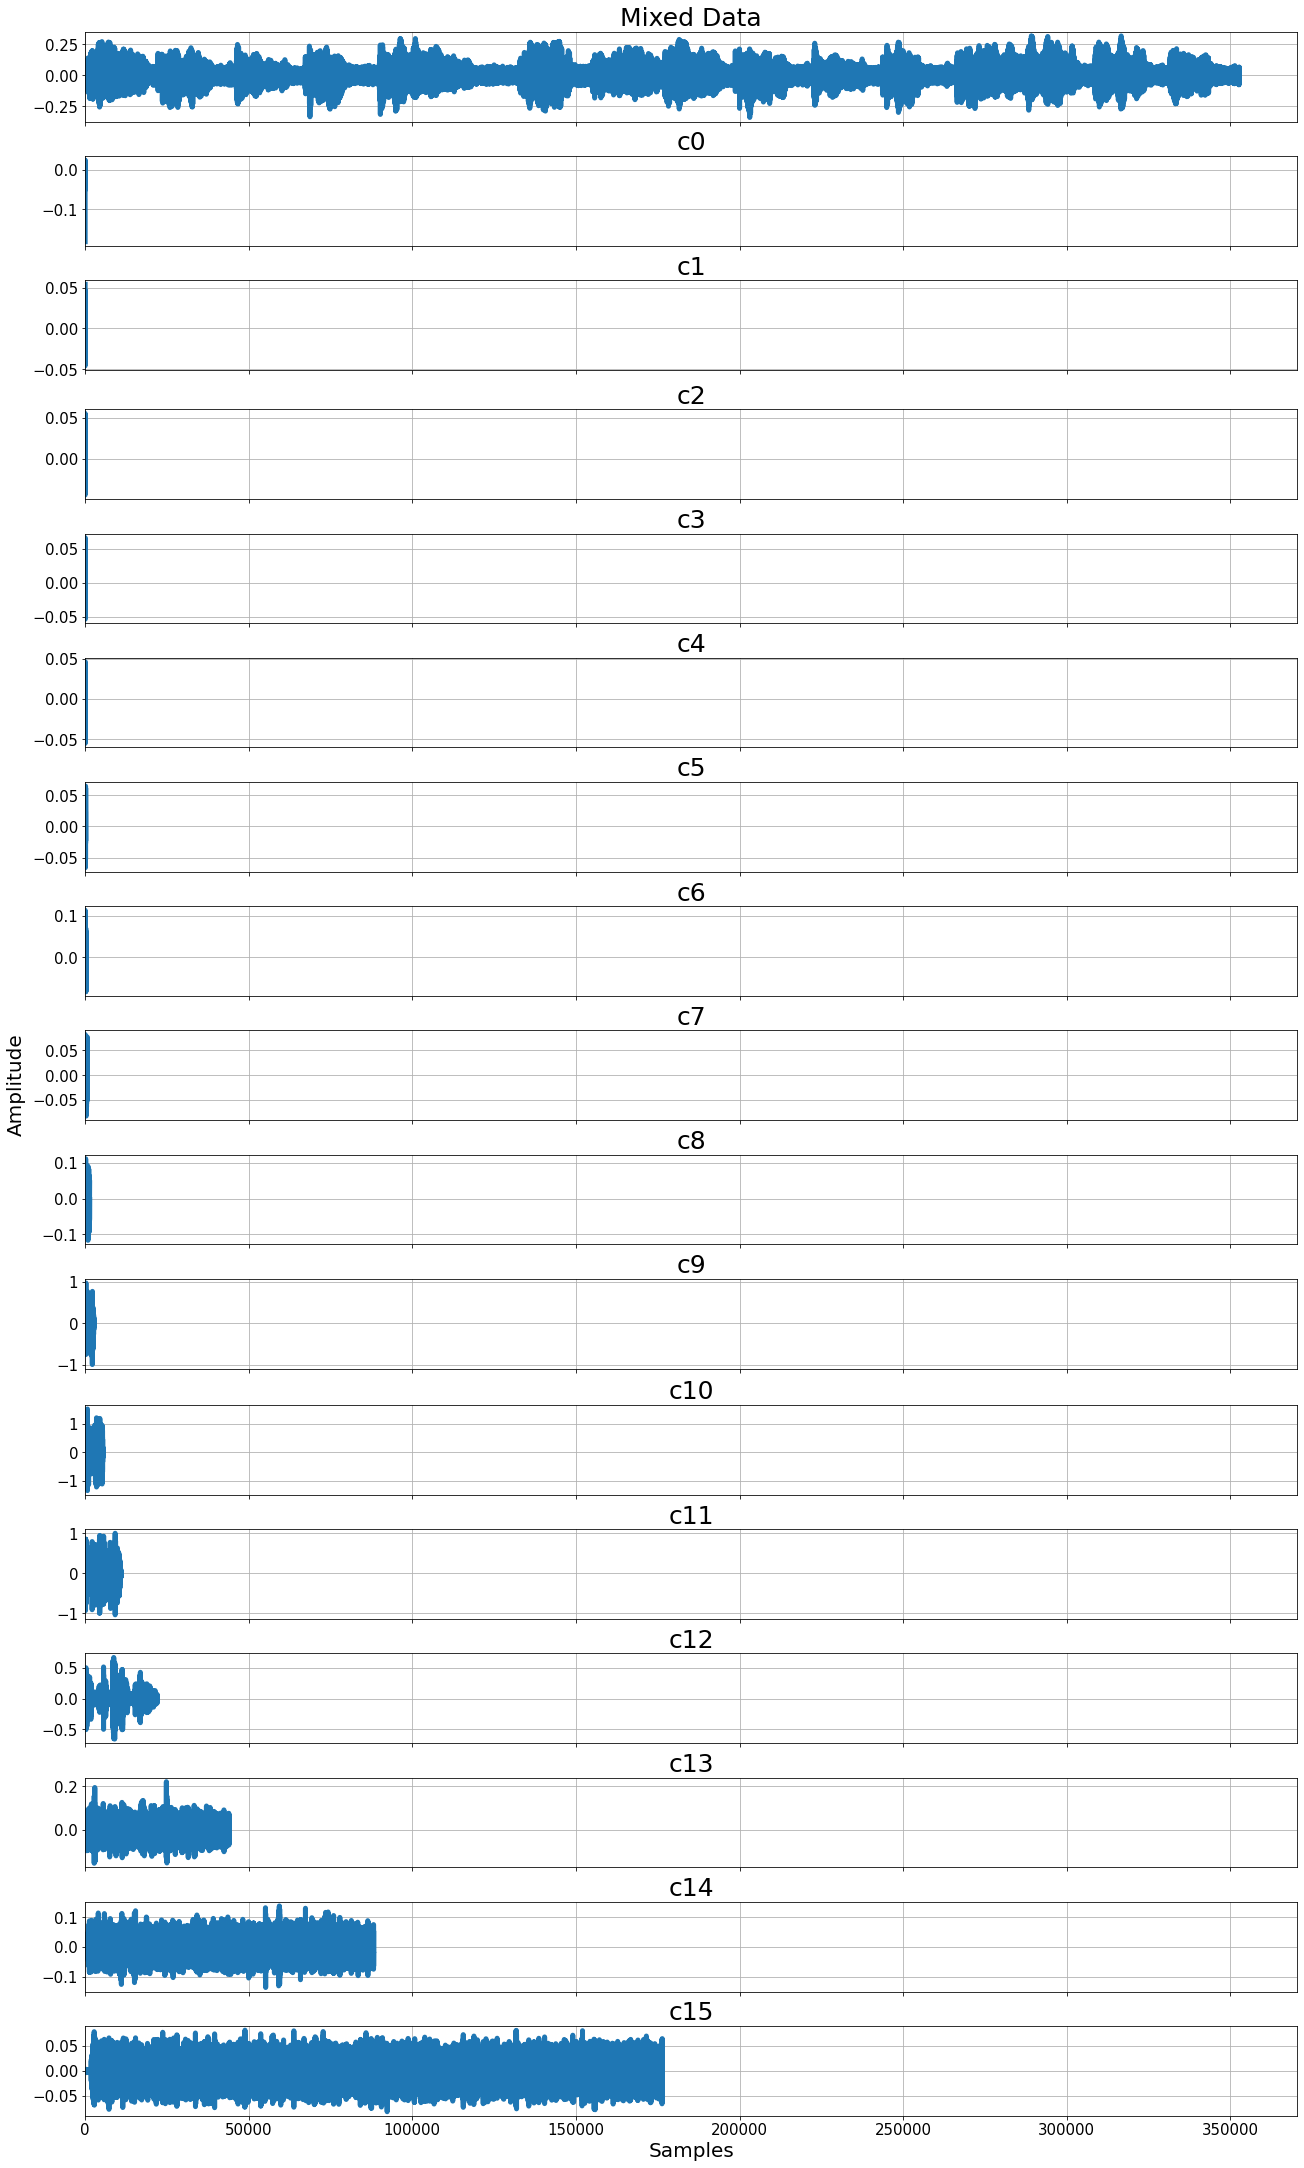

In [40]:
plot_wavelet(coeff_dmwn, d_m_wn)

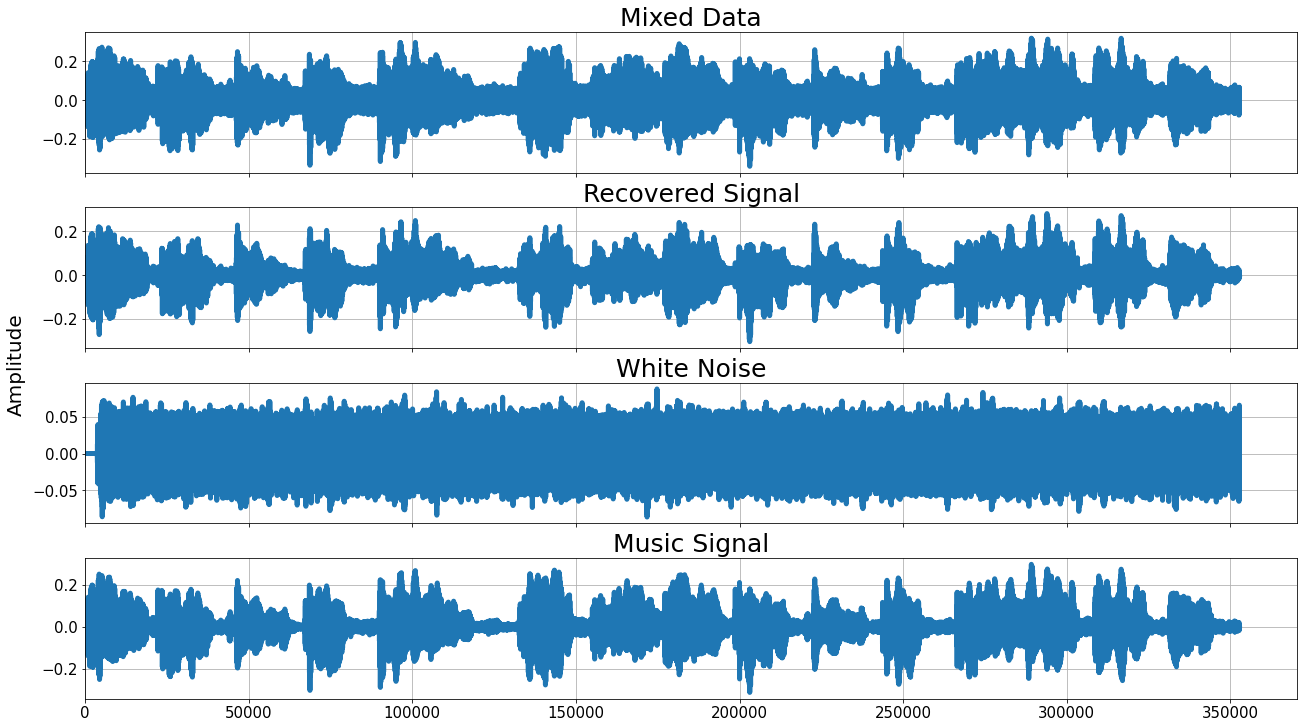

In [41]:
recov_dmwn = recover_wavelet(coeff_dmwn, 0, 4)

fig, axs = plt.subplots(4, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[0].plot(d_m_wn, lw=5)
axs[0].set_title('Mixed Data', fontsize=25)

axs[1].plot(recov_dmwn, lw=5)
axs[1].set_title('Recovered Signal', fontsize=25)

axs[2].plot(audio_files[3], lw=5)
axs[2].set_title('White Noise', fontsize=25)

axs[3].plot(audio_files[2], lw=5)
axs[3].set_title('Music Signal', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

# Street Noise + Music + Speec $d_{sn+m+s}$

In [42]:
coeff_snms = calc_wavelet(d_sn_m_s, wavelet, mode)

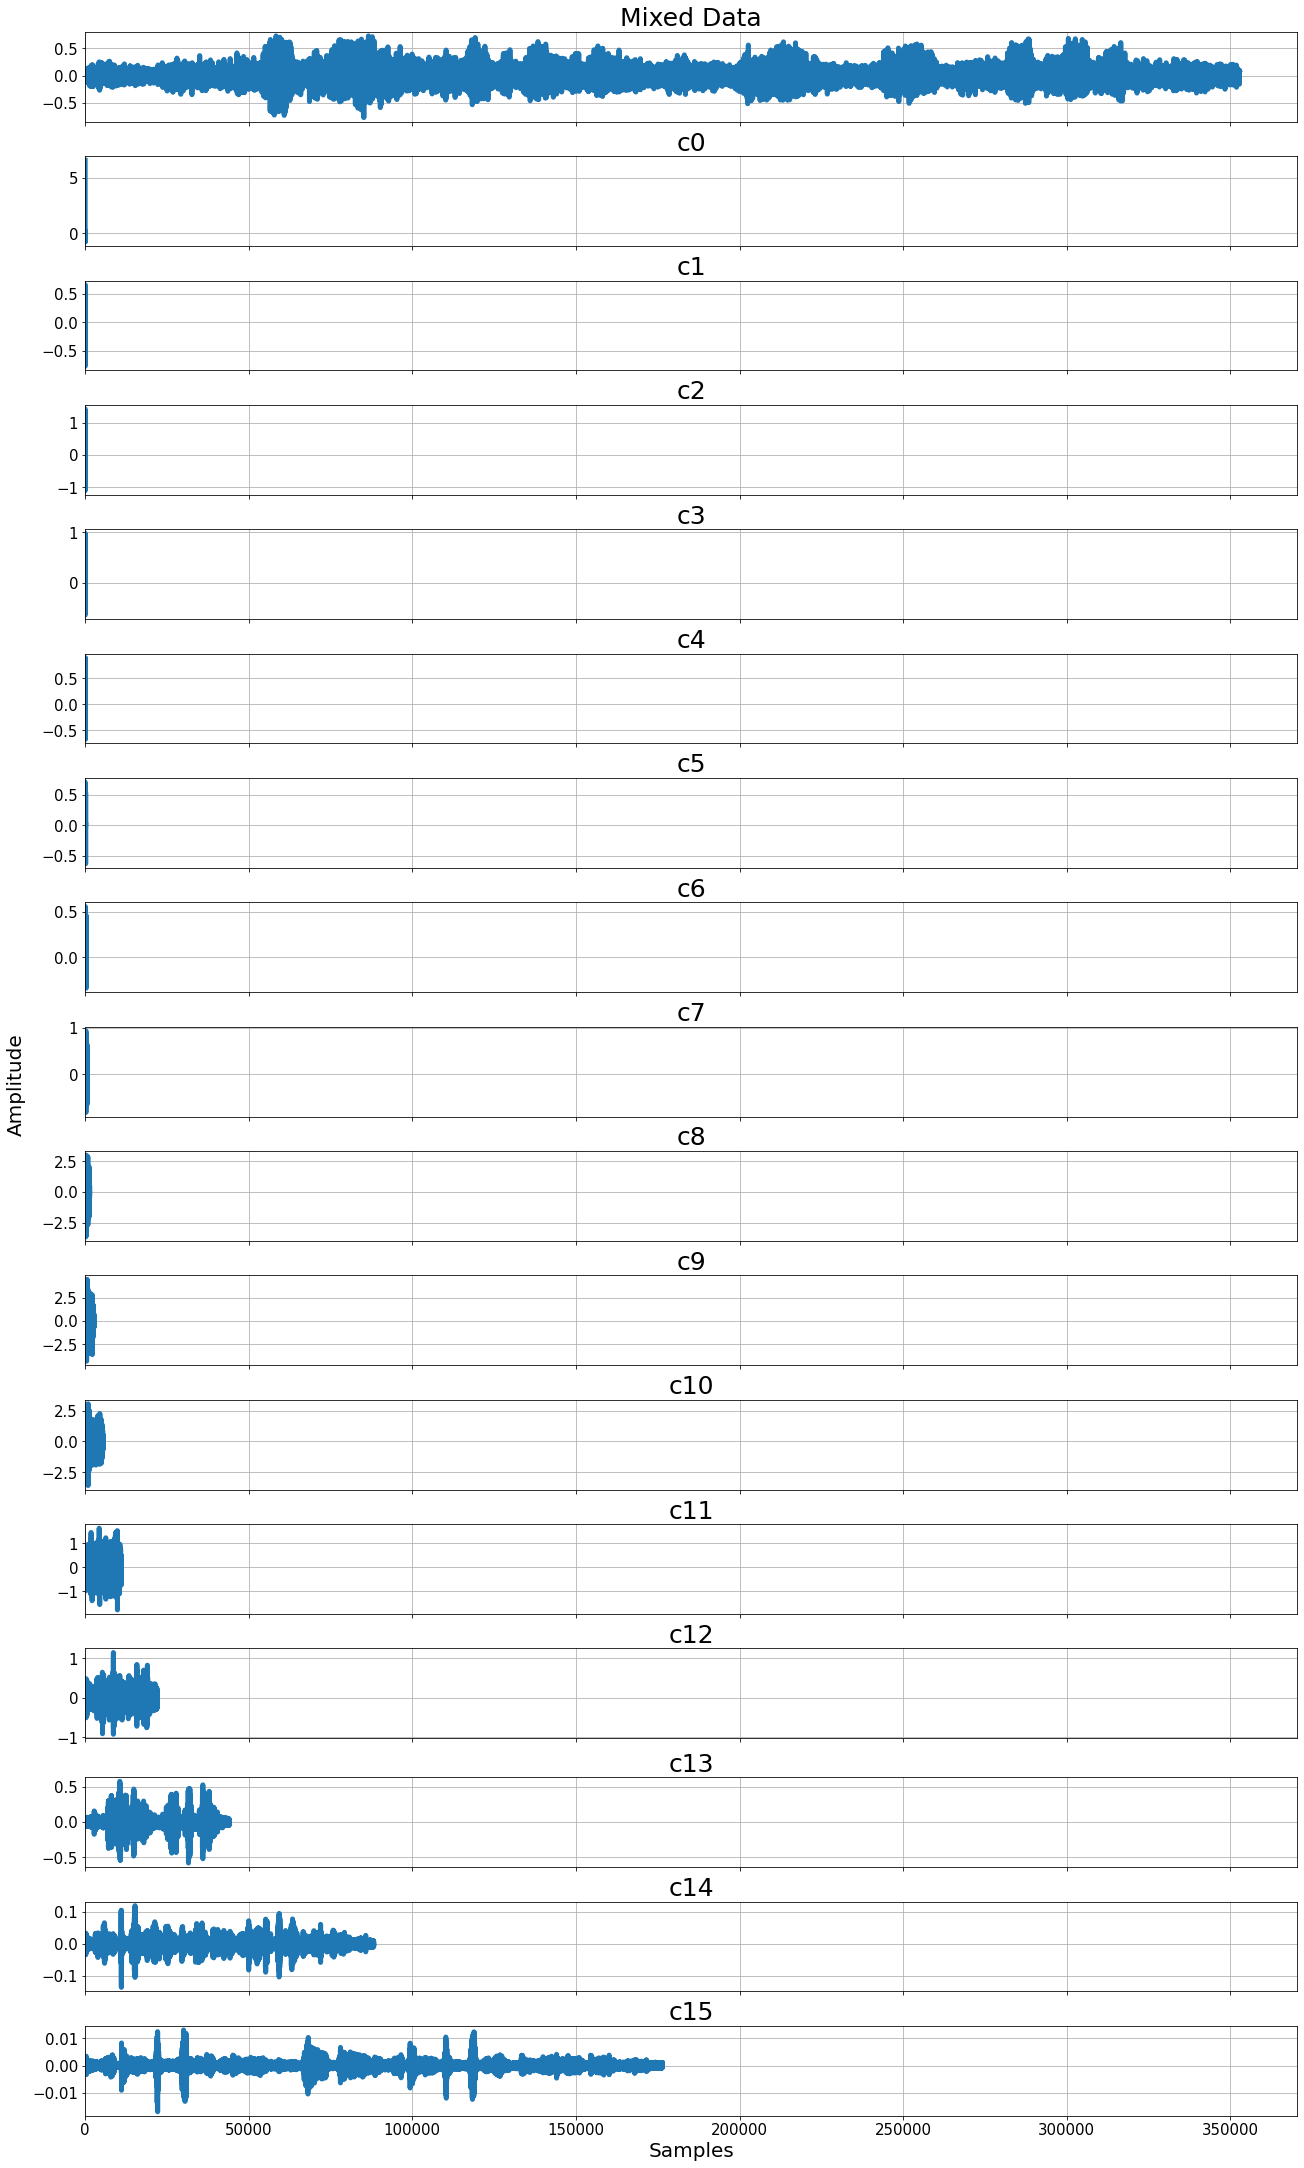

In [43]:
plot_wavelet(coeff_snms, d_sn_m_s)

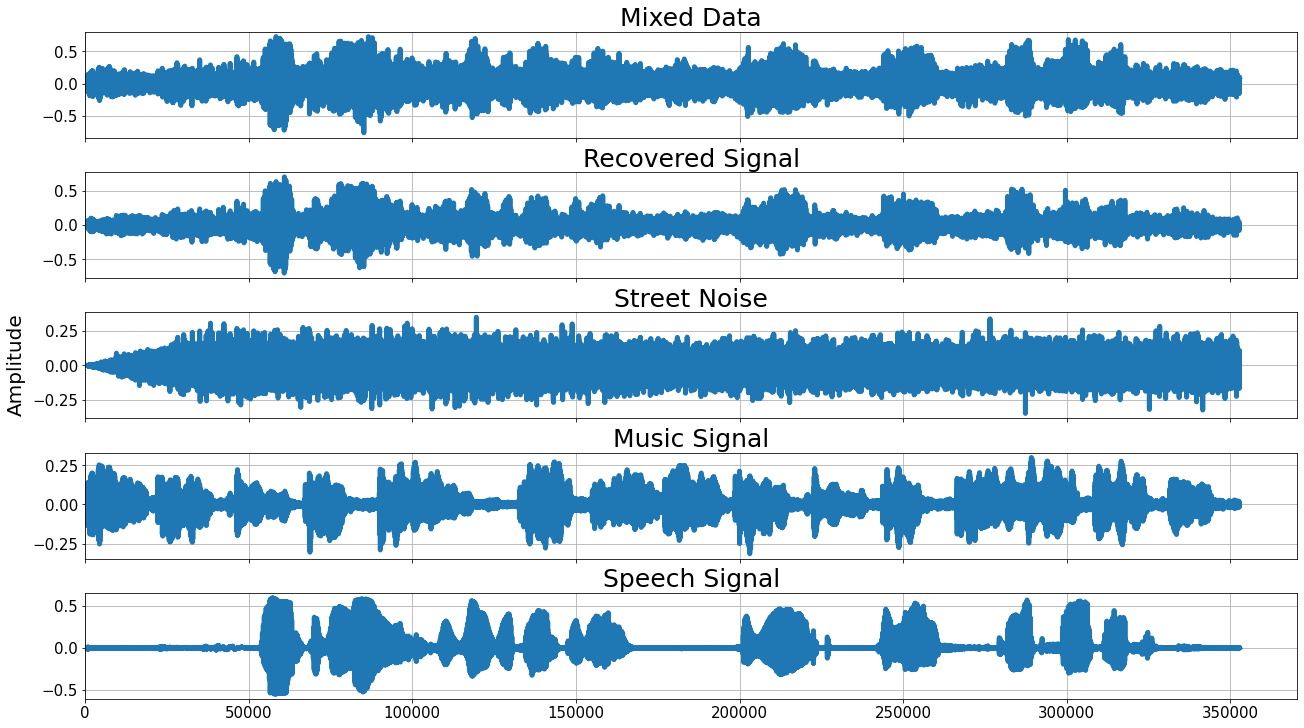

In [44]:
recov_snms = recover_wavelet(coeff_snms, 0, 5)

fig, axs = plt.subplots(5, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[0].plot(d_sn_m_s, lw=5)
axs[0].set_title('Mixed Data', fontsize=25)

axs[1].plot(recov_snms, lw=5)
axs[1].set_title('Recovered Signal', fontsize=25)

axs[2].plot(audio_files[1], lw=5)
axs[2].set_title('Street Noise', fontsize=25)

axs[3].plot(audio_files[2], lw=5)
axs[3].set_title('Music Signal', fontsize=25)

axs[4].plot(audio_files[0], lw=5)
axs[4].set_title('Speech Signal', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

# Short Time Fourier Transform (STFT)

In [45]:
import scipy.signal as signal

# Street Noise + Music + Speec $d_{sn+m+s}$

(0.0, 7000.0)

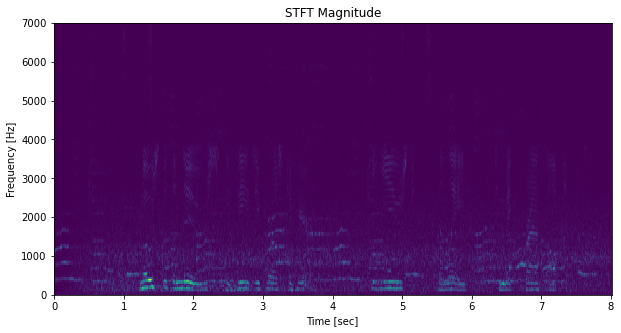

In [46]:
f, t, Zxx = signal.stft(d_sn_m_s, fs=sample_rates[0], nperseg=1000)
plt.figure(figsize=(10,5))
plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 7000)

# Music + White Noise $d_{m+wn}$

(0.0, 7000.0)

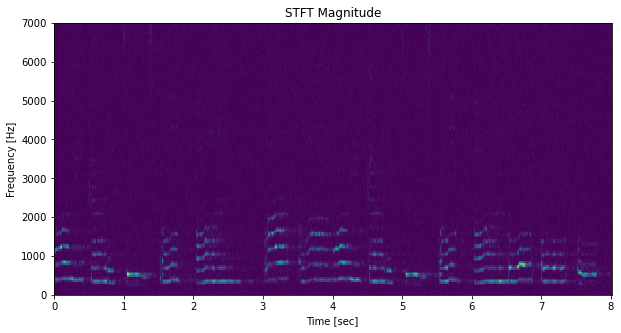

In [47]:
f, t, Zxx = signal.stft(d_m_wn, fs=sample_rates[0], nperseg=1000)
plt.figure(figsize=(10,5))
plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 7000)

# Speech + White Noise $d_{s+wn}$

(0.0, 7000.0)

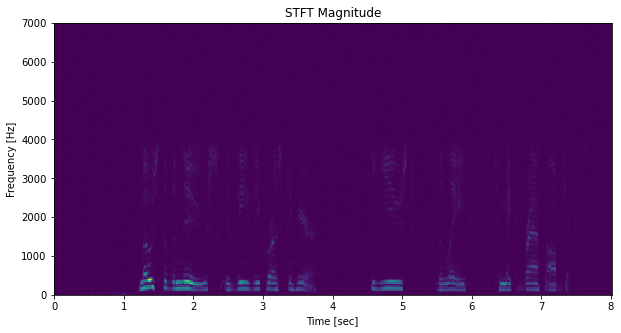

In [48]:
f, t, Zxx = signal.stft(d_s_wn, fs=sample_rates[0], nperseg=1000)
plt.figure(figsize=(10,5))
plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 7000)

# Street Noise + Music $d_{sn+m}$

(0.0, 7000.0)

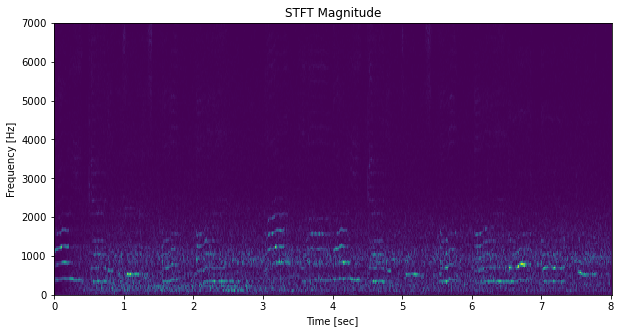

In [49]:
f, t, Zxx = signal.stft(d_sn_m, fs=sample_rates[0], nperseg=1000)
plt.figure(figsize=(10,5))
plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 7000)

# Adaptive Filter

In [50]:
import padasip as pa

# Speech + White Noise $d_{s+wn}$

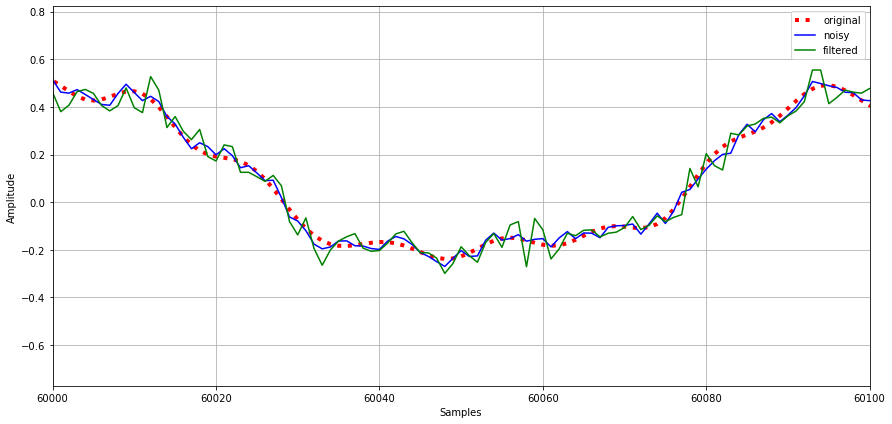

In [51]:
samples = len(audio_files[0])
memory = 10
u = audio_files[0]
v = audio_files[3]
d = d_s_wn

x = pa.input_from_history(d, memory)[:-1]
d = d[memory:]
u = u[memory:]
f = pa.filters.FilterRLS(mu=.5, n=memory)
y, e, w = f.run(d, x)

plt.figure(figsize=(12.5,6))
plt.plot(u, "r:", linewidth=4, label="original")
plt.plot(d, "b", label="noisy")
plt.plot(y, "g", label="filtered")
plt.xlim(60000, 60100)
plt.legend()
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.tight_layout()
plt.grid()